- 데이터셋 분석대상 기간 : <br>
2017-01-01 ~ 2018-08-31 (1년 8개월) <br>


- 출처 : <br>
https://www.kaggle.com/olistbr/brazilian-ecommerce <br>
https://www.kaggle.com/olistbr/marketing-funnel-olist


- 분석 주제 :<br>
 -> Olist 셀러, 판매월, 제품카테고리 중 평균 review_score가 낮은 건들을 확인하고<br>
 -> 해당 계정들에서 공통적으로 관찰되는 문제점을 파악하여 review_score 개선 전략을 세우자
 
 
- 분석 단계 :<br>
 -> 1단계 : 셀러별 월별 매출액, 판매횟수 및 기타 특징을 입력변수로 사용한 군집화 (등급)<br>
 -> 2단계 : 해당 등급 및 기타 특징을 입력변수로 사용한 review_score 예측<br>
 -> 3단계 : review_score에 영향을 미친 요인을 구체적으로 확인하기 위한 워드클라우드 확인

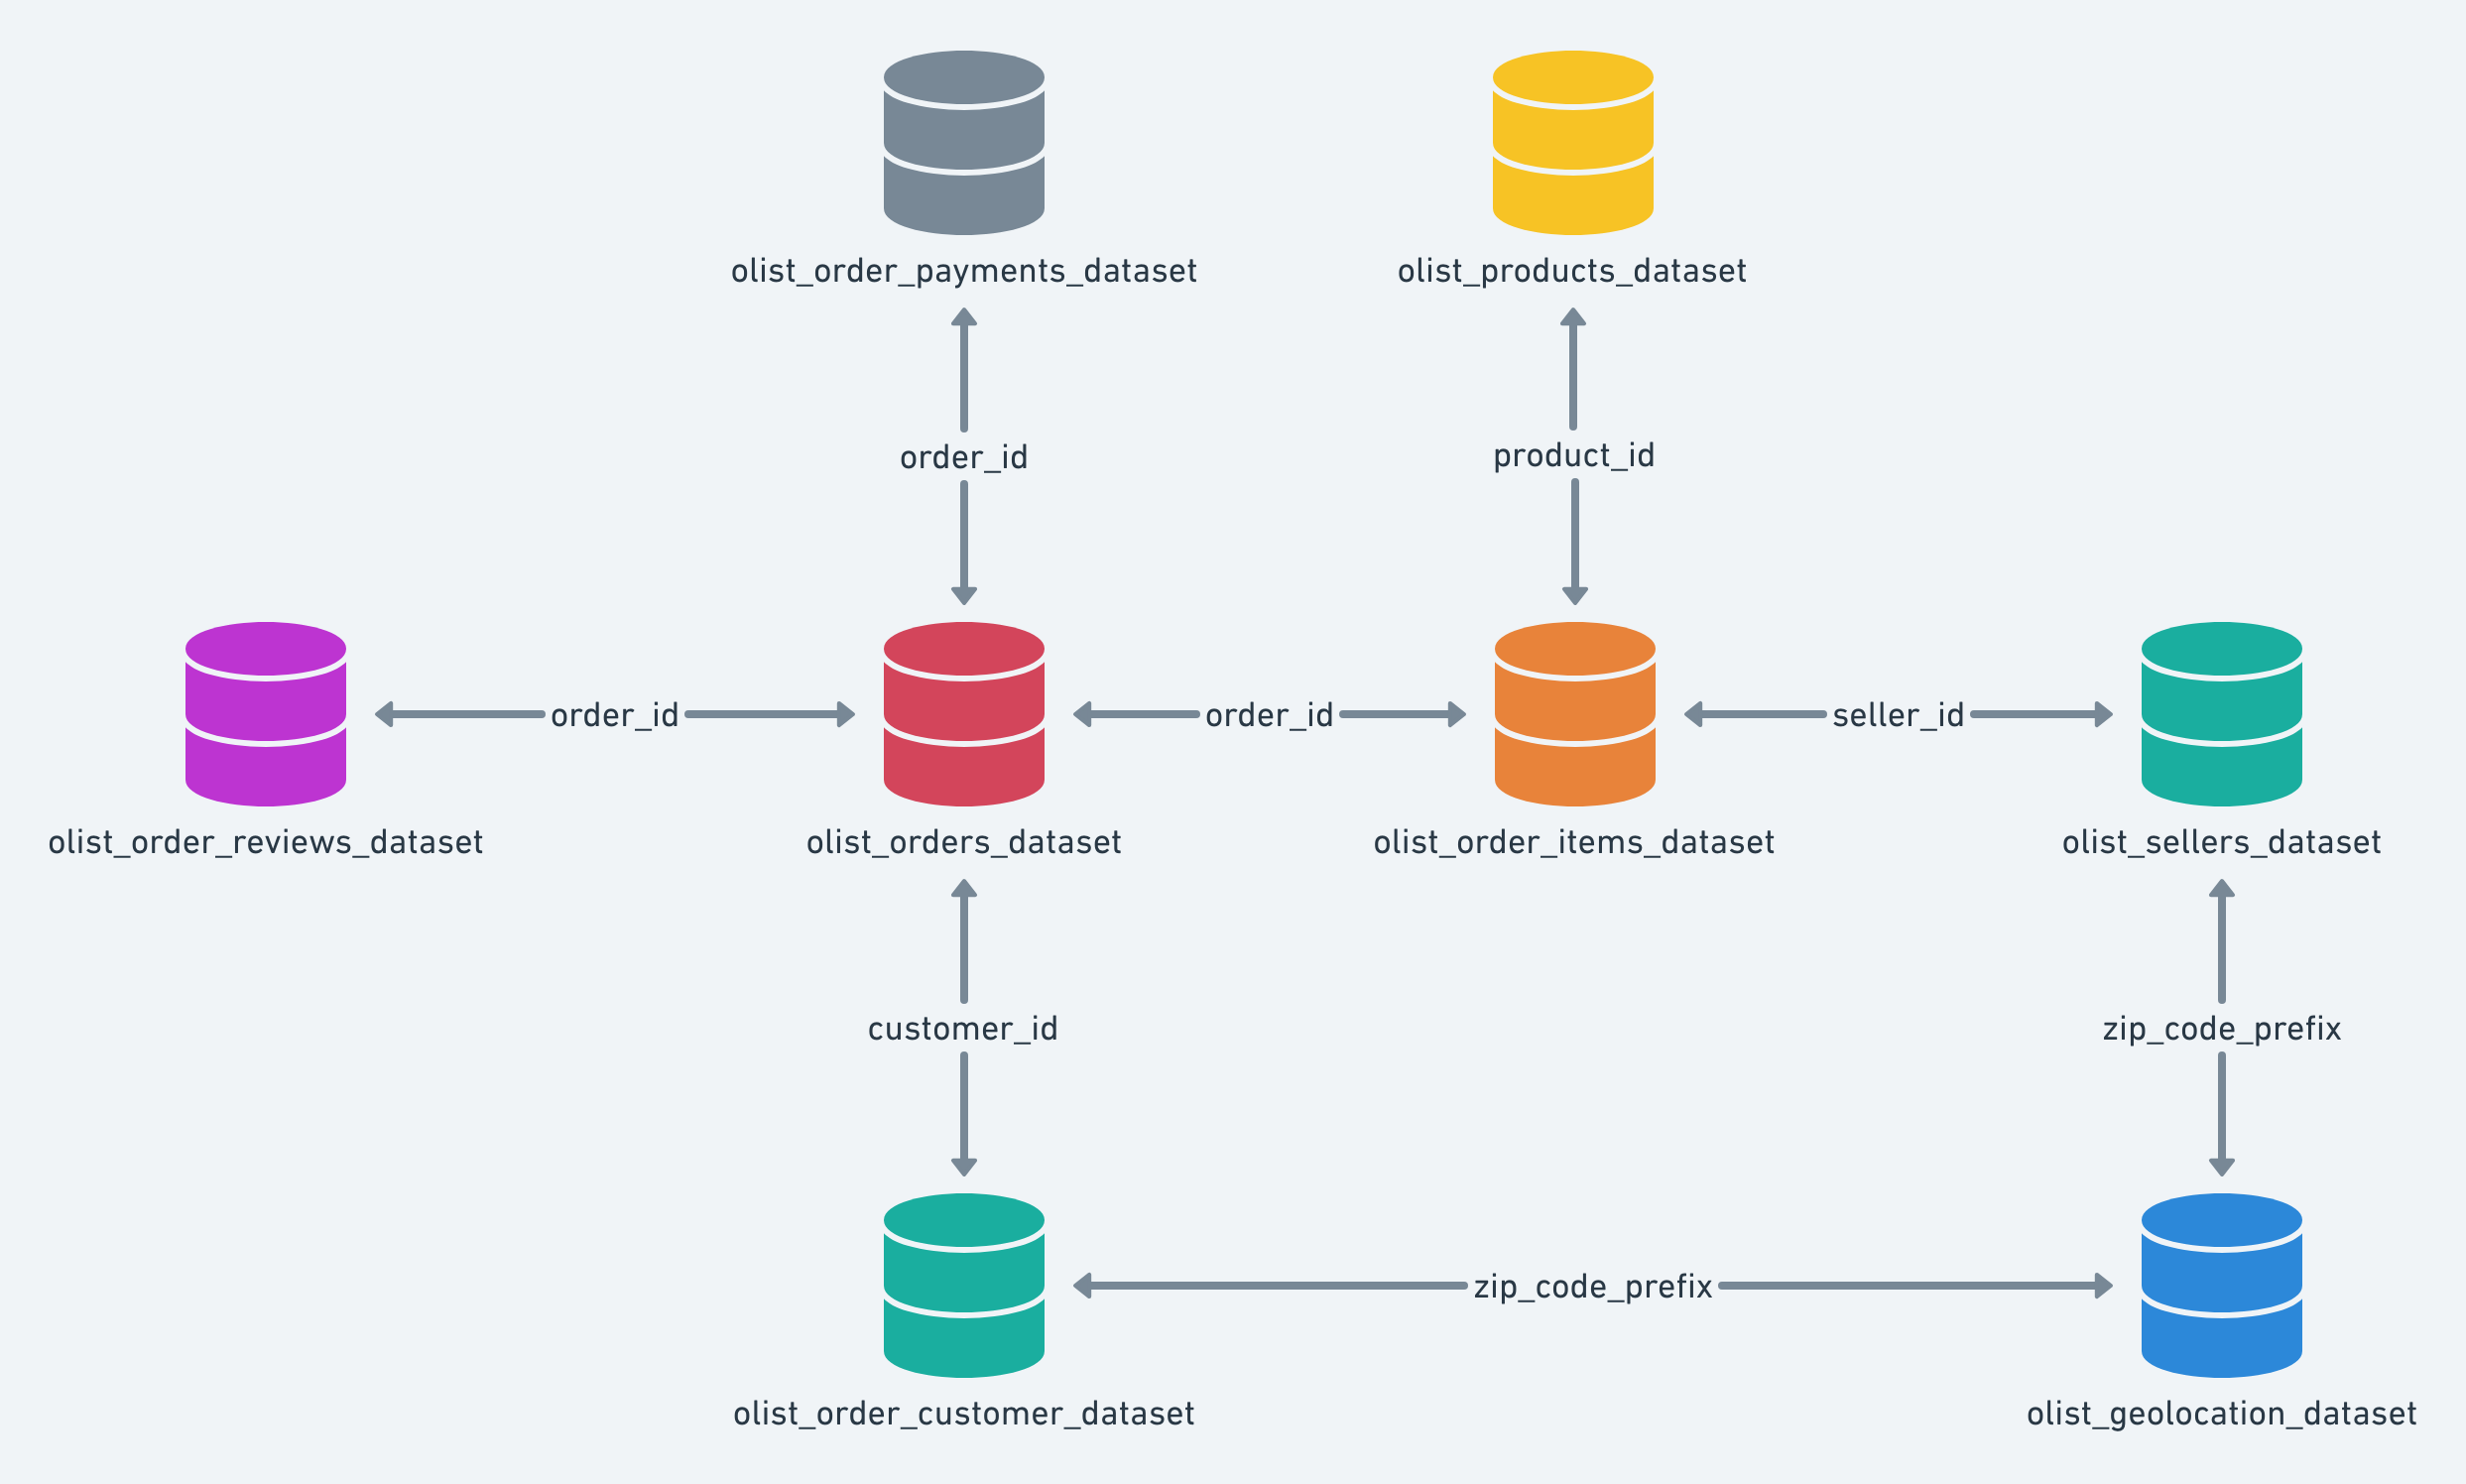

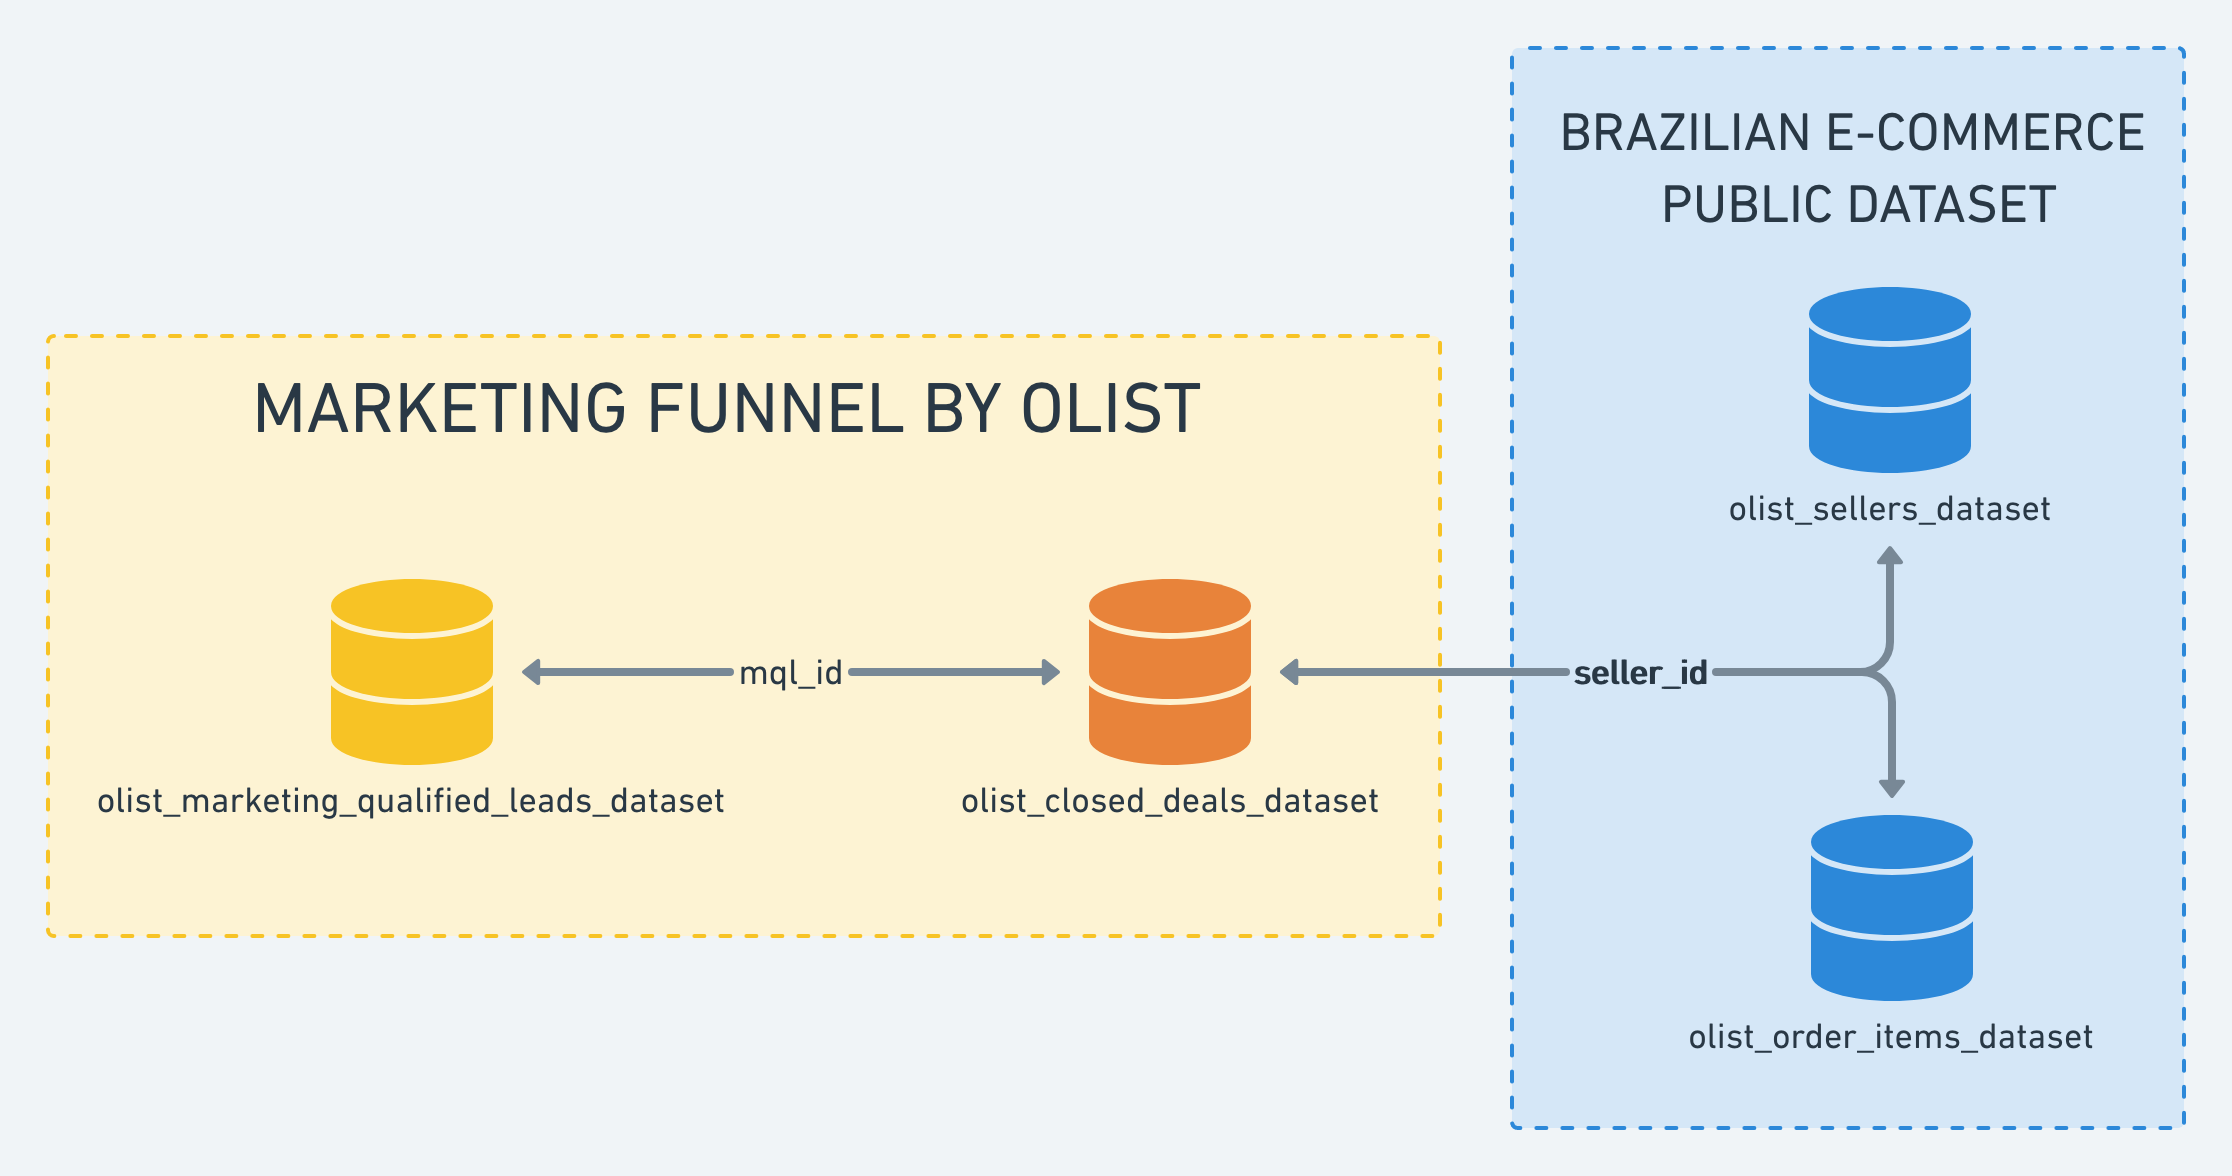

In [1707]:
%autosave 0

Autosave disabled


In [1708]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", -1)

# 데이터셋 불러오기

1) marketing_qualified_leads

In [1709]:
leads = pd.read_csv('olist_marketing_qualified_leads_dataset.csv')
leads.head(5)

mql_id first_contact_date  \
0  dac32acd4db4c29c230538b72f8dd87d  2018-02-01          
1  8c18d1de7f67e60dbd64e3c07d7e9d5d  2017-10-20          
2  b4bc852d233dfefc5131f593b538befa  2018-03-22          
3  6be030b81c75970747525b843c1ef4f8  2018-01-22          
4  5420aad7fec3549a85876ba1c529bd84  2018-02-21          

                    landing_page_id          origin  
0  88740e65d5d6b056e0cda098e1ea6313  social          
1  007f9098284a86ee80ddeb25d53e0af8  paid_search     
2  a7982125ff7aa3b2054c6e44f9d28522  organic_search  
3  d45d558f0daeecf3cccdffe3c59684aa  email           
4  b48ec5f3b04e9068441002a19df93c6c  organic_search

In [1710]:
leads.shape

(8000, 4)

In [1711]:
leads.isnull().sum()

mql_id                0 
first_contact_date    0 
landing_page_id       0 
origin                60
dtype: int64

In [1712]:
leads.describe()

mql_id first_contact_date  \
count   8000                              8000                
unique  8000                              336                 
top     0d173a5f998a6ce4a461508bd6e72668  2018-05-02          
freq    1                                 93                  

                         landing_page_id          origin  
count   8000                              7940            
unique  495                               10              
top     b76ef37428e6799c421989521c0e5077  organic_search  
freq    912                               2296

2) closed_deals_dataset

In [1713]:
closed = pd.read_csv('olist_closed_deals_dataset.csv')
closed.head(1)

mql_id                         seller_id  \
0  5420aad7fec3549a85876ba1c529bd84  2c43fb513632d29b3b58df74816f1b06   

                             sdr_id                             sr_id  \
0  a8387c01a09e99ce014107505b92388c  4ef15afb4b2723d8f3d81e51ec7afefe   

              won_date business_segment      lead_type lead_behaviour_profile  \
0  2018-02-26 19:58:54  pet              online_medium  cat                     

  has_company has_gtin average_stock business_type  \
0  NaN         NaN      NaN           reseller       

   declared_product_catalog_size  declared_monthly_revenue  
0 NaN                             0.0

In [1714]:
closed.shape

(842, 14)

In [1715]:
closed.isnull().sum()

mql_id                           0  
seller_id                        0  
sdr_id                           0  
sr_id                            0  
won_date                         0  
business_segment                 1  
lead_type                        6  
lead_behaviour_profile           177
has_company                      779
has_gtin                         778
average_stock                    776
business_type                    10 
declared_product_catalog_size    773
declared_monthly_revenue         0  
dtype: int64

In [1716]:
closed.describe()

declared_product_catalog_size  declared_monthly_revenue
count  69.000000                      8.420000e+02            
mean   233.028986                     7.337768e+04            
std    352.380558                     1.744799e+06            
min    1.000000                       0.000000e+00            
25%    30.000000                      0.000000e+00            
50%    100.000000                     0.000000e+00            
75%    300.000000                     0.000000e+00            
max    2000.000000                    5.000000e+07

In [1717]:
closed.describe(include = "O")

mql_id                         seller_id  \
count   842                               842                                
unique  842                               842                                
top     bfa4c8f989b5998d069da0a75550a7ce  b2d462f41b6b46b0569b20a8a4ebfcae   
freq    1                                 1                                  

                                  sdr_id                             sr_id  \
count   842                               842                                
unique  32                                22                                 
top     4b339f9567d060bcea4f5136b9f5949e  4ef15afb4b2723d8f3d81e51ec7afefe   
freq    140                               133                                

                   won_date business_segment      lead_type  \
count   842                  841              836             
unique  824                  33               8               
top     2018-05-04 03:00:00  home_decor       online_medium   
freq    6                    105              332             

       lead_behaviour_profile has_company has_gtin average_stock business_type  
count   665                    63          64       66            832           
unique  9                      2           2        6             3             
top     cat                    True        True     5-20          reseller      
freq    407                    58          54       22            587

3) olist_sellers_dataset

In [1718]:
seller = pd.read_csv('olist_sellers_dataset.csv')
seller.head(1)

seller_id  seller_zip_code_prefix seller_city  \
0  3442f8959a84dea7ee197c632cb2df15  13023                   campinas     

  seller_state  
0  SP

In [1719]:
seller.describe(include = 'O')

seller_id seller_city seller_state
count   3095                              3095        3095       
unique  3095                              611         23         
top     46dc3b2cc0980fb8ec44634e21d2718e  sao paulo   SP         
freq    1                                 694         1849

In [1720]:
seller.describe()

seller_zip_code_prefix
count  3095.000000           
mean   32291.059451          
std    32713.453830          
min    1001.000000           
25%    7093.500000           
50%    14940.000000          
75%    64552.500000          
max    99730.000000

4) olist_order_items_dataset

In [1721]:
item = pd.read_csv('olist_order_items_dataset.csv')
item

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  1               
1       00018f77f2f0320c557190d7a144bdd3  1               
2       000229ec398224ef6ca0657da4fc703e  1               
3       00024acbcdf0a6daa1e931b038114c75  1               
4       00042b26cf59d7ce69dfabb4e55b4fd9  1               
...                                  ... ..               
112645  fffc94f6ce00a00581880bf54a75a037  1               
112646  fffcd46ef2263f404302a634eb57f7eb  1               
112647  fffce4705a9662cd70adb13d4a31832d  1               
112648  fffe18544ffabc95dfada21779c9644f  1               
112649  fffe41c64501cc87c801fd61db3f6244  1               

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
0       2017-09-19 09:45:35  58.90   13.29          
1       2017-05-03 11:05:13  239.90  19.93          
2       2018-01-18 14:48:30  199.00  17.87          
3       2018-08-15 10:10:18  12.99   12.79          
4       2017-02-13 13:57:51  199.90  18.14          
...                     ...     ...    ...          
112645  2018-05-02 04:11:01  299.99  43.41          
112646  2018-07-20 04:31:48  350.00  36.53          
112647  2017-10-30 17:14:25  99.90   16.95          
112648  2017-08-21 00:04:32  55.99   8.72           
112649  2018-06-12 17:10:13  43.00   12.79          

[112650 rows x 7 columns]

In [1722]:
item.describe()

order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean   1.197834       120.653739     19.990320    
std    0.705124       183.633928     15.806405    
min    1.000000       0.850000       0.000000     
25%    1.000000       39.900000      13.080000    
50%    1.000000       74.990000      16.260000    
75%    1.000000       134.900000     21.150000    
max    21.000000      6735.000000    409.680000

In [1723]:
item.describe(include = 'O')

order_id                        product_id  \
count   112650                            112650                             
unique  98666                             32951                              
top     8272b63d03f5f79c56e9e4120aec44ef  aca2eb7d00ea1a7b8ebd4e68314663af   
freq    21                                527                                

                               seller_id  shipping_limit_date  
count   112650                            112650               
unique  3095                              93318                
top     6560211a19b47992c3666cc44a7e94c0  2017-07-21 18:25:23  
freq    2033                              21

In [1724]:
item[item['order_item_id'] > 10]

order_id  order_item_id  \
11942  1b15974a0141d54e36626dca3fdc731a  11              
11943  1b15974a0141d54e36626dca3fdc731a  12              
11944  1b15974a0141d54e36626dca3fdc731a  13              
11945  1b15974a0141d54e36626dca3fdc731a  14              
11946  1b15974a0141d54e36626dca3fdc731a  15              
...                                 ...  ..              
75122  ab14fdcfbe524636d65ee38360e22ce8  20              
77085  af822dacd6f5cff7376413c03a388bb7  11              
77086  af822dacd6f5cff7376413c03a388bb7  12              
84668  c05d6a79e55da72ca780ce90364abed9  11              
84669  c05d6a79e55da72ca780ce90364abed9  12              

                             product_id                         seller_id  \
11942  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11943  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11944  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11945  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11946  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
...                                 ...                               ...   
75122  9571759451b1d780ee7c15012ea109d4  ce27a3cc3c8cc1ea79d11e561e9bebb6   
77085  62995b7e571f5760017991632bbfd311  98dac6635aee4995d501a3972e047414   
77086  62995b7e571f5760017991632bbfd311  98dac6635aee4995d501a3972e047414   
84668  710b7c26b7a742f497bba45fab91a25f  98dac6635aee4995d501a3972e047414   
84669  a9d9db064d4afd4458eb3e139fe29167  98dac6635aee4995d501a3972e047414   

       shipping_limit_date   price  freight_value  
11942  2018-03-01 02:50:48  100.00  10.12          
11943  2018-03-01 02:50:48  100.00  10.12          
11944  2018-03-01 02:50:48  100.00  10.12          
11945  2018-03-01 02:50:48  100.00  10.12          
11946  2018-03-01 02:50:48  100.00  10.12          
...                    ...     ...    ...          
75122  2017-08-30 14:30:23  98.70   14.44          
77085  2018-06-13 17:30:35  5.31    15.23          
77086  2018-06-13 17:30:35  5.31    15.23          
84668  2018-05-17 13:31:00  21.15   5.54           
84669  2018-05-17 13:31:00  14.49   9.24           

[66 rows x 7 columns]

In [1725]:
# 동일 셀러에게 동일 제품을 여러개 주문한 경우, 아래와 같이 나머지 데이터는 모두 같고 order_item_id만 다르게 표시됨
item[item['order_id'] == '1b15974a0141d54e36626dca3fdc731a']

order_id  order_item_id  \
11932  1b15974a0141d54e36626dca3fdc731a  1               
11933  1b15974a0141d54e36626dca3fdc731a  2               
11934  1b15974a0141d54e36626dca3fdc731a  3               
11935  1b15974a0141d54e36626dca3fdc731a  4               
11936  1b15974a0141d54e36626dca3fdc731a  5               
11937  1b15974a0141d54e36626dca3fdc731a  6               
11938  1b15974a0141d54e36626dca3fdc731a  7               
11939  1b15974a0141d54e36626dca3fdc731a  8               
11940  1b15974a0141d54e36626dca3fdc731a  9               
11941  1b15974a0141d54e36626dca3fdc731a  10              
11942  1b15974a0141d54e36626dca3fdc731a  11              
11943  1b15974a0141d54e36626dca3fdc731a  12              
11944  1b15974a0141d54e36626dca3fdc731a  13              
11945  1b15974a0141d54e36626dca3fdc731a  14              
11946  1b15974a0141d54e36626dca3fdc731a  15              
11947  1b15974a0141d54e36626dca3fdc731a  16              
11948  1b15974a0141d54e36626dca3fdc731a  17              
11949  1b15974a0141d54e36626dca3fdc731a  18              
11950  1b15974a0141d54e36626dca3fdc731a  19              
11951  1b15974a0141d54e36626dca3fdc731a  20              

                             product_id                         seller_id  \
11932  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11933  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11934  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11935  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11936  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11937  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11938  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11939  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11940  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11941  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11942  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11943  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11944  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11945  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11946  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11947  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11948  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11949  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11950  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   
11951  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba   

       shipping_limit_date  price  freight_value  
11932  2018-03-01 02:50:48  100.0  10.12          
11933  2018-03-01 02:50:48  100.0  10.12          
11934  2018-03-01 02:50:48  100.0  10.12          
11935  2018-03-01 02:50:48  100.0  10.12          
11936  2018-03-01 02:50:48  100.0  10.12          
11937  2018-03-01 02:50:48  100.0  10.12          
11938  2018-03-01 02:50:48  100.0  10.12          
11939  2018-03-01 02:50:48  100.0  10.12          
11940  2018-03-01 02:50:48  100.0  10.12          
11941  2018-03-01 02:50:48  100.0  10.12          
11942  2018-03-01 02:50:48  100.0  10.12          
11943  2018-03-01 02:50:48  100.0  10.12          
11944  2018-03-01 02:50:48  100.0  10.12          
11945  2018-03-01 02:50:48  100.0  10.12          
11946  2018-03-01 02:50:48  100.0  10.12          
11947  2018-03-01 02:50:48  100.0  10.12          
11948  2018-03-01 02:50:48  100.0  10.12          
11949  2018-03-01 02:50:48  100.0  10.12          
11950  2018-03-01 02:50:48  100.0  10.12          
11951  2018-03-01 02:50:48  100.0  10.12

5) olist_orders_dataset

In [1726]:
order =  pd.read_csv('olist_orders_dataset.csv')
order.head(1)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   

  order_status order_purchase_timestamp    order_approved_at  \
0  delivered    2017-10-02 10:56:33      2017-10-02 11:07:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0  2017-10-04 19:55:00          2017-10-10 21:25:13            

  order_estimated_delivery_date  
0  2017-10-18 00:00:00

In [1727]:
order.describe()

order_id                       customer_id  \
count   99441                             99441                              
unique  99441                             99441                              
top     8e65781b8f5e21774c8d7b09dd79b964  5a29bb3c06beeea41656884b0a459d1c   
freq    1                                 1                                  

       order_status order_purchase_timestamp    order_approved_at  \
count   99441        99441                    99281                 
unique  8            98875                    90733                 
top     delivered    2018-03-31 15:08:21      2018-02-27 04:31:10   
freq    96478        3                        9                     

       order_delivered_carrier_date order_delivered_customer_date  \
count   97658                        96476                          
unique  81018                        95664                          
top     2018-05-09 15:48:00          2018-07-24 21:36:42            
freq    47                           3                              

       order_estimated_delivery_date  
count   99441                         
unique  459                           
top     2017-12-20 00:00:00           
freq    522

In [1728]:
order.describe(include = 'O')

order_id                       customer_id  \
count   99441                             99441                              
unique  99441                             99441                              
top     8e65781b8f5e21774c8d7b09dd79b964  5a29bb3c06beeea41656884b0a459d1c   
freq    1                                 1                                  

       order_status order_purchase_timestamp    order_approved_at  \
count   99441        99441                    99281                 
unique  8            98875                    90733                 
top     delivered    2018-03-31 15:08:21      2018-02-27 04:31:10   
freq    96478        3                        9                     

       order_delivered_carrier_date order_delivered_customer_date  \
count   97658                        96476                          
unique  81018                        95664                          
top     2018-05-09 15:48:00          2018-07-24 21:36:42            
freq    47                           3                              

       order_estimated_delivery_date  
count   99441                         
unique  459                           
top     2017-12-20 00:00:00           
freq    522

6) olist_products_dataset

In [1729]:
product = pd.read_csv('olist_products_dataset.csv')
product

product_id              product_category_name  \
0      1e9e8ef04dbcff4541ed26657ea517e5  perfumaria                          
1      3aa071139cb16b67ca9e5dea641aaa2f  artes                               
2      96bd76ec8810374ed1b65e291975717f  esporte_lazer                       
3      cef67bcfe19066a932b7673e239eb23d  bebes                               
4      9dc1a7de274444849c219cff195d0b71  utilidades_domesticas               
...                                 ...                    ...               
32946  a0b7d5a992ccda646f2d34e418fff5a0  moveis_decoracao                    
32947  bf4538d88321d0fd4412a93c974510e6  construcao_ferramentas_iluminacao   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c  cama_mesa_banho                     
32949  83808703fc0706a22e264b9d75f04a2e  informatica_acessorios              
32950  106392145fca363410d287a815be6de4  cama_mesa_banho                     

       product_name_lenght  product_description_lenght  product_photos_qty  \
0      40.0                 287.0                       1.0                  
1      44.0                 276.0                       1.0                  
2      46.0                 250.0                       1.0                  
3      27.0                 261.0                       1.0                  
4      37.0                 402.0                       4.0                  
...     ...                   ...                       ...                  
32946  45.0                 67.0                        2.0                  
32947  41.0                 971.0                       1.0                  
32948  50.0                 799.0                       1.0                  
32949  60.0                 156.0                       2.0                  
32950  58.0                 309.0                       1.0                  

       product_weight_g  product_length_cm  product_height_cm  \
0      225.0             16.0               10.0                
1      1000.0            30.0               18.0                
2      154.0             18.0               9.0                 
3      371.0             26.0               4.0                 
4      625.0             20.0               17.0                
...      ...              ...                ...                
32946  12300.0           40.0               40.0                
32947  1700.0            16.0               19.0                
32948  1400.0            27.0               7.0                 
32949  700.0             31.0               13.0                
32950  2083.0            12.0               2.0                 

       product_width_cm  
0      14.0              
1      20.0              
2      15.0              
3      26.0              
4      13.0              
...     ...              
32946  40.0              
32947  16.0              
32948  27.0              
32949  20.0              
32950  7.0               

[32951 rows x 9 columns]

In [1730]:
product.describe()

product_name_lenght  product_description_lenght  product_photos_qty  \
count  32341.000000         32341.000000                32341.000000         
mean   48.476949            771.495285                  2.188986             
std    10.245741            635.115225                  1.736766             
min    5.000000             4.000000                    1.000000             
25%    42.000000            339.000000                  1.000000             
50%    51.000000            595.000000                  1.000000             
75%    57.000000            972.000000                  3.000000             
max    76.000000            3992.000000                 20.000000            

       product_weight_g  product_length_cm  product_height_cm  \
count  32949.000000      32949.000000       32949.000000        
mean   2276.472488       30.815078          16.937661           
std    4282.038731       16.914458          13.637554           
min    0.000000          7.000000           2.000000            
25%    300.000000        18.000000          8.000000            
50%    700.000000        25.000000          13.000000           
75%    1900.000000       38.000000          21.000000           
max    40425.000000      105.000000         105.000000          

       product_width_cm  
count  32949.000000      
mean   23.196728         
std    12.079047         
min    6.000000          
25%    15.000000         
50%    20.000000         
75%    30.000000         
max    118.000000

In [1731]:
product.describe(include = 'O')

product_id product_category_name
count   32951                             32341               
unique  32951                             73                  
top     83fc9abe24667777b997571da7b6052a  cama_mesa_banho     
freq    1                                 3029

7) product_category_name_translation

In [1732]:
name = pd.read_csv('product_category_name_translation.csv')
name.head(1)

product_category_name product_category_name_english
0  beleza_saude          health_beauty

8) olist_geolocation_dataset

In [1733]:
geo = pd.read_csv('olist_geolocation_dataset.csv')
geo.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0  1037                        -23.545621       -46.639292         
1  1046                        -23.546081       -46.644820         
2  1046                        -23.546129       -46.642951         
3  1041                        -23.544392       -46.639499         
4  1035                        -23.541578       -46.641607         

  geolocation_city geolocation_state  
0  sao paulo        SP                
1  sao paulo        SP                
2  sao paulo        SP                
3  sao paulo        SP                
4  sao paulo        SP

9) olist_order_reviews_dataset

In [1734]:
review = pd.read_csv('olist_order_reviews_dataset.csv')
review.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0  4             NaN                   
1  5             NaN                   
2  5             NaN                   
3  5             NaN                   
4  5             NaN                   

                                                                                 review_comment_message  \
0  NaN                                                                                                    
1  NaN                                                                                                    
2  NaN                                                                                                    
3  Recebi bem antes do prazo estipulado.                                                                  
4  Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa   

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00  2018-01-18 21:46:59     
1  2018-03-10 00:00:00  2018-03-11 03:05:13     
2  2018-02-17 00:00:00  2018-02-18 14:36:24     
3  2017-04-21 00:00:00  2017-04-21 22:02:06     
4  2018-03-01 00:00:00  2018-03-02 10:26:53

In [1735]:
review['review_score'].count()

100000

In [1736]:
review.describe(include = 'O')

review_id                          order_id  \
count   100000                            100000                             
unique  99173                             99441                              
top     9e25d6e3025e9b9a0fc7f03588d33e2b  8e17072ec97ce29f0e1f111e598b0c85   
freq    3                                 3                                  

       review_comment_title review_comment_message review_creation_date  \
count   11715                41753                  100000                
unique  4600                 36921                  637                   
top     Recomendo            Muito bom              2017-12-19 00:00:00   
freq    426                  230                    466                   

       review_answer_timestamp  
count   100000                  
unique  99010                   
top     2017-06-15 23:21:05     
freq    4

# EDA 및 데이터 통합

## item 데이터셋 전처리

In [1737]:
# price(제품 가격)과 freight_value(배송비)를 더한 'revenue' 컬럼 생성
item['revenue'] = item['price'] + item['freight_value']
item

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  1               
1       00018f77f2f0320c557190d7a144bdd3  1               
2       000229ec398224ef6ca0657da4fc703e  1               
3       00024acbcdf0a6daa1e931b038114c75  1               
4       00042b26cf59d7ce69dfabb4e55b4fd9  1               
...                                  ... ..               
112645  fffc94f6ce00a00581880bf54a75a037  1               
112646  fffcd46ef2263f404302a634eb57f7eb  1               
112647  fffce4705a9662cd70adb13d4a31832d  1               
112648  fffe18544ffabc95dfada21779c9644f  1               
112649  fffe41c64501cc87c801fd61db3f6244  1               

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  revenue  
0       2017-09-19 09:45:35  58.90   13.29          72.19    
1       2017-05-03 11:05:13  239.90  19.93          259.83   
2       2018-01-18 14:48:30  199.00  17.87          216.87   
3       2018-08-15 10:10:18  12.99   12.79          25.78    
4       2017-02-13 13:57:51  199.90  18.14          218.04   
...                     ...     ...    ...             ...   
112645  2018-05-02 04:11:01  299.99  43.41          343.40   
112646  2018-07-20 04:31:48  350.00  36.53          386.53   
112647  2017-10-30 17:14:25  99.90   16.95          116.85   
112648  2017-08-21 00:04:32  55.99   8.72           64.71    
112649  2018-06-12 17:10:13  43.00   12.79          55.79    

[112650 rows x 8 columns]

In [1738]:
# 동일 셀러에게 동일 제품을 여러개 주문한 경우의 데이터 합치기
item = item.groupby(["order_id","product_id","seller_id","shipping_limit_date","price","freight_value"]).agg(
    {"order_item_id" : "count", "revenue" : "sum"}).reset_index().rename(columns = {"order_item_id" : "num"})
item

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
102420  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
102421  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
102422  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
102423  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
102424  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  shipping_limit_date   price  \
0       48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.90    
1       dd7ddc04e1b6c2c614352b383efe2d36  2017-05-03 11:05:13  239.90   
2       5b51032eddd242adc84c38acab88f23d  2018-01-18 14:48:30  199.00   
3       9d7a1d34a5052409006425275ba1c2b4  2018-08-15 10:10:18  12.99    
4       df560393f3a51e74553ab94004ba5c87  2017-02-13 13:57:51  199.90   
...                                  ...                  ...     ...   
102420  b8bc237ba3788b23da09c0f1f3a3288c  2018-05-02 04:11:01  299.99   
102421  f3c38ab652836d21de61fb8314b69182  2018-07-20 04:31:48  350.00   
102422  c3cfdc648177fdbbbb35635a37472c53  2017-10-30 17:14:25  99.90    
102423  2b3e4a2a3ea8e01938cabda2a3e5cc79  2017-08-21 00:04:32  55.99    
102424  f7ccf836d21b2fb1de37564105216cc1  2018-06-12 17:10:13  43.00    

        freight_value  num  revenue  
0       13.29          1    72.19    
1       19.93          1    259.83   
2       17.87          1    216.87   
3       12.79          1    25.78    
4       18.14          1    218.04   
...       ...         ..       ...   
102420  43.41          1    343.40   
102421  36.53          1    386.53   
102422  16.95          1    116.85   
102423  8.72           1    64.71    
102424  12.79          1    55.79    

[102425 rows x 8 columns]

## seller_id x order_id

### 셀러별 판매건수 확인

In [1739]:
# 전체 셀러 : 3095명
seller_order = item.groupby('seller_id')['order_id'].agg('count').sort_values(ascending = False)
seller_order = seller_order.reset_index()
seller_order

seller_id  order_id
0     6560211a19b47992c3666cc44a7e94c0  1982    
1     4a3ca9315b744ce9f8e9374361493884  1889    
2     cc419e0650a3c5ba77189a1882b7556a  1720    
3     1f50f920176fa81dab994f9023523100  1473    
4     da8622b14eb17ae2831f4ac5b9dab84a  1438    
...                                ...   ...    
3090  75fdd0a732287f9497b179f6bd445d32  1       
3091  b9de031b671cd48b28fae9d828cbf2b4  1       
3092  24c1de8d9551c0b4fbc53317d53efda8  1       
3093  ba8e85df286308fe68a2ce83a8f8b2d6  1       
3094  7d81e74a4755b552267cd5e081563028  1       

[3095 rows x 2 columns]

In [1740]:
# 판매를 2건 이상 한 셀러 : 2532명
seller_order[seller_order['order_id']>1]

seller_id  order_id
0     6560211a19b47992c3666cc44a7e94c0  1982    
1     4a3ca9315b744ce9f8e9374361493884  1889    
2     cc419e0650a3c5ba77189a1882b7556a  1720    
3     1f50f920176fa81dab994f9023523100  1473    
4     da8622b14eb17ae2831f4ac5b9dab84a  1438    
...                                ...   ...    
2527  4eeb99008a0f59d2c7759c59f9a346eb  2       
2528  63272377184e969942f7fff221be858d  2       
2529  78ba5933c21686d1c2f64669c8c459e7  2       
2530  6c9875b2f94ba781186f0c1aed8d1687  2       
2531  788f22bafdd7ab0e1e79f19db72f16a4  2       

[2532 rows x 2 columns]

array([[<AxesSubplot:title={'center':'order_id'}>]], dtype=object)

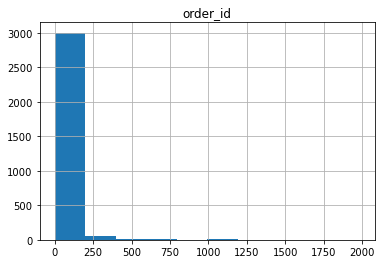

In [1741]:
# 전체 셀러 판매건수 분포 확인
seller_order.hist()

array([[<AxesSubplot:title={'center':'order_id'}>]], dtype=object)

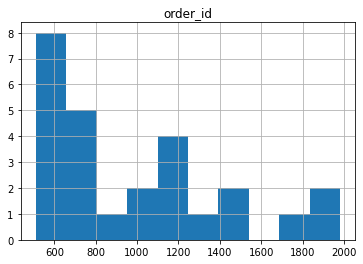

In [1742]:
# 판매 건수가 500 이상인 셀러 판매건수 분포 확인
seller_order[seller_order['order_id']>500].hist()

In [1743]:
# 전체 셀러 중 2건 이상 판매한 셀러 비율 : 약 81.8%
seller_order[seller_order['order_id']>1].shape[0] / seller_order.shape[0]

0.8180936995153474

### 주문별 판매 아이템수(num) 확인

In [1744]:
# 주문별 판매 아이템수는 1~8개 사이에 분포
seller_orderitem = item.groupby('order_id')['num'].count().sort_values(ascending = False)
seller_orderitem = seller_orderitem.reset_index()
seller_orderitem

order_id  num
0      ca3625898fbd48669d50701aba51cd5f  8  
1      7d8f5bfd5aff648220374a2df62e84d5  7  
2      77df84f9195be22a4e9cb72ca9e8b4c2  7  
3      ad850e69fce9a512ada84086651a2e7d  7  
4      3990f96693d321ac142fff312bf3706a  6  
...                                 ... ..  
98661  a9d9773efe0a981195d2861250cff4d9  1  
98662  a9d9e48bc0905664f33c53779b5edfb6  1  
98663  a9da0d64f6c4dff3f3f383f6b076b24a  1  
98664  a9da66f1dfe4cca8956f5e74619c2cb9  1  
98665  00010242fe8c5a6d1ba2dd792cb16214  1  

[98666 rows x 2 columns]

In [1745]:
# 동일 order_id에 다양한 product_id, seller_id가 있는 경우
item[item['order_id']=='ca3625898fbd48669d50701aba51cd5f']

order_id                        product_id  \
80867  ca3625898fbd48669d50701aba51cd5f  0cf2faf9749f53924cea652a09d8e327   
80868  ca3625898fbd48669d50701aba51cd5f  0de59eddc63167215c972b0d785ffa7b   
80869  ca3625898fbd48669d50701aba51cd5f  1065e0ebef073787a7bf691924c60eeb   
80870  ca3625898fbd48669d50701aba51cd5f  21b524c4c060169fa75ccf08c7da4627   
80871  ca3625898fbd48669d50701aba51cd5f  309dd69eb83cea38c51709d62befe1a4   
80872  ca3625898fbd48669d50701aba51cd5f  4a5c3967bfd3629fe07ef4d0cc8c3818   
80873  ca3625898fbd48669d50701aba51cd5f  5dae498eff2d80057f56122235a36aff   
80874  ca3625898fbd48669d50701aba51cd5f  678c229b41c0e497d35a25a8be1cc631   

                              seller_id  shipping_limit_date  price  \
80867  0b35c634521043bf4b47e21547b99ab5  2018-08-16 02:25:07  33.9    
80868  0b35c634521043bf4b47e21547b99ab5  2018-08-16 02:25:07  159.0   
80869  0b35c634521043bf4b47e21547b99ab5  2018-08-16 02:25:07  309.0   
80870  0b35c634521043bf4b47e21547b99ab5  2018-08-16 02:25:07  63.7    
80871  0b35c634521043bf4b47e21547b99ab5  2018-08-16 02:25:07  56.0    
80872  0b35c634521043bf4b47e21547b99ab5  2018-08-16 02:25:07  109.9   
80873  888faa8bfb0b159c37de6d898b961c31  2018-08-17 02:25:07  95.9    
80874  888faa8bfb0b159c37de6d898b961c31  2018-08-17 02:25:07  95.9    

       freight_value  num  revenue  
80867  1.84           1    35.74    
80868  3.67           2    325.34   
80869  1.84           1    310.84   
80870  0.15           1    63.85    
80871  3.68           2    119.36   
80872  0.15           1    110.05   
80873  0.15           1    96.05    
80874  0.15           1    96.05

In [1746]:
# 같은 셀러에게 같은 아이템을 여러개 구매한 경우 아래와 같이 'num' 컬럼에 표시됨
item[item['order_id']=='428a2f660dc84138d969ccd69a0ab6d5']

order_id                        product_id  \
26550  428a2f660dc84138d969ccd69a0ab6d5  89b190a046022486c635022524a974a8   

                              seller_id  shipping_limit_date  price  \
26550  f326006815956455b2859abd58fe7e39  2017-11-30 10:30:51  65.49   

       freight_value  num  revenue  
26550  16.22          15   1225.65

array([[<AxesSubplot:title={'center':'num'}>]], dtype=object)

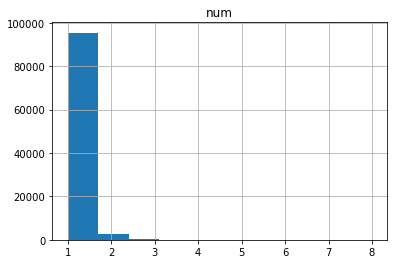

In [1747]:
# 주문당 판매 아이템 수 분포 확인
seller_orderitem.hist()

array([[<AxesSubplot:title={'center':'num'}>]], dtype=object)

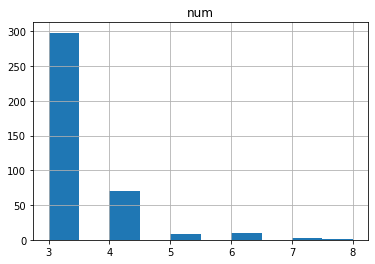

In [1748]:
# 주문당 판매 아이템 수가 2 이상인 판매 아이템 수 분포 확인
seller_orderitem[seller_orderitem['num']>2].hist()

In [1749]:
# 한 order_id에 num 2개 이상인 경우 : 약 3.3%
seller_orderitem[seller_orderitem['num']>1].shape[0] / seller_orderitem.shape[0]

0.032797518902154744

## seller_id x revenue

### 셀러별 price, freight_value, revenue 확인

In [1750]:
# revenue는 약 12 ~ 249640 BRL (약 2,400 ~ 50,130,000원) 사이에 분포
# revenue는 판매기간에 따라 다르므로 주문건별, 월별 매출로 비교할 필요가 있음
seller_revenue = item.groupby('seller_id')[['price', 'freight_value', 'revenue']].agg('sum').sort_values(by = 'revenue', ascending = False)
seller_revenue

price  freight_value    revenue
seller_id                                                            
4869f7a5dfa277a7dca6462dcf3b52b2  227406.24  19938.61       249640.70
7c67e1448b00f6e969d365cea6b010ab  143385.27  38677.08       239536.44
53243585a1d6dc2643021fd1853d8905  208199.61  11750.24       235856.68
4a3ca9315b744ce9f8e9374361493884  191178.72  33209.72       235539.96
fa1c13f2614d7b5c4749cbc52fecda94  194042.03  10042.70       204084.73
...                                     ...       ...             ...
702835e4b785b67a084280efca355756  7.60       10.96          18.56    
4965a7002cca77301c82d3f91b82e1a9  8.49       7.87           16.36    
1fa2d3def6adfa70e58c276bb64fe5bb  6.90       9.00           15.90    
77128dec4bec4878c37ab7d6169d6f26  6.50       8.72           15.22    
cf6f6bc4df3999b9c6440f124fb2f687  3.50       8.72           12.22    

[3095 rows x 3 columns]

<AxesSubplot:>

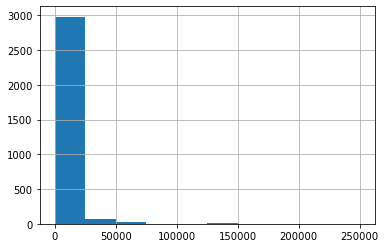

In [1751]:
# 셀러별 revenue 분포 확인
seller_revenue['revenue'].hist()

In [1752]:
# 주문당 매출은 약12 ~ 6922 BRL (약 2,400 ~ 1,390,000원) 사이에 분포
seller_item_revenue = item.groupby('seller_id')[['order_id', 'revenue']].agg({'order_id' : 'count', 'revenue' : 'sum'})
seller_item_revenue['revenue_per_order'] = seller_item_revenue['revenue'] / seller_item_revenue['order_id']
seller_item_revenue.sort_values(by = 'revenue_per_order', ascending = False)

order_id   revenue  revenue_per_order
seller_id                                                              
80ceebb4ee9b31afb6c6a916a574a1e2  1         6922.21   6922.21          
ee27a8f15b1dded4d213a468ba4eb391  1         6726.66   6726.66          
b37c4c02bda3161a7546a4e6d222d5b2  4         24487.60  6121.90          
585175ec331ea177fa47199e39a6170a  1         3602.47   3602.47          
abe021b01ba992245271b9aa422032df  2         6837.24   3418.62          
...                              ..             ...       ...          
702835e4b785b67a084280efca355756  1         18.56     18.56            
4965a7002cca77301c82d3f91b82e1a9  1         16.36     16.36            
1fa2d3def6adfa70e58c276bb64fe5bb  1         15.90     15.90            
77128dec4bec4878c37ab7d6169d6f26  1         15.22     15.22            
cf6f6bc4df3999b9c6440f124fb2f687  1         12.22     12.22            

[3095 rows x 3 columns]

### ★item, order 데이터셋 합치기

In [1753]:
order

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0      delivered    2017-10-02 10:56:33      2017-10-02 11:07:15   
1      delivered    2018-07-24 20:41:37      2018-07-26 03:24:27   
2      delivered    2018-08-08 08:38:49      2018-08-08 08:55:23   
3      delivered    2017-11-18 19:28:06      2017-11-18 19:45:59   
4      delivered    2018-02-13 21:18:39      2018-02-13 22:20:29   
...          ...                    ...                      ...   
99436  delivered    2017-03-09 09:54:05      2017-03-09 09:54:05   
99437  delivered    2018-02-06 12:58:58      2018-02-06 13:10:37   
99438  delivered    2017-08-27 14:46:43      2017-08-27 15:04:16   
99439  delivered    2018-01-08 21:28:27      2018-01-08 21:36:21   
99440  delivered    2018-03-08 20:57:30      2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0      2017-10-04 19:55:00          2017-10-10 21:25:13            
1      2018-07-26 14:31:00          2018-08-07 15:27:45            
2      2018-08-08 13:50:00          2018-08-17 18:06:29            
3      2017-11-22 13:39:59          2017-12-02 00:28:42            
4      2018-02-14 19:46:34          2018-02-16 18:17:02            
...                    ...                          ...            
99436  2017-03-10 11:18:03          2017-03-17 15:08:01            
99437  2018-02-07 23:22:42          2018-02-28 17:37:56            
99438  2017-08-28 20:52:26          2017-09-21 11:24:17            
99439  2018-01-12 15:35:03          2018-01-25 23:32:54            
99440  2018-03-09 22:11:59          2018-03-16 13:08:30            

      order_estimated_delivery_date  
0      2017-10-18 00:00:00           
1      2018-08-13 00:00:00           
2      2018-09-04 00:00:00           
3      2017-12-15 00:00:00           
4      2018-02-26 00:00:00           
...                    ...           
99436  2017-03-28 00:00:00           
99437  2018-03-02 00:00:00           
99438  2017-09-27 00:00:00           
99439  2018-02-15 00:00:00           
99440  2018-04-03 00:00:00           

[99441 rows x 8 columns]

In [1754]:
item_order = item.merge(order, on = 'order_id', how = 'left')
item_order

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
102420  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
102421  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
102422  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
102423  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
102424  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  shipping_limit_date   price  \
0       48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.90    
1       dd7ddc04e1b6c2c614352b383efe2d36  2017-05-03 11:05:13  239.90   
2       5b51032eddd242adc84c38acab88f23d  2018-01-18 14:48:30  199.00   
3       9d7a1d34a5052409006425275ba1c2b4  2018-08-15 10:10:18  12.99    
4       df560393f3a51e74553ab94004ba5c87  2017-02-13 13:57:51  199.90   
...                                  ...                  ...     ...   
102420  b8bc237ba3788b23da09c0f1f3a3288c  2018-05-02 04:11:01  299.99   
102421  f3c38ab652836d21de61fb8314b69182  2018-07-20 04:31:48  350.00   
102422  c3cfdc648177fdbbbb35635a37472c53  2017-10-30 17:14:25  99.90    
102423  2b3e4a2a3ea8e01938cabda2a3e5cc79  2017-08-21 00:04:32  55.99    
102424  f7ccf836d21b2fb1de37564105216cc1  2018-06-12 17:10:13  43.00    

        freight_value  num  revenue                       customer_id  \
0       13.29          1    72.19    3ce436f183e68e07877b285a838db11a   
1       19.93          1    259.83   f6dd3ec061db4e3987629fe6b26e5cce   
2       17.87          1    216.87   6489ae5e4333f3693df5ad4372dab6d3   
3       12.79          1    25.78    d4eb9395c8c0431ee92fce09860c5a06   
4       18.14          1    218.04   58dbd0b2d70206bf40e62cd34e84d795   
...       ...         ..       ...                                ...   
102420  43.41          1    343.40   b51593916b4b8e0d6f66f2ae24f2673d   
102421  36.53          1    386.53   84c5d4fbaf120aae381fad077416eaa0   
102422  16.95          1    116.85   29309aa813182aaddc9b259e31b870e6   
102423  8.72           1    64.71    b5e6afd5a41800fdf401e0272ca74655   
102424  12.79          1    55.79    96d649da0cc4ff33bb408b199d4c7dcf   

       order_status order_purchase_timestamp    order_approved_at  \
0       delivered    2017-09-13 08:59:02      2017-09-13 09:45:35   
1       delivered    2017-04-26 10:53:06      2017-04-26 11:05:13   
2       delivered    2018-01-14 14:33:31      2018-01-14 14:48:30   
3       delivered    2018-08-08 10:00:35      2018-08-08 10:10:18   
4       delivered    2017-02-04 13:57:51      2017-02-04 14:10:13   
...           ...                    ...                      ...   
102420  delivered    2018-04-23 13:57:06      2018-04-25 04:11:01   
102421  delivered    2018-07-14 10:26:46      2018-07-17 04:31:48   
102422  delivered    2017-10-23 17:07:56      2017-10-24 17:14:25   
102423  delivered    2017-08-14 23:02:59      2017-08-15 00:04:32   
102424  delivered    2018-06-09 17:00:18      2018-06-09 17:10:13   

       order_delivered_carrier_date order_delivered_customer_date  \
0       2017-09-19 18:34:16          2017-09-20 23:43:48            
1       2017-05-04 14:35:00          2017-05-12 16:04:24            
2       2018-01-16 12:36:48          2018-01-22 13:19:16            
3       2018-08-10 13:28:00          2018-08-14 13:32:39            
4       2017-02-16 09:46:09          2017-03-01 16:42:31            
...                     ...                          ...            
102420  2018-04-25 12:09:00  

In [1755]:
item_order.isnull().sum()

order_id                         0   
product_id                       0   
seller_id                        0   
shipping_limit_date              0   
price                            0   
freight_value                    0   
num                              0   
revenue                          0   
customer_id                      0   
order_status                     0   
order_purchase_timestamp         0   
order_approved_at                14  
order_delivered_carrier_date     1028
order_delivered_customer_date    2230
order_estimated_delivery_date    0   
dtype: int64

In [1756]:
# 구매월 컬럼 생성
item_order['purchase_month'] = item_order['order_purchase_timestamp'].str[0:7]
item_order

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
102420  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
102421  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
102422  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
102423  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
102424  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  shipping_limit_date   price  \
0       48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.90    
1       dd7ddc04e1b6c2c614352b383efe2d36  2017-05-03 11:05:13  239.90   
2       5b51032eddd242adc84c38acab88f23d  2018-01-18 14:48:30  199.00   
3       9d7a1d34a5052409006425275ba1c2b4  2018-08-15 10:10:18  12.99    
4       df560393f3a51e74553ab94004ba5c87  2017-02-13 13:57:51  199.90   
...                                  ...                  ...     ...   
102420  b8bc237ba3788b23da09c0f1f3a3288c  2018-05-02 04:11:01  299.99   
102421  f3c38ab652836d21de61fb8314b69182  2018-07-20 04:31:48  350.00   
102422  c3cfdc648177fdbbbb35635a37472c53  2017-10-30 17:14:25  99.90    
102423  2b3e4a2a3ea8e01938cabda2a3e5cc79  2017-08-21 00:04:32  55.99    
102424  f7ccf836d21b2fb1de37564105216cc1  2018-06-12 17:10:13  43.00    

        freight_value  num  revenue                       customer_id  \
0       13.29          1    72.19    3ce436f183e68e07877b285a838db11a   
1       19.93          1    259.83   f6dd3ec061db4e3987629fe6b26e5cce   
2       17.87          1    216.87   6489ae5e4333f3693df5ad4372dab6d3   
3       12.79          1    25.78    d4eb9395c8c0431ee92fce09860c5a06   
4       18.14          1    218.04   58dbd0b2d70206bf40e62cd34e84d795   
...       ...         ..       ...                                ...   
102420  43.41          1    343.40   b51593916b4b8e0d6f66f2ae24f2673d   
102421  36.53          1    386.53   84c5d4fbaf120aae381fad077416eaa0   
102422  16.95          1    116.85   29309aa813182aaddc9b259e31b870e6   
102423  8.72           1    64.71    b5e6afd5a41800fdf401e0272ca74655   
102424  12.79          1    55.79    96d649da0cc4ff33bb408b199d4c7dcf   

       order_status order_purchase_timestamp    order_approved_at  \
0       delivered    2017-09-13 08:59:02      2017-09-13 09:45:35   
1       delivered    2017-04-26 10:53:06      2017-04-26 11:05:13   
2       delivered    2018-01-14 14:33:31      2018-01-14 14:48:30   
3       delivered    2018-08-08 10:00:35      2018-08-08 10:10:18   
4       delivered    2017-02-04 13:57:51      2017-02-04 14:10:13   
...           ...                    ...                      ...   
102420  delivered    2018-04-23 13:57:06      2018-04-25 04:11:01   
102421  delivered    2018-07-14 10:26:46      2018-07-17 04:31:48   
102422  delivered    2017-10-23 17:07:56      2017-10-24 17:14:25   
102423  delivered    2017-08-14 23:02:59      2017-08-15 00:04:32   
102424  delivered    2018-06-09 17:00:18      2018-06-09 17:10:13   

       order_delivered_carrier_date order_delivered_customer_date  \
0       2017-09-19 18:34:16          2017-09-20 23:43:48            
1       2017-05-04 14:35:00          2017-05-12 16:04:24            
2       2018-01-16 12:36:48          2018-01-22 13:19:16            
3       2018-08-10 13:28:00          2018-08-14 13:32:39            
4       2017-02-16 09:46:09          2017-03-01 16:42:31            
...                     ...                          ...            
102420  2018-04-25 12:09:00  

In [1757]:
# 셀러별 월매출은 약 10 ~ 67113 BRL (약 2,000 ~ 13,476,000원) 사이에 분포
item_order_month = item_order.groupby(['seller_id', 'purchase_month'])[['order_id', 'revenue']].agg({'order_id' : 'count', 'revenue' : 'sum'})
item_order_month.sort_values(by = 'revenue', ascending = False)

order_id   revenue
seller_id                        purchase_month                    
53243585a1d6dc2643021fd1853d8905 2017-09         83        67113.00
                                 2017-10         49        43332.35
                                 2017-08         34        35787.67
7d13fca15225358621be4086e1eb0964 2018-05         207       33484.81
7c67e1448b00f6e969d365cea6b010ab 2018-03         146       33165.34
...                                              ...            ...
9cea4682e16655f7da87f406902e989e 2017-06         1         12.89   
cf6f6bc4df3999b9c6440f124fb2f687 2017-05         1         12.22   
94b9108d4b637ba65bb4f1e53cfcf8d8 2017-09         1         11.63   
                                 2017-10         1         11.63   
0e44d110fa6a54e121cb2c095a77762f 2017-09         1         10.07   

[16441 rows x 2 columns]

<AxesSubplot:>

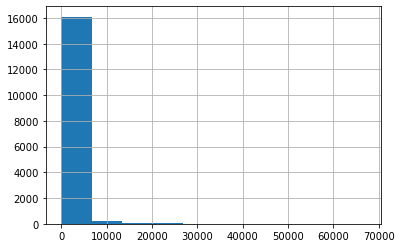

In [1758]:
# 셀러별 월 매출 분포 확인
item_order_month['revenue'].hist()

array([[<AxesSubplot:title={'center':'order_id'}>,
        <AxesSubplot:title={'center':'revenue'}>]], dtype=object)

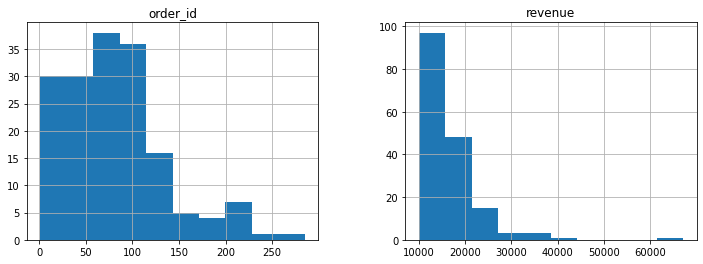

In [1759]:
# 셀러별 월 매출이 10000 이상인 경우 월 주문건수, 매출 확인
item_order_month[item_order_month['revenue']>10000].hist(figsize = (12,4))

In [1760]:
# reset_index 적용
item_order_month = item_order_month.reset_index()
item_order_month

seller_id purchase_month  order_id  revenue
0      0015a82c2db000af6aaaf3ae2ecb0532  2017-09        1         916.02 
1      0015a82c2db000af6aaaf3ae2ecb0532  2017-10        2         1832.04
2      001cca7ae9ae17fb1caed9dfb1094831  2017-02        5         1295.40
3      001cca7ae9ae17fb1caed9dfb1094831  2017-03        11        2124.00
4      001cca7ae9ae17fb1caed9dfb1094831  2017-04        14        2243.22
...                                 ...      ...        ..            ...
16436  fffd5413c0700ac820c7069d66d98c89  2018-08        4         624.33 
16437  ffff564a4f9085cd26170f4732393726  2016-10        2         146.97 
16438  ffff564a4f9085cd26170f4732393726  2017-01        6         327.38 
16439  ffff564a4f9085cd26170f4732393726  2017-03        11        1173.24
16440  ffff564a4f9085cd26170f4732393726  2017-04        1         123.27 

[16441 rows x 4 columns]

### 월별 주문수, 매출 기준 셀러 데이터 확인

In [1761]:
by_order_id = item_order_month.sort_values(by = 'order_id', ascending = False)
by_order_id = by_order_id.reset_index(drop = True)
by_order_id

seller_id purchase_month  order_id   revenue
0      1f50f920176fa81dab994f9023523100  2017-11        285       25534.97
1      955fee9216a65b617aa5c0531780ce60  2018-01        230       21668.92
2      7d13fca15225358621be4086e1eb0964  2018-05        207       33484.81
3      955fee9216a65b617aa5c0531780ce60  2018-04        206       25657.73
4      6560211a19b47992c3666cc44a7e94c0  2018-07        205       16772.21
...                                 ...      ...        ...            ...
16436  7bb8fac2913a6064ec412e583c6d8b4d  2018-02        1         125.52  
16437  7bac63f6603d382cc8d0832eb6c100a8  2018-08        1         599.26  
16438  7bac63f6603d382cc8d0832eb6c100a8  2018-01        1         418.04  
16439  7bac63f6603d382cc8d0832eb6c100a8  2017-12        1         43.33   
16440  ffff564a4f9085cd26170f4732393726  2017-04        1         123.27  

[16441 rows x 4 columns]

<AxesSubplot:>

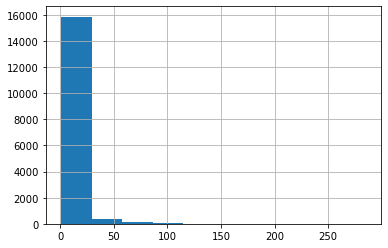

In [1762]:
by_order_id['order_id'].hist()

In [1763]:
by_revenue = item_order_month.sort_values(by = 'revenue', ascending = False)
by_revenue = by_revenue.reset_index(drop = True)
by_revenue

seller_id purchase_month  order_id   revenue
0      53243585a1d6dc2643021fd1853d8905  2017-09        83        67113.00
1      53243585a1d6dc2643021fd1853d8905  2017-10        49        43332.35
2      53243585a1d6dc2643021fd1853d8905  2017-08        34        35787.67
3      7d13fca15225358621be4086e1eb0964  2018-05        207       33484.81
4      7c67e1448b00f6e969d365cea6b010ab  2018-03        146       33165.34
...                                 ...      ...        ...            ...
16436  9cea4682e16655f7da87f406902e989e  2017-06        1         12.89   
16437  cf6f6bc4df3999b9c6440f124fb2f687  2017-05        1         12.22   
16438  94b9108d4b637ba65bb4f1e53cfcf8d8  2017-09        1         11.63   
16439  94b9108d4b637ba65bb4f1e53cfcf8d8  2017-10        1         11.63   
16440  0e44d110fa6a54e121cb2c095a77762f  2017-09        1         10.07   

[16441 rows x 4 columns]

<AxesSubplot:>

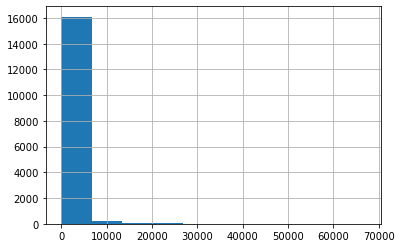

In [1764]:
by_revenue['revenue'].hist()

## product_category

### ★product, name, category 데이터셋 합치기

In [1765]:
# product_category_name 컬럼의 포르투갈어를 영어와 매칭하기 위해 product, name 데이터셋 합치기 
prod = product.merge(name, how = 'outer', on = 'product_category_name')
prod.head()

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5  perfumaria             
1  6a2fb4dd53d2cdb88e0432f1284a004c  perfumaria             
2  0d009643171aee696f4733340bc2fdd0  perfumaria             
3  b1eae565a61935e0011ee7682fef9dc9  perfumaria             
4  8da90b37f0fb171b4877c124f965b1f6  perfumaria             

   product_name_lenght  product_description_lenght  product_photos_qty  \
0  40.0                 287.0                       1.0                  
1  39.0                 346.0                       2.0                  
2  52.0                 150.0                       1.0                  
3  49.0                 460.0                       2.0                  
4  56.0                 733.0                       3.0                  

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0  225.0             16.0               10.0               14.0               
1  400.0             27.0               5.0                20.0               
2  422.0             21.0               16.0               18.0               
3  267.0             17.0               13.0               17.0               
4  377.0             18.0               13.0               15.0               

  product_category_name_english  
0  perfumery                     
1  perfumery                     
2  perfumery                     
3  perfumery                     
4  perfumery

In [1766]:
# product_category_name_english에 product_category_name에 있는 단어 2개가 빠져있음을 확인
prod.describe(include = 'O')

product_id product_category_name  \
count   32951                             32341                  
unique  32951                             73                     
top     8ae935cab2de3f74f4960de6ee604f90  cama_mesa_banho        
freq    1                                 3029                   

       product_category_name_english  
count   32328                         
unique  71                            
top     bed_bath_table                
freq    3029

In [1767]:
# 영문상품명 데이터에 'food_drink','food', 'drinks' 등 겹치는 카테고리가 있음을 확인
prod['product_category_name_english'].unique()

array(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories',
       'health_beauty', 'luggage_accessories', 'garden_tools',
       'office_furniture', 'auto', 'electronics', 'fashion_shoes',
       'telephony', 'stationery', 'fashion_bags_accessories', 'computers',
       'home_construction', 'watches_gifts',
       'construction_tools_construction', 'pet_shop', 'small_appliances',
       'agro_industry_and_commerce', nan, 'furniture_living_room',
       'signaling_and_security', 'air_conditioning', 'consoles_games',
       'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical',
       'hom

In [1768]:
# 재분류한 영문상품명 데이터가 저장된 category 파일 불러와 prod와 합치기
category = pd.read_csv('categorizing.csv', names = ['product_category_name_english', 'new_category'])
prod_rename = prod.merge(category, on = 'product_category_name_english', how = 'outer')
prod_rename.head()

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5  perfumaria             
1  6a2fb4dd53d2cdb88e0432f1284a004c  perfumaria             
2  0d009643171aee696f4733340bc2fdd0  perfumaria             
3  b1eae565a61935e0011ee7682fef9dc9  perfumaria             
4  8da90b37f0fb171b4877c124f965b1f6  perfumaria             

   product_name_lenght  product_description_lenght  product_photos_qty  \
0  40.0                 287.0                       1.0                  
1  39.0                 346.0                       2.0                  
2  52.0                 150.0                       1.0                  
3  49.0                 460.0                       2.0                  
4  56.0                 733.0                       3.0                  

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0  225.0             16.0               10.0               14.0               
1  400.0             27.0               5.0                20.0               
2  422.0             21.0               16.0               18.0               
3  267.0             17.0               13.0               17.0               
4  377.0             18.0               13.0               15.0               

  product_category_name_english new_category  
0  perfumery                     beauty       
1  perfumery                     beauty       
2  perfumery                     beauty       
3  perfumery                     beauty       
4  perfumery                     beauty

###  ★product_category_english_name 없는 데이터 처리

In [1769]:
# 포르투갈어, 영문명 상품정보가 모두 없는 데이터는 제거
prod_rename = prod_rename[~prod_rename['product_category_name'].isnull()]
prod_rename

product_id      product_category_name  \
0      1e9e8ef04dbcff4541ed26657ea517e5  perfumaria                  
1      6a2fb4dd53d2cdb88e0432f1284a004c  perfumaria                  
2      0d009643171aee696f4733340bc2fdd0  perfumaria                  
3      b1eae565a61935e0011ee7682fef9dc9  perfumaria                  
4      8da90b37f0fb171b4877c124f965b1f6  perfumaria                  
...                                 ...         ...                  
32946  13b25797ad1e6d6c7cd3cbeb35f8ee7a  moveis_colchao_e_estofado   
32947  dc36a7859b743d8610a2bbbaea26ece9  moveis_colchao_e_estofado   
32948  107fde0930956120d1e13dd1062fbb46  moveis_colchao_e_estofado   
32949  726b4e18f00255e2e63491bcba3f60b8  moveis_colchao_e_estofado   
32950  1dceebcc5f23c02ea23e16d5bedca000  cds_dvds_musicais           

       product_name_lenght  product_description_lenght  product_photos_qty  \
0      40.0                 287.0                       1.0                  
1      39.0                 346.0                       2.0                  
2      52.0                 150.0                       1.0                  
3      49.0                 460.0                       2.0                  
4      56.0                 733.0                       3.0                  
...     ...                   ...                       ...                  
32946  44.0                 348.0                       1.0                  
32947  29.0                 2073.0                      2.0                  
32948  51.0                 418.0                       1.0                  
32949  41.0                 866.0                       1.0                  
32950  47.0                 117.0                       2.0                  

       product_weight_g  product_length_cm  product_height_cm  \
0      225.0             16.0               10.0                
1      400.0             27.0               5.0                 
2      422.0             21.0               16.0                
3      267.0             17.0               13.0                
4      377.0             18.0               13.0                
...      ...              ...                ...                
32946  18250.0           25.0               25.0                
32947  2500.0            41.0               21.0                
32948  30000.0           60.0               73.0                
32949  1700.0            70.0               10.0                
32950  550.0             35.0               15.0                

       product_width_cm      product_category_name_english new_category  
0      14.0              perfumery                          beauty       
1      20.0              perfumery                          beauty       
2      18.0              perfumery                          beauty       
3      17.0              perfumery                          beauty       
4      15.0              perfumery                          beauty       
...     ...                    ...                             ...       
32946  25.0              furniture_mattress_and_upholstery  furniture    
32947  21.0              furniture_mattress_and_upholstery  furniture    
32948  60.0              furniture_mattress_and_upholstery  furniture    
32949  100.0             furniture_mattress_and_upholstery  furniture    
32950  25.0              cds_dvds_musicals                  culture      

[32341 rows x 11 columns]

In [1770]:
# 상품명 정보가 포르투갈어로만 존재하는 데이터 확인
prod_rename.loc[prod_rename['new_category'].isnull(), 'product_category_name']

30214    pc_gamer                                     
30215    pc_gamer                                     
30216    pc_gamer                                     
30217    portateis_cozinha_e_preparadores_de_alimentos
30218    portateis_cozinha_e_preparadores_de_alimentos
30219    portateis_cozinha_e_preparadores_de_alimentos
30220    portateis_cozinha_e_preparadores_de_alimentos
30221    portateis_cozinha_e_preparadores_de_alimentos
30222    portateis_cozinha_e_preparadores_de_alimentos
30223    portateis_cozinha_e_preparadores_de_alimentos
30224    portateis_cozinha_e_preparadores_de_alimentos
30225    portateis_cozinha_e_preparadores_de_alimentos
30226    portateis_cozinha_e_preparadores_de_alimentos
Name: product_category_name, dtype: object

In [1771]:
# 재분류한 영문상품명 중 해당하는 카테고리명 할당
prod_rename.loc[(prod_rename['new_category'].isnull()) & (prod_rename['product_category_name'] == 'pc_gamer'),
           'new_category'] = 'games'
prod_rename.loc[(prod_rename['new_category'].isnull()) & (prod_rename['product_category_name'] == 'portateis_cozinha_e_preparadores_de_alimentos'),
           'new_category'] = 'home_living'

### ★prod_rename, item 데이터셋 합치기

In [1772]:
prod_order = prod_rename.merge(item, how = 'outer', on = 'product_id')
prod_order.head()

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5  perfumaria             
1  6a2fb4dd53d2cdb88e0432f1284a004c  perfumaria             
2  6a2fb4dd53d2cdb88e0432f1284a004c  perfumaria             
3  0d009643171aee696f4733340bc2fdd0  perfumaria             
4  0d009643171aee696f4733340bc2fdd0  perfumaria             

   product_name_lenght  product_description_lenght  product_photos_qty  \
0  40.0                 287.0                       1.0                  
1  39.0                 346.0                       2.0                  
2  39.0                 346.0                       2.0                  
3  52.0                 150.0                       1.0                  
4  52.0                 150.0                       1.0                  

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0  225.0             16.0               10.0               14.0               
1  400.0             27.0               5.0                20.0               
2  400.0             27.0               5.0                20.0               
3  422.0             21.0               16.0               18.0               
4  422.0             21.0               16.0               18.0               

  product_category_name_english new_category  \
0  perfumery                     beauty        
1  perfumery                     beauty        
2  perfumery                     beauty        
3  perfumery                     beauty        
4  perfumery                     beauty        

                           order_id                         seller_id  \
0  e17e4f88e31525f7deef66779844ddce  5670f4db5b62c43d542e1b2d56b0cf7c   
1  048cc42e03ca8d43c729adf6962cb348  7040e82f899a04d1b434b795a43b4617   
2  5fa78e91b5cb84b6a8ccc42733f95742  7040e82f899a04d1b434b795a43b4617   
3  24b1c4d88fdb7a2dc87f8ecc7d8f47f1  fe2032dab1a61af8794248c8196565c9   
4  7b13c77c64a9a956500cbf1a9a23798d  7178f9f4dd81dcef02f62acdf8151e01   

   shipping_limit_date   price  freight_value  num  revenue  
0  2018-04-30 17:33:54  10.91   7.39           1    18.30    
1  2017-11-23 21:31:31  16.90   7.78           1    24.68    
2  2017-12-14 16:33:14  16.90   7.78           1    24.68    
3  2017-08-03 09:50:14  339.00  17.13          1    356.13   
4  2018-05-30 10:38:35  275.00  23.48          1    298.48

In [1773]:
prod_order.describe(include = 'O')

product_id product_category_name  \
count   102425                            100965                 
unique  32951                             73                     
top     99a4788cb24856965c36a24e339b6058  cama_mesa_banho        
freq    467                               10160                  

       product_category_name_english new_category  \
count   100943                        100965        
unique  71                            21            
top     bed_bath_table                stationery    
freq    10160                         17037         

                                order_id                         seller_id  \
count   102425                            102425                             
unique  98666                             3095                               
top     ca3625898fbd48669d50701aba51cd5f  6560211a19b47992c3666cc44a7e94c0   
freq    8                                 1982                               

        shipping_limit_date  
count   102425               
unique  93318                
top     2018-05-20 22:50:11  
freq    7

In [1774]:
prod_order.isnull().sum()

product_id                       0   
product_category_name            1460
product_name_lenght              1460
product_description_lenght       1460
product_photos_qty               1460
product_weight_g                 1461
product_length_cm                1461
product_height_cm                1461
product_width_cm                 1461
product_category_name_english    1482
new_category                     1460
order_id                         0   
seller_id                        0   
shipping_limit_date              0   
price                            0   
freight_value                    0   
num                              0   
revenue                          0   
dtype: int64

In [1775]:
# 포르투갈어, 영문명 상품정보가 모두 없는 데이터 제외
prod_order = prod_order[~prod_order['product_category_name'].isnull()]
prod_order

product_id product_category_name  \
0       1e9e8ef04dbcff4541ed26657ea517e5  perfumaria             
1       6a2fb4dd53d2cdb88e0432f1284a004c  perfumaria             
2       6a2fb4dd53d2cdb88e0432f1284a004c  perfumaria             
3       0d009643171aee696f4733340bc2fdd0  perfumaria             
4       0d009643171aee696f4733340bc2fdd0  perfumaria             
...                                  ...         ...             
100960  1dceebcc5f23c02ea23e16d5bedca000  cds_dvds_musicais      
100961  1dceebcc5f23c02ea23e16d5bedca000  cds_dvds_musicais      
100962  1dceebcc5f23c02ea23e16d5bedca000  cds_dvds_musicais      
100963  1dceebcc5f23c02ea23e16d5bedca000  cds_dvds_musicais      
100964  1dceebcc5f23c02ea23e16d5bedca000  cds_dvds_musicais      

        product_name_lenght  product_description_lenght  product_photos_qty  \
0       40.0                 287.0                       1.0                  
1       39.0                 346.0                       2.0                  
2       39.0                 346.0                       2.0                  
3       52.0                 150.0                       1.0                  
4       52.0                 150.0                       1.0                  
...      ...                   ...                       ...                  
100960  47.0                 117.0                       2.0                  
100961  47.0                 117.0                       2.0                  
100962  47.0                 117.0                       2.0                  
100963  47.0                 117.0                       2.0                  
100964  47.0                 117.0                       2.0                  

        product_weight_g  product_length_cm  product_height_cm  \
0       225.0             16.0               10.0                
1       400.0             27.0               5.0                 
2       400.0             27.0               5.0                 
3       422.0             21.0               16.0                
4       422.0             21.0               16.0                
...       ...              ...                ...                
100960  550.0             35.0               15.0                
100961  550.0             35.0               15.0                
100962  550.0             35.0               15.0                
100963  550.0             35.0               15.0                
100964  550.0             35.0               15.0                

        product_width_cm product_category_name_english new_category  \
0       14.0              perfumery                     beauty        
1       20.0              perfumery                     beauty        
2       20.0              perfumery                     beauty        
3       18.0              perfumery                     beauty        
4       18.0              perfumery                     beauty        
...      ...                    ...                        ...        
100960  25.0              cds_dvds_musicals             culture       
100961  25.0              cds_dvds_musicals             culture       
100962  25.0              cds_dvds_musicals             culture       
100963  25.0              cds_dvds_musicals             culture       
100964  25.0              cds_dvds_musicals             culture       

                                order_id                         seller_id  \
0       e17e4f88e31525f7deef66779844ddce  5670f4db5b62c43d542e1b2d56b0cf7c   
1       048cc42e03ca8d43c729adf6962cb348  7040e82f899a04d1b434b795a43b4617   
2       5fa78e91b5cb84b6a8ccc42733f95742  7040e82f899a04d1b434b795a43b4617   
3       24b1c4d88fdb7a2dc87f8ecc7d8f47f1  fe2032dab1a61af8794248c8196565c9   
4       7b13c77c64a9a956500cbf1a9a23798d  7178f9f4dd81dcef02f62acdf8151e01   
...                                  ...                               ...   
100960  7ed69fbc79fbda50e09caa9c127026e5  4e922959ae960d389249c378d1c939f5   
100961  9c782cb785

In [1776]:
# 전체 판매제품 중 가장 많이 팔린 카테고리 제품 보기
prod_order_sorted = prod_order.groupby('new_category')['product_category_name'].agg('count').sort_values(ascending = False)
popular_prod = prod_order_sorted.head(30).to_frame()
popular_prod

product_category_name
new_category                          
stationery       17037                
beauty           12264                
home_living      10879                
electronics      10316                
furniture        8647                 
sports           7858                 
home_appliances  7725                 
telephone        4504                 
auto             3991                 
garden_tools     3819                 
baby             2933                 
fashion          2558                 
construction     1797                 
pet              1772                 
games            1088                 
culture          1040                 
food_drink       1002                 
book             853                  
others           525                  
agro             212                  
security         145

<AxesSubplot:xlabel='new_category', ylabel='product_category_name'>

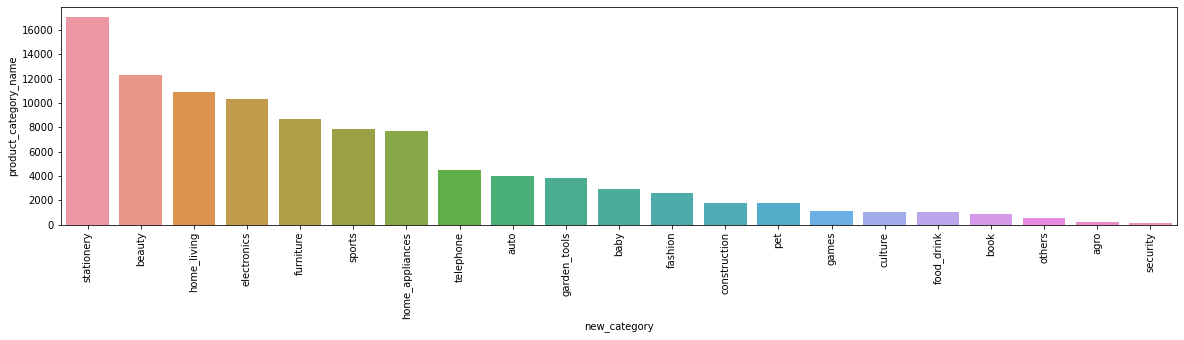

In [1777]:
plt.figure(figsize=(20, 4))
plt.xticks(rotation = 90)

sns.barplot(data = popular_prod, x = popular_prod.index, y = 'product_category_name')

In [1778]:
# 판매건수 기준 Top1 seller 판매제품 카테고리
prod_order[prod_order['seller_id'] == '6560211a19b47992c3666cc44a7e94c0'].groupby(
    'new_category')['product_category_name'].agg('count').sort_values(ascending = False)

new_category
stationery      1585
fashion         336 
electronics     42  
beauty          11  
sports          7   
construction    1   
Name: product_category_name, dtype: int64

In [1779]:
# 판매금액 기준 Top1 seller 판매제품 카테고리
prod_order[prod_order['seller_id'] == '4869f7a5dfa277a7dca6462dcf3b52b2'].groupby(
    'new_category')['product_category_name'].agg('count').sort_values(ascending = False)

new_category
stationery     1043
electronics    68  
beauty         20  
games          7   
telephone      3   
sports         1   
auto           1   
Name: product_category_name, dtype: int64

## review_score

### ★item_order, review 데이터셋 합치기

In [1780]:
# review 데이터 확인
review.head(1)

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   

   review_score review_comment_title review_comment_message  \
0  4             NaN                  NaN                     

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00  2018-01-18 21:46:59

In [1781]:
review.describe(include = 'O')

review_id                          order_id  \
count   100000                            100000                             
unique  99173                             99441                              
top     9e25d6e3025e9b9a0fc7f03588d33e2b  8e17072ec97ce29f0e1f111e598b0c85   
freq    3                                 3                                  

       review_comment_title review_comment_message review_creation_date  \
count   11715                41753                  100000                
unique  4600                 36921                  637                   
top     Recomendo            Muito bom              2017-12-19 00:00:00   
freq    426                  230                    466                   

       review_answer_timestamp  
count   100000                  
unique  99010                   
top     2017-06-15 23:21:05     
freq    4

In [1782]:
# item_order와 review 데이터셋 합치기
item_order_review = item_order.merge(review, how = 'outer', on = 'order_id')
item_order_review.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id  shipping_limit_date   price  \
0  48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.90    
1  dd7ddc04e1b6c2c614352b383efe2d36  2017-05-03 11:05:13  239.90   
2  5b51032eddd242adc84c38acab88f23d  2018-01-18 14:48:30  199.00   
3  9d7a1d34a5052409006425275ba1c2b4  2018-08-15 10:10:18  12.99    
4  df560393f3a51e74553ab94004ba5c87  2017-02-13 13:57:51  199.90   

   freight_value  num  revenue                       customer_id order_status  \
0  13.29          1.0  72.19    3ce436f183e68e07877b285a838db11a  delivered     
1  19.93          1.0  259.83   f6dd3ec061db4e3987629fe6b26e5cce  delivered     
2  17.87          1.0  216.87   6489ae5e4333f3693df5ad4372dab6d3  delivered     
3  12.79          1.0  25.78    d4eb9395c8c0431ee92fce09860c5a06  delivered     
4  18.14          1.0  218.04   58dbd0b2d70206bf40e62cd34e84d795  delivered     

  order_purchase_timestamp    order_approved_at order_delivered_carrier_date  \
0  2017-09-13 08:59:02      2017-09-13 09:45:35  2017-09-19 18:34:16           
1  2017-04-26 10:53:06      2017-04-26 11:05:13  2017-05-04 14:35:00           
2  2018-01-14 14:33:31      2018-01-14 14:48:30  2018-01-16 12:36:48           
3  2018-08-08 10:00:35      2018-08-08 10:10:18  2018-08-10 13:28:00           
4  2017-02-04 13:57:51      2017-02-04 14:10:13  2017-02-16 09:46:09           

  order_delivered_customer_date order_estimated_delivery_date purchase_month  \
0  2017-09-20 23:43:48           2017-09-29 00:00:00           2017-09         
1  2017-05-12 16:04:24           2017-05-15 00:00:00           2017-04         
2  2018-01-22 13:19:16           2018-02-05 00:00:00           2018-01         
3  2018-08-14 13:32:39           2018-08-20 00:00:00           2018-08         
4  2017-03-01 16:42:31           2017-03-17 00:00:00           2017-02         

                          review_id  review_score review_comment_title  \
0  97ca439bc427b48bc1cd7177abe71365  5             NaN                   
1  7b07bacd811c4117b742569b04ce3580  4             NaN                   
2  0c5b33dea94867d1ac402749e5438e8b  5             NaN                   
3  f4028d019cb58564807486a6aaf33817  4             NaN                   
4  940144190dcba6351888cafa43f3a3a5  5             NaN                   

                                                                       review_comment_message  \
0  Perfeito, produto entregue antes do combinado.                                               
1  NaN                                                                                          
2  Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.   
3  NaN                                                                                          
4  Gostei pois veio no prazo determinado .                                                      

  review_creation_date review_answer_timestamp  
0  2017-09-21 00:00:00  2017-09-22 10:57:03     
1  2017-05-13 00:00:00  2017-05-15 11:34:13     
2  2018-01-23 00:00:00  2018-01-23 16:06:31     
3  2018-08-15 00:00:00  2018-08-15 16:39:01     
4  2017-03-02 00:00:00  2017-03-03 10:54:59

In [1783]:
item_order_review.describe()

price  freight_value            num        revenue  \
count  103035.000000  103035.000000  103035.000000  103035.000000   
mean   124.236486     20.100675      1.099840       154.484573      
std    188.564473     15.861700      0.456909       214.092278      
min    0.850000       0.000000       1.000000       7.280000        
25%    40.000000      13.140000      1.000000       59.920000       
50%    78.000000      16.320000      1.000000       101.340000      
75%    139.000000     21.200000      1.000000       169.985000      
max    6735.000000    409.680000     20.000000      13664.080000    

        review_score  
count  103813.000000  
mean   4.043232       
std    1.380441       
min    1.000000       
25%    4.000000       
50%    5.000000       
75%    5.000000       
max    5.000000

In [1784]:
item_order_review.describe(include = 'O')

order_id                        product_id  \
count   103813                            103035                             
unique  99441                             32951                              
top     5a3b1c29a49756e75f1ef513383c0c12  99a4788cb24856965c36a24e339b6058   
freq    12                                470                                

                               seller_id  shipping_limit_date  \
count   103035                            103035                
unique  3095                              93318                 
top     6560211a19b47992c3666cc44a7e94c0  2017-10-24 13:06:21   
freq    1988                              12                    

                             customer_id order_status  \
count   103035                            103035        
unique  98666                             7             
top     be1c4e52bb71e0c54b11a26b8e8d59f2  delivered     
freq    12                                100785        

       order_purchase_timestamp    order_approved_at  \
count   103035                   103021                
unique  98112                    90174                 
top     2017-10-17 13:06:29      2017-10-18 13:06:21   
freq    12                       12                    

       order_delivered_carrier_date order_delivered_customer_date  \
count   101998                       100784                         
unique  81017                        95664                          
top     2018-05-09 15:48:00          2017-10-22 14:43:54            
freq    47                           12                             

       order_estimated_delivery_date purchase_month  \
count   103035                        103035          
unique  450                           24              
top     2017-12-20 00:00:00           2017-11         
freq    547                           7841            

                               review_id review_comment_title  \
count   103813                            12304                 
unique  99173                             4600                  
top     b8017a9ca639f71a9a4a745985f4a729  Recomendo             
freq    8                                 439                   

       review_comment_message review_creation_date review_answer_timestamp  
count   43905                  103813               103813                  
unique  36921                  637                  99010                   
top     Muito bom              2017-12-19 00:00:00  2018-08-24 17:07:04     
freq    236                    478                  8

### ★seller_id 없는 데이터 제거

In [1785]:
item_order_review.isnull().sum()

order_id                         0    
product_id                       778  
seller_id                        778  
shipping_limit_date              778  
price                            778  
freight_value                    778  
num                              778  
revenue                          778  
customer_id                      778  
order_status                     778  
order_purchase_timestamp         778  
order_approved_at                792  
order_delivered_carrier_date     1815 
order_delivered_customer_date    3029 
order_estimated_delivery_date    778  
purchase_month                   778  
review_id                        0    
review_score                     0    
review_comment_title             91509
review_comment_message           59908
review_creation_date             0    
review_answer_timestamp          0    
dtype: int64

In [1786]:
# item 데이터셋에는 없고 order, review 데이터셋에만 정보가 있는 아래 데이터를 살펴보면
# order_status가 delivered가 아닌 경우의 데이터가 order, review에 추가로 포함된 경우가 있는 것으로 파악됨
item[item['order_id']=='f62f01ec64c6b221f926ba560907d8f7']

Empty DataFrame
Columns: [order_id, product_id, seller_id, shipping_limit_date, price, freight_value, num, revenue]
Index: []

In [1787]:
order[order['order_id']=='f62f01ec64c6b221f926ba560907d8f7']

order_id                       customer_id  \
64186  f62f01ec64c6b221f926ba560907d8f7  a35ef57cd99a99e77e58316ab0cc2927   

      order_status order_purchase_timestamp    order_approved_at  \
64186  unavailable  2017-02-14 20:55:49      2017-02-14 21:05:27   

      order_delivered_carrier_date order_delivered_customer_date  \
64186  NaN                          NaN                            

      order_estimated_delivery_date  
64186  2017-04-03 00:00:00

In [1788]:
# 해당 건들은 item 데이터셋에 정보가 없어 seller_id, price, freight_value 등 주요 정보가 확인되지 않으므로 분석에서 제외
item_order_review = item_order_review[~item_order_review['seller_id'].isnull()]
item_order_review.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id  shipping_limit_date   price  \
0  48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.90    
1  dd7ddc04e1b6c2c614352b383efe2d36  2017-05-03 11:05:13  239.90   
2  5b51032eddd242adc84c38acab88f23d  2018-01-18 14:48:30  199.00   
3  9d7a1d34a5052409006425275ba1c2b4  2018-08-15 10:10:18  12.99    
4  df560393f3a51e74553ab94004ba5c87  2017-02-13 13:57:51  199.90   

   freight_value  num  revenue                       customer_id order_status  \
0  13.29          1.0  72.19    3ce436f183e68e07877b285a838db11a  delivered     
1  19.93          1.0  259.83   f6dd3ec061db4e3987629fe6b26e5cce  delivered     
2  17.87          1.0  216.87   6489ae5e4333f3693df5ad4372dab6d3  delivered     
3  12.79          1.0  25.78    d4eb9395c8c0431ee92fce09860c5a06  delivered     
4  18.14          1.0  218.04   58dbd0b2d70206bf40e62cd34e84d795  delivered     

  order_purchase_timestamp    order_approved_at order_delivered_carrier_date  \
0  2017-09-13 08:59:02      2017-09-13 09:45:35  2017-09-19 18:34:16           
1  2017-04-26 10:53:06      2017-04-26 11:05:13  2017-05-04 14:35:00           
2  2018-01-14 14:33:31      2018-01-14 14:48:30  2018-01-16 12:36:48           
3  2018-08-08 10:00:35      2018-08-08 10:10:18  2018-08-10 13:28:00           
4  2017-02-04 13:57:51      2017-02-04 14:10:13  2017-02-16 09:46:09           

  order_delivered_customer_date order_estimated_delivery_date purchase_month  \
0  2017-09-20 23:43:48           2017-09-29 00:00:00           2017-09         
1  2017-05-12 16:04:24           2017-05-15 00:00:00           2017-04         
2  2018-01-22 13:19:16           2018-02-05 00:00:00           2018-01         
3  2018-08-14 13:32:39           2018-08-20 00:00:00           2018-08         
4  2017-03-01 16:42:31           2017-03-17 00:00:00           2017-02         

                          review_id  review_score review_comment_title  \
0  97ca439bc427b48bc1cd7177abe71365  5             NaN                   
1  7b07bacd811c4117b742569b04ce3580  4             NaN                   
2  0c5b33dea94867d1ac402749e5438e8b  5             NaN                   
3  f4028d019cb58564807486a6aaf33817  4             NaN                   
4  940144190dcba6351888cafa43f3a3a5  5             NaN                   

                                                                       review_comment_message  \
0  Perfeito, produto entregue antes do combinado.                                               
1  NaN                                                                                          
2  Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.   
3  NaN                                                                                          
4  Gostei pois veio no prazo determinado .                                                      

  review_creation_date review_answer_timestamp  
0  2017-09-21 00:00:00  2017-09-22 10:57:03     
1  2017-05-13 00:00:00  2017-05-15 11:34:13     
2  2018-01-23 00:00:00  2018-01-23 16:06:31     
3  2018-08-15 00:00:00  2018-08-15 16:39:01     
4  2017-03-02 00:00:00  2017-03-03 10:54:59

In [1789]:
item_order_review.describe(include = 'O')

order_id                        product_id  \
count   103035                            103035                             
unique  98666                             32951                              
top     5a3b1c29a49756e75f1ef513383c0c12  99a4788cb24856965c36a24e339b6058   
freq    12                                470                                

                               seller_id  shipping_limit_date  \
count   103035                            103035                
unique  3095                              93318                 
top     6560211a19b47992c3666cc44a7e94c0  2017-10-24 13:06:21   
freq    1988                              12                    

                             customer_id order_status  \
count   103035                            103035        
unique  98666                             7             
top     be1c4e52bb71e0c54b11a26b8e8d59f2  delivered     
freq    12                                100785        

       order_purchase_timestamp    order_approved_at  \
count   103035                   103021                
unique  98112                    90174                 
top     2017-10-17 13:06:29      2017-10-18 13:06:21   
freq    12                       12                    

       order_delivered_carrier_date order_delivered_customer_date  \
count   101998                       100784                         
unique  81017                        95664                          
top     2018-05-09 15:48:00          2017-10-22 14:43:54            
freq    47                           12                             

       order_estimated_delivery_date purchase_month  \
count   103035                        103035          
unique  450                           24              
top     2017-12-20 00:00:00           2017-11         
freq    547                           7841            

                               review_id review_comment_title  \
count   103035                            12212                 
unique  98453                             4569                  
top     b8017a9ca639f71a9a4a745985f4a729  Recomendo             
freq    8                                 439                   

       review_comment_message review_creation_date review_answer_timestamp  
count   43362                  103035               103035                  
unique  36435                  634                  98291                   
top     Muito bom              2017-12-19 00:00:00  2018-08-24 17:07:04     
freq    236                    473                  8

In [1790]:
item_order_review.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
shipping_limit_date              0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
customer_id                      0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                14   
order_delivered_carrier_date     1037 
order_delivered_customer_date    2251 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             90823
review_comment_message           59673
review_creation_date             0    
review_answer_timestamp          0    
dtype: int64

### ★item_order_review, prod_order 합치기

In [1791]:
item_order_review.head(1)

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   

                          seller_id  shipping_limit_date  price  \
0  48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.9    

   freight_value  num  revenue                       customer_id order_status  \
0  13.29          1.0  72.19    3ce436f183e68e07877b285a838db11a  delivered     

  order_purchase_timestamp    order_approved_at order_delivered_carrier_date  \
0  2017-09-13 08:59:02      2017-09-13 09:45:35  2017-09-19 18:34:16           

  order_delivered_customer_date order_estimated_delivery_date purchase_month  \
0  2017-09-20 23:43:48           2017-09-29 00:00:00           2017-09         

                          review_id  review_score review_comment_title  \
0  97ca439bc427b48bc1cd7177abe71365  5             NaN                   

                           review_comment_message review_creation_date  \
0  Perfeito, produto entregue antes do combinado.  2017-09-21 00:00:00   

  review_answer_timestamp  
0  2017-09-22 10:57:03

In [1792]:
prod_rename.head(1)

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5  perfumaria             

   product_name_lenght  product_description_lenght  product_photos_qty  \
0  40.0                 287.0                       1.0                  

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0  225.0             16.0               10.0               14.0               

  product_category_name_english new_category  
0  perfumery                     beauty

In [1793]:
df = item_order_review.merge(prod_rename, on = 'product_id', how = 'left')
df

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
103030  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
103031  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
103032  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
103033  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
103034  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  shipping_limit_date   price  \
0       48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.90    
1       dd7ddc04e1b6c2c614352b383efe2d36  2017-05-03 11:05:13  239.90   
2       5b51032eddd242adc84c38acab88f23d  2018-01-18 14:48:30  199.00   
3       9d7a1d34a5052409006425275ba1c2b4  2018-08-15 10:10:18  12.99    
4       df560393f3a51e74553ab94004ba5c87  2017-02-13 13:57:51  199.90   
...                                  ...                  ...     ...   
103030  b8bc237ba3788b23da09c0f1f3a3288c  2018-05-02 04:11:01  299.99   
103031  f3c38ab652836d21de61fb8314b69182  2018-07-20 04:31:48  350.00   
103032  c3cfdc648177fdbbbb35635a37472c53  2017-10-30 17:14:25  99.90    
103033  2b3e4a2a3ea8e01938cabda2a3e5cc79  2017-08-21 00:04:32  55.99    
103034  f7ccf836d21b2fb1de37564105216cc1  2018-06-12 17:10:13  43.00    

        freight_value  num  revenue                       customer_id  \
0       13.29          1.0  72.19    3ce436f183e68e07877b285a838db11a   
1       19.93          1.0  259.83   f6dd3ec061db4e3987629fe6b26e5cce   
2       17.87          1.0  216.87   6489ae5e4333f3693df5ad4372dab6d3   
3       12.79          1.0  25.78    d4eb9395c8c0431ee92fce09860c5a06   
4       18.14          1.0  218.04   58dbd0b2d70206bf40e62cd34e84d795   
...       ...          ...     ...                                ...   
103030  43.41          1.0  343.40   b51593916b4b8e0d6f66f2ae24f2673d   
103031  36.53          1.0  386.53   84c5d4fbaf120aae381fad077416eaa0   
103032  16.95          1.0  116.85   29309aa813182aaddc9b259e31b870e6   
103033  8.72           1.0  64.71    b5e6afd5a41800fdf401e0272ca74655   
103034  12.79          1.0  55.79    96d649da0cc4ff33bb408b199d4c7dcf   

       order_status order_purchase_timestamp    order_approved_at  \
0       delivered    2017-09-13 08:59:02      2017-09-13 09:45:35   
1       delivered    2017-04-26 10:53:06      2017-04-26 11:05:13   
2       delivered    2018-01-14 14:33:31      2018-01-14 14:48:30   
3       delivered    2018-08-08 10:00:35      2018-08-08 10:10:18   
4       delivered    2017-02-04 13:57:51      2017-02-04 14:10:13   
...           ...                    ...                      ...   
103030  delivered    2018-04-23 13:57:06      2018-04-25 04:11:01   
103031  delivered    2018-07-14 10:26:46      2018-07-17 04:31:48   
103032  delivered    2017-10-23 17:07:56      2017-10-24 17:14:25   
103033  delivered    2017-08-14 23:02:59      2017-08-15 00:04:32   
103034  delivered    2018-06-09 17:00:18      2018-06-09 17:10:13   

       order_delivered_carrier_date order_delivered_customer_date  \
0       2017-09-19 18:34:16          2017-09-20 23:43:48            
1       2017-05-04 14:35:00          2017-05-12 16:04:24            
2       2018-01-16 12:36:48          2018-01-22 13:19:16            
3       2018-08-10 13:28:00          2018-08-14 13:32:39            
4       2017-02-16 09:46:09          2017-03-01 16:42:31            
...                     ...                          ...            
103030  2018-04-25 12:09:00  

In [1794]:
# 데이터 통합 과정에서 product_category_name이 null인 데이터 다시 발생
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
shipping_limit_date              0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
customer_id                      0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                14   
order_delivered_carrier_date     1037 
order_delivered_customer_date    2251 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             90823
review_comment_message           59673
review_creation_date             0    
review_answer_timestamp          0    
product_category_name            1469 
product_name_lenght              1469 
product_description_lenght       1469 
product_photos_qty       

In [1795]:
# 해당 데이터 제거
df = df[~df['product_category_name'].isnull()]
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
shipping_limit_date              0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
customer_id                      0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     1003 
order_delivered_customer_date    2191 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             89424
review_comment_message           58850
review_creation_date             0    
review_answer_timestamp          0    
product_category_name            0    
product_name_lenght              0    
product_description_lenght       0    
product_photos_qty       

In [1796]:
# 구매월별 매출건수 확인
df.groupby('purchase_month')['order_id'].count()

purchase_month
2016-09    4   
2016-10    328 
2016-12    1   
2017-01    824 
2017-02    1751
2017-03    2691
2017-04    2409
2017-05    3758
2017-06    3309
2017-07    4120
2017-08    4443
2017-09    4358
2017-10    4748
2017-11    7726
2017-12    5713
2018-01    7379
2018-02    6855
2018-03    7331
2018-04    7169
2018-05    7089
2018-06    6388
2018-07    6471
2018-08    6700
2018-09    1   
Name: order_id, dtype: int64

In [1797]:
# 2016년 9월~12월과 2018년 9월 주문건수는 다른 월에 비해 현저히 낮음
# 서비스 테스트 등 다른 이슈가 있었던 기간이었을 가능성이 있다고 보고 해당 월은 분석에서 제외
df = df[~df['purchase_month'].isin(['2016-09', '2016-10', '2016-12', '2018-09'])]
df.groupby('purchase_month')['order_id'].count()

purchase_month
2017-01    824 
2017-02    1751
2017-03    2691
2017-04    2409
2017-05    3758
2017-06    3309
2017-07    4120
2017-08    4443
2017-09    4358
2017-10    4748
2017-11    7726
2017-12    5713
2018-01    7379
2018-02    6855
2018-03    7331
2018-04    7169
2018-05    7089
2018-06    6388
2018-07    6471
2018-08    6700
Name: order_id, dtype: int64

In [1798]:
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
shipping_limit_date              0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
customer_id                      0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     967  
order_delivered_customer_date    2145 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             89090
review_comment_message           58764
review_creation_date             0    
review_answer_timestamp          0    
product_category_name            0    
product_name_lenght              0    
product_description_lenght       0    
product_photos_qty       

### review_score 분포 확인

<AxesSubplot:>

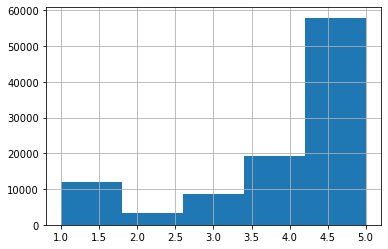

In [1799]:
# 전체 review_score
df['review_score'].hist(bins = 5)

In [1800]:
# 월별 review_score 평균
df_month = df.groupby('purchase_month')['review_score'].agg('mean').reset_index()
df_month

purchase_month  review_score
0   2017-01        4.080097    
1   2017-02        4.055397    
2   2017-03        4.083984    
3   2017-04        4.026982    
4   2017-05        4.141565    
5   2017-06        4.135388    
6   2017-07        4.160680    
7   2017-08        4.229124    
8   2017-09        4.171409    
9   2017-10        4.093513    
10  2017-11        3.889852    
11  2017-12        4.003851    
12  2018-01        4.007318    
13  2018-02        3.796499    
14  2018-03        3.709453    
15  2018-04        4.109081    
16  2018-05        4.161941    
17  2018-06        4.247026    
18  2018-07        4.238758    
19  2018-08        4.225672

<AxesSubplot:xlabel='purchase_month', ylabel='review_score'>

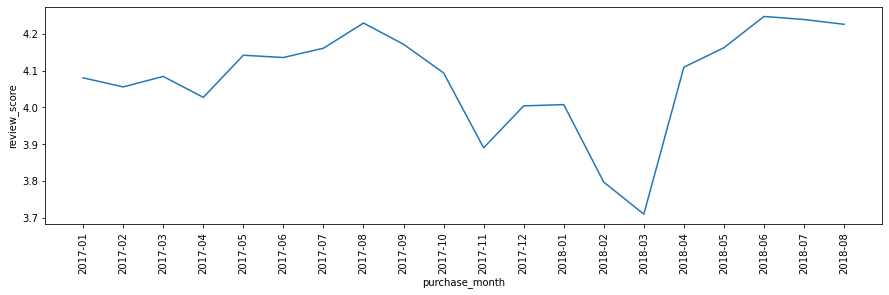

In [1801]:
plt.figure(figsize = (15, 4))
plt.xticks(rotation = 90)
sns.lineplot(data = df_month, x = 'purchase_month', y = 'review_score')

In [1802]:
# 제품 카테고리별 review_score 평균
df_category = df.groupby('new_category')['review_score'].agg('mean').sort_values(ascending = False).reset_index()
df_category

new_category  review_score
0   book             4.410317    
1   food_drink       4.246276    
2   pet              4.192090    
3   beauty           4.166884    
4   sports           4.141591    
5   culture          4.131478    
6   stationery       4.131200    
7   home_appliances  4.119219    
8   garden_tools     4.111285    
9   fashion          4.103073    
10  others           4.085437    
11  auto             4.067483    
12  agro             4.061321    
13  security         4.048276    
14  games            4.032437    
15  construction     4.024431    
16  baby             4.016393    
17  electronics      4.008698    
18  telephone        3.968854    
19  furniture        3.914808    
20  home_living      3.891300

<AxesSubplot:xlabel='new_category', ylabel='review_score'>

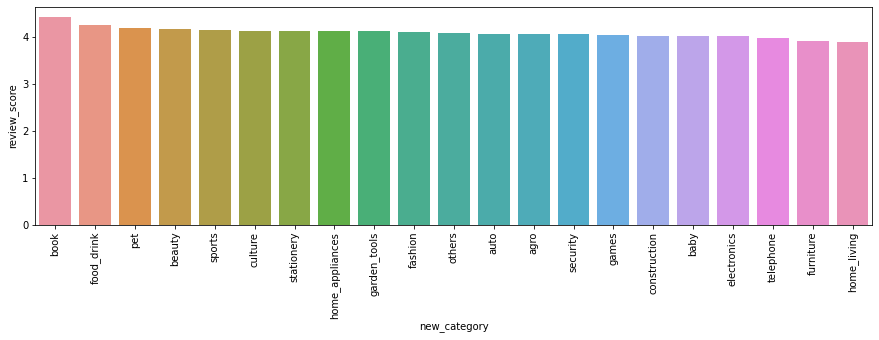

In [1803]:
plt.figure(figsize = (15, 4))
plt.xticks(rotation = 90)
sns.barplot(data = df_category, x = 'new_category', y = 'review_score')

In [1804]:
# 셀러별 review_score 평균
df_random_seller = df.groupby('seller_id')['review_score'].agg('mean').sort_values(ascending = False).reset_index().sample(20)
df_random_index = df_random_seller['seller_id'].tolist()

In [1805]:
# 셀러 20명을 랜덤 추출하여 review_score 분포 확인
df_random = df.loc[df['seller_id'].isin(df_random_index), ['seller_id', 'review_score']].reset_index()
df_random

index                         seller_id  review_score
0    801     3078096983cf766a32a06257648502d1  5           
1    1029    54219883e72aad869adfb2a54b7bfa0f  1           
2    1328    3078096983cf766a32a06257648502d1  1           
3    1446    3078096983cf766a32a06257648502d1  5           
4    1827    d03698c2efd04a549382afa6623e27fb  5           
..    ...                                 ... ..           
205  100639  dfc475d54e1b6dbeeb7d7d9bdaa63827  5           
206  100869  dfc475d54e1b6dbeeb7d7d9bdaa63827  1           
207  101952  d06d019f72a04e5497a0b64190af170c  5           
208  102466  655220df33262c7e0c4949a147366f94  5           
209  103013  777a0c55737f34ffeb78010f7542ab41  2           

[210 rows x 3 columns]

<AxesSubplot:xlabel='seller_id', ylabel='review_score'>

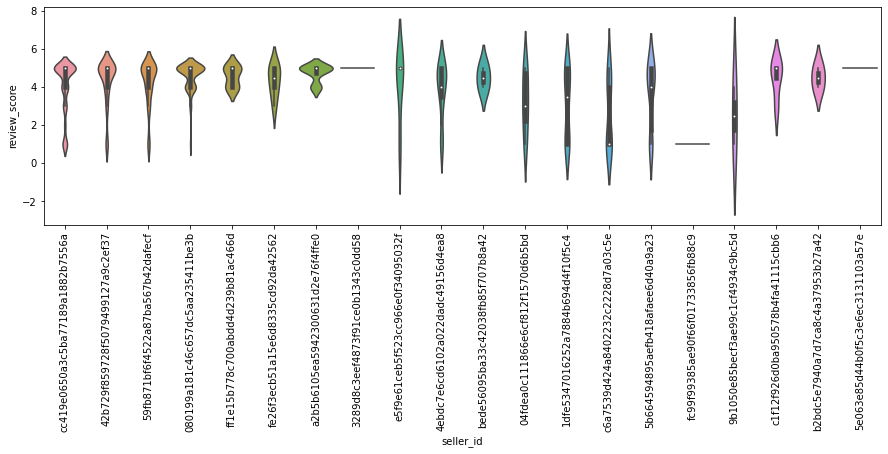

In [1806]:
# 셀러마다 판매건수가 달라 review_score 분포도 다양한 형태로 나타남
plt.figure(figsize = (15, 4))
plt.xticks(rotation = 90)
sns.violinplot(data = df_top, x = 'seller_id', y = 'review_score')

In [1807]:
# order_status별 review_score 평균
df_status = df.groupby('order_status')['review_score'].agg('mean').sort_values(ascending = False).reset_index()
df_status

order_status  review_score
0  delivered    4.114255    
1  approved     2.500000    
2  shipped      2.008152    
3  invoiced     1.670000    
4  canceled     1.596372    
5  processing   1.281787

<AxesSubplot:xlabel='order_status', ylabel='review_score'>

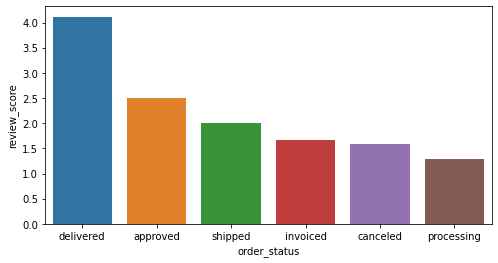

In [1808]:
# delivered가 아닌 나머지 status의 review_score 평균은 낮음
# delivered 상태의 review_score 평균은 4점을 웃돌아 양호한 편인 것으로 판단됨
plt.figure(figsize = (8, 4))
sns.barplot(data = df_status, x = 'order_status', y = 'review_score')

# 전처리

## 분석대상 재설정
### ★한 order_id에 여러 seller_id, product_id 있는 경우

In [1809]:
check_orderitem = df.groupby('order_id')['seller_id', 'product_id'].agg('count').reset_index()
check_orderitem = check_orderitem[check_orderitem['seller_id']>1]
check_orderitem

order_id  seller_id  product_id
73     002f98c0f7efd42638ed6100ca699b42  2          2         
82     00337fe25a3780b3424d9ad7c5a4b35e  2          2         
85     0035246a40f520710769010f752e7507  2          2         
130    005d9a5423d47281ac463a968b3936fb  2          2         
193    00946f674d880be1f188abc10ad7cf46  2          2         
...                                 ... ..         ..         
96855  ffb18bf111fa70edf316eb0390427986  2          2         
96863  ffb8f7de8940249a3221252818937ecb  3          3         
96864  ffb9a9cd00c74c11c24aa30b3d78e03b  3          3         
96875  ffc16cecff8dc037f60458f28d1c1ba5  2          2         
96896  ffd543c2b60842e148a86870dc60e212  2          2         

[3665 rows x 3 columns]

In [1810]:
check_orderitem_index = check_orderitem['order_id'].tolist()
check_orderitem_index

['002f98c0f7efd42638ed6100ca699b42',
 '00337fe25a3780b3424d9ad7c5a4b35e',
 '0035246a40f520710769010f752e7507',
 '005d9a5423d47281ac463a968b3936fb',
 '00946f674d880be1f188abc10ad7cf46',
 '0097f0545a302aafa32782f1734ff71c',
 '00bcee890eba57a9767c7b5ca12d3a1b',
 '01144cadcf64b6427f0a6580a3033220',
 '01235dc626dcf13283207ba7f36a959a',
 '012a238ab54294a3b365812ccc82b135',
 '013056cfe49763c6f66bda03396c5ee3',
 '0132451f29a10b66a5cf1bacc85f9afe',
 '013a98b3a668bcef05b98898177f6923',
 '014405982914c2cde2796ddcf0b8703d',
 '015183dcb37f19e0456905fa5aac0b69',
 '017499de14d22ef9e9a83ca54727480e',
 '0176a6846bcb3b0d3aa3116a9a768597',
 '0179a3003c894f1dd3b1ddda5d1f8a12',
 '017dcb6892d4469a13dee34f241f8c4e',
 '018bb1508d9156b81990407b91fb35a8',
 '01a4ec962d7589584c11650ca20d728b',
 '01b1a7fdae9ad1837d6ab861705a1fa5',
 '01cce1175ac3c4a450e3a0f856d02734',
 '02355020fd0a40a0d56df9f6ff060413',
 '023669233121f0fb7899e5be2b22885f',
 '023af4b88d12c9f3f56bcb55da0450c5',
 '024554aeb0da84476f1c31a711e0990c',
 

In [1811]:
df[df['order_id']=='0245631f7bd55dbee7c6b441629bba94']

order_id                        product_id  \
887  0245631f7bd55dbee7c6b441629bba94  2b10e945dae5434075c8bb2be0d17325   
888  0245631f7bd55dbee7c6b441629bba94  372645c7439f9661fbbacfd129aa92ec   
889  0245631f7bd55dbee7c6b441629bba94  525947dbe3304ac32bf51602f9557c12   
890  0245631f7bd55dbee7c6b441629bba94  eb53f94fdc60278efcef123bb275658a   

                            seller_id  shipping_limit_date  price  \
887  da8622b14eb17ae2831f4ac5b9dab84a  2017-10-11 18:45:20  279.9   
888  da8622b14eb17ae2831f4ac5b9dab84a  2017-10-11 18:45:20  119.9   
889  da8622b14eb17ae2831f4ac5b9dab84a  2017-10-11 18:45:20  119.9   
890  da8622b14eb17ae2831f4ac5b9dab84a  2017-10-11 18:45:20  329.9   

     freight_value  num  revenue                       customer_id  \
887  30.84          1.0  310.74   4d82e79f5404e8c3f059ab099fbe5dda   
888  13.13          1.0  133.03   4d82e79f5404e8c3f059ab099fbe5dda   
889  12.33          1.0  132.23   4d82e79f5404e8c3f059ab099fbe5dda   
890  33.82          1.0  363.72   4d82e79f5404e8c3f059ab099fbe5dda   

    order_status order_purchase_timestamp    order_approved_at  \
887  delivered    2017-10-05 18:26:36      2017-10-05 18:45:20   
888  delivered    2017-10-05 18:26:36      2017-10-05 18:45:20   
889  delivered    2017-10-05 18:26:36      2017-10-05 18:45:20   
890  delivered    2017-10-05 18:26:36      2017-10-05 18:45:20   

    order_delivered_carrier_date order_delivered_customer_date  \
887  2017-10-06 19:48:55          2017-10-13 21:37:42            
888  2017-10-06 19:48:55          2017-10-13 21:37:42            
889  2017-10-06 19:48:55          2017-10-13 21:37:42            
890  2017-10-06 19:48:55          2017-10-13 21:37:42            

    order_estimated_delivery_date purchase_month  \
887  2017-11-01 00:00:00           2017-10         
888  2017-11-01 00:00:00           2017-10         
889  2017-11-01 00:00:00           2017-10         
890  2017-11-01 00:00:00           2017-10         

                            review_id  review_score review_comment_title  \
887  2cb679cfffd69784ae97b7f48293f6bd  2             NaN                   
888  2cb679cfffd69784ae97b7f48293f6bd  2             NaN                   
889  2cb679cfffd69784ae97b7f48293f6bd  2             NaN                   
890  2cb679cfffd69784ae97b7f48293f6bd  2             NaN                   

                                                                                      review_comment_message  \
887  Essa cortina não veio com as demais:Cortina Voil Branca 8,00x2,80 Forro Microfibra Ilhós Cromado Branco   
888  Essa cortina não veio com as demais:Cortina Voil Branca 8,00x2,80 Forro Microfibra Ilhós Cromado Branco   
889  Essa cortina não veio com as demais:Cortina Voil Branca 8,00x2,80 Forro Microfibra Ilhós Cromado Branco   
890  Essa cortina não veio com as demais:Cortina Voil Branca 8,00x2,80 Forro Microfibra Ilhós Cromado Branco   

    review_creation_date review_answer_timestamp product_category_name  \
887  2017-10-14 00:00:00  2017-10-15 20:03:59     cama_mesa_banho        
888  2017-10-14 00:00:00  2017-10-15 20:03:59     cama_mesa_banho        
889  2017-10-14 00:00:00  2017-10-15 20:03:59     cama_mesa_banho        
890  2017-10-14 00:00:00  2017-10-15 20:03:59     cama_mesa_banho        

     product_name_lenght  product_description_lenght  product_photos_qty  \
887  60.0                 233.0                       1.0                  
888  60.0                 236.0                       1.0                  
889  60.0                 236.0                       1.0                  
890  60.0                 270.0                       1.0                  

     product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
887  2950.0            46.0               8.0                38.0               
888  1500.0            34.0               7.0                32.0               
889  2600.0            34.0               7.0                32.0               
890  3400.0    

In [1812]:
# 해당 데이터는 어떤 셀러, 어떤 제품때문에 해당 review_score를 받았는지 구분이 불가하므로 데이터 제거
df = df[~df['order_id'].isin(check_orderitem_index)]
df

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
103030  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
103031  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
103032  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
103033  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
103034  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  shipping_limit_date   price  \
0       48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.90    
1       dd7ddc04e1b6c2c614352b383efe2d36  2017-05-03 11:05:13  239.90   
2       5b51032eddd242adc84c38acab88f23d  2018-01-18 14:48:30  199.00   
3       9d7a1d34a5052409006425275ba1c2b4  2018-08-15 10:10:18  12.99    
4       df560393f3a51e74553ab94004ba5c87  2017-02-13 13:57:51  199.90   
...                                  ...                  ...     ...   
103030  b8bc237ba3788b23da09c0f1f3a3288c  2018-05-02 04:11:01  299.99   
103031  f3c38ab652836d21de61fb8314b69182  2018-07-20 04:31:48  350.00   
103032  c3cfdc648177fdbbbb35635a37472c53  2017-10-30 17:14:25  99.90    
103033  2b3e4a2a3ea8e01938cabda2a3e5cc79  2017-08-21 00:04:32  55.99    
103034  f7ccf836d21b2fb1de37564105216cc1  2018-06-12 17:10:13  43.00    

        freight_value  num  revenue                       customer_id  \
0       13.29          1.0  72.19    3ce436f183e68e07877b285a838db11a   
1       19.93          1.0  259.83   f6dd3ec061db4e3987629fe6b26e5cce   
2       17.87          1.0  216.87   6489ae5e4333f3693df5ad4372dab6d3   
3       12.79          1.0  25.78    d4eb9395c8c0431ee92fce09860c5a06   
4       18.14          1.0  218.04   58dbd0b2d70206bf40e62cd34e84d795   
...       ...          ...     ...                                ...   
103030  43.41          1.0  343.40   b51593916b4b8e0d6f66f2ae24f2673d   
103031  36.53          1.0  386.53   84c5d4fbaf120aae381fad077416eaa0   
103032  16.95          1.0  116.85   29309aa813182aaddc9b259e31b870e6   
103033  8.72           1.0  64.71    b5e6afd5a41800fdf401e0272ca74655   
103034  12.79          1.0  55.79    96d649da0cc4ff33bb408b199d4c7dcf   

       order_status order_purchase_timestamp    order_approved_at  \
0       delivered    2017-09-13 08:59:02      2017-09-13 09:45:35   
1       delivered    2017-04-26 10:53:06      2017-04-26 11:05:13   
2       delivered    2018-01-14 14:33:31      2018-01-14 14:48:30   
3       delivered    2018-08-08 10:00:35      2018-08-08 10:10:18   
4       delivered    2017-02-04 13:57:51      2017-02-04 14:10:13   
...           ...                    ...                      ...   
103030  delivered    2018-04-23 13:57:06      2018-04-25 04:11:01   
103031  delivered    2018-07-14 10:26:46      2018-07-17 04:31:48   
103032  delivered    2017-10-23 17:07:56      2017-10-24 17:14:25   
103033  delivered    2017-08-14 23:02:59      2017-08-15 00:04:32   
103034  delivered    2018-06-09 17:00:18      2018-06-09 17:10:13   

       order_delivered_carrier_date order_delivered_customer_date  \
0       2017-09-19 18:34:16          2017-09-20 23:43:48            
1       2017-05-04 14:35:00          2017-05-12 16:04:24            
2       2018-01-16 12:36:48          2018-01-22 13:19:16            
3       2018-08-10 13:28:00          2018-08-14 13:32:39            
4       2017-02-16 09:46:09          2017-03-01 16:42:31            
...                     ...                          ...            
103030  2018-04-25 12:09:00  

### ★한 order_id에 여러 review_id가 있는 경우

In [1813]:
# 여러 review가 발생한 원인을 정확하게 파악할 수 없으므로 해당 데이터는 모두 삭제
# (실제로 고객의 만족도가 달라진 경우일 수도 있고, 리뷰점수 조작인 경우도 있을 수 있음)
check_review = df.groupby('order_id')['review_id'].agg('count').reset_index()
check_review

order_id  review_id
0      00010242fe8c5a6d1ba2dd792cb16214  1        
1      00018f77f2f0320c557190d7a144bdd3  1        
2      000229ec398224ef6ca0657da4fc703e  1        
3      00024acbcdf0a6daa1e931b038114c75  1        
4      00042b26cf59d7ce69dfabb4e55b4fd9  1        
...                                 ... ..        
93296  fffc94f6ce00a00581880bf54a75a037  1        
93297  fffcd46ef2263f404302a634eb57f7eb  1        
93298  fffce4705a9662cd70adb13d4a31832d  1        
93299  fffe18544ffabc95dfada21779c9644f  1        
93300  fffe41c64501cc87c801fd61db3f6244  1        

[93301 rows x 2 columns]

In [1814]:
# 해당 데이터 없어짐?
check_review[check_review['review_id'] > 1]

Empty DataFrame
Columns: [order_id, review_id]
Index: []

### order_delivered_customer_date 없는 경우

In [1815]:
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
shipping_limit_date              0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
customer_id                      0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     929  
order_delivered_customer_date    2043 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             82267
review_comment_message           55056
review_creation_date             0    
review_answer_timestamp          0    
product_category_name            0    
product_name_lenght              0    
product_description_lenght       0    
product_photos_qty       

In [1816]:
# 'order_delivered_customer_date'가 null인 경우의 review_comment 확인 : 대부분이 제품을 제대로 받지 못한 경우
temp = df[df['order_delivered_customer_date'].isnull()]
temp.loc[~temp['review_comment_message'].isnull(), 'review_comment_message']

72        Minha mercadoria não chegou e ninguém entrou em contato para resolver nada...                                                        
240       comprometimento com o cliente                                                                                                        
250       Não recebi o produto ainda                                                                                                           
383       O produto não veio                                                                                                                   
495       Recebi um comunicado que não teria o produto no estoque da loja, foi feito o cancelamento e estou aguardando o estorno do valor pago 
                                                                          ...                                                                  
102560    Estou aguardando o produto até agora!\r\nEspero que a loja lannister tome as devidas providências.                            

In [1817]:
# 'order_delivered_carrier_date'가 null인 경우의 review_comment 확인 : 대부분이 제품을 제대로 받지 못한 경우
temp = df[df['order_delivered_carrier_date'].isnull()]
temp.loc[~temp['review_comment_message'].isnull(), 'review_comment_message']

250       Não recebi o produto ainda                                                                                                                                               
383       O produto não veio                                                                                                                                                       
495       Recebi um comunicado que não teria o produto no estoque da loja, foi feito o cancelamento e estou aguardando o estorno do valor pago                                     
506       PRODUTO NÃO RECEBIDO                                                                                                                                                     
533       Comprei duas banquetas brancas no site pra ser entregue até 13/03 e até agora não recebi bem minha casa.Aguardo providências ou vou procurar meus direitos d consumidora.
                                                                                            ...     

Text(0.5, 1.0, 'DF')

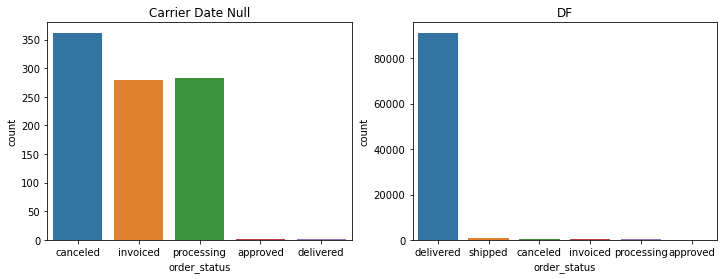

In [1818]:
# 배송일자가 없는 데이터와 전체 데이터 order_status 건수 비교
f,ax = plt.subplots(1, 2, figsize = (12,4))

sns.countplot(data = temp, x = 'order_status', ax = ax[0])
ax[0].set_title('Carrier Date Null')

sns.countplot(data = df, x = 'order_status', ax = ax[1])
ax[1].set_title('DF')

Text(0.5, 1.0, 'DF')

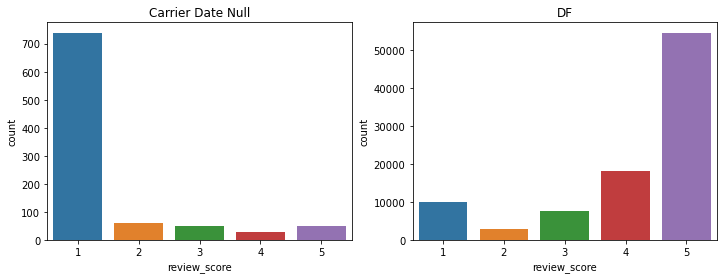

In [1819]:
# 배송일자가 없는 데이터와 전체 데이터 review_score 건수 비교
f,ax = plt.subplots(1, 2, figsize = (12,4))

sns.countplot(data = temp, x = 'review_score', ax = ax[0])
ax[0].set_title('Carrier Date Null')

sns.countplot(data = df, x = 'review_score', ax = ax[1])
ax[1].set_title('DF')

# 배송일자가 없는 데이터는 취소되었거나 배송 진행중인 데이터가 대부분으로, review_score가 낮은 것으로 확인됨
# 해당 데이터를 제거하는 것은 부적절할 것으로 판단되며, 추후 배송소요일 등의 날짜 계산시 별도의 처리를 하기로 함

## ★불필요 컬럼 삭제

In [1820]:
df

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
103030  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
103031  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
103032  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
103033  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
103034  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id  shipping_limit_date   price  \
0       48436dade18ac8b2bce089ec2a041202  2017-09-19 09:45:35  58.90    
1       dd7ddc04e1b6c2c614352b383efe2d36  2017-05-03 11:05:13  239.90   
2       5b51032eddd242adc84c38acab88f23d  2018-01-18 14:48:30  199.00   
3       9d7a1d34a5052409006425275ba1c2b4  2018-08-15 10:10:18  12.99    
4       df560393f3a51e74553ab94004ba5c87  2017-02-13 13:57:51  199.90   
...                                  ...                  ...     ...   
103030  b8bc237ba3788b23da09c0f1f3a3288c  2018-05-02 04:11:01  299.99   
103031  f3c38ab652836d21de61fb8314b69182  2018-07-20 04:31:48  350.00   
103032  c3cfdc648177fdbbbb35635a37472c53  2017-10-30 17:14:25  99.90    
103033  2b3e4a2a3ea8e01938cabda2a3e5cc79  2017-08-21 00:04:32  55.99    
103034  f7ccf836d21b2fb1de37564105216cc1  2018-06-12 17:10:13  43.00    

        freight_value  num  revenue                       customer_id  \
0       13.29          1.0  72.19    3ce436f183e68e07877b285a838db11a   
1       19.93          1.0  259.83   f6dd3ec061db4e3987629fe6b26e5cce   
2       17.87          1.0  216.87   6489ae5e4333f3693df5ad4372dab6d3   
3       12.79          1.0  25.78    d4eb9395c8c0431ee92fce09860c5a06   
4       18.14          1.0  218.04   58dbd0b2d70206bf40e62cd34e84d795   
...       ...          ...     ...                                ...   
103030  43.41          1.0  343.40   b51593916b4b8e0d6f66f2ae24f2673d   
103031  36.53          1.0  386.53   84c5d4fbaf120aae381fad077416eaa0   
103032  16.95          1.0  116.85   29309aa813182aaddc9b259e31b870e6   
103033  8.72           1.0  64.71    b5e6afd5a41800fdf401e0272ca74655   
103034  12.79          1.0  55.79    96d649da0cc4ff33bb408b199d4c7dcf   

       order_status order_purchase_timestamp    order_approved_at  \
0       delivered    2017-09-13 08:59:02      2017-09-13 09:45:35   
1       delivered    2017-04-26 10:53:06      2017-04-26 11:05:13   
2       delivered    2018-01-14 14:33:31      2018-01-14 14:48:30   
3       delivered    2018-08-08 10:00:35      2018-08-08 10:10:18   
4       delivered    2017-02-04 13:57:51      2017-02-04 14:10:13   
...           ...                    ...                      ...   
103030  delivered    2018-04-23 13:57:06      2018-04-25 04:11:01   
103031  delivered    2018-07-14 10:26:46      2018-07-17 04:31:48   
103032  delivered    2017-10-23 17:07:56      2017-10-24 17:14:25   
103033  delivered    2017-08-14 23:02:59      2017-08-15 00:04:32   
103034  delivered    2018-06-09 17:00:18      2018-06-09 17:10:13   

       order_delivered_carrier_date order_delivered_customer_date  \
0       2017-09-19 18:34:16          2017-09-20 23:43:48            
1       2017-05-04 14:35:00          2017-05-12 16:04:24            
2       2018-01-16 12:36:48          2018-01-22 13:19:16            
3       2018-08-10 13:28:00          2018-08-14 13:32:39            
4       2017-02-16 09:46:09          2017-03-01 16:42:31            
...                     ...                          ...            
103030  2018-04-25 12:09:00  

In [1821]:
df = df.drop(['shipping_limit_date', 'customer_id', 'review_answer_timestamp', 'product_category_name', 'product_category_name_english',
             'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm',
              'product_height_cm', 'product_width_cm'], axis = 1)
df.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id   price  freight_value  num  revenue  \
0  48436dade18ac8b2bce089ec2a041202  58.90   13.29          1.0  72.19     
1  dd7ddc04e1b6c2c614352b383efe2d36  239.90  19.93          1.0  259.83    
2  5b51032eddd242adc84c38acab88f23d  199.00  17.87          1.0  216.87    
3  9d7a1d34a5052409006425275ba1c2b4  12.99   12.79          1.0  25.78     
4  df560393f3a51e74553ab94004ba5c87  199.90  18.14          1.0  218.04    

  order_status order_purchase_timestamp    order_approved_at  \
0  delivered    2017-09-13 08:59:02      2017-09-13 09:45:35   
1  delivered    2017-04-26 10:53:06      2017-04-26 11:05:13   
2  delivered    2018-01-14 14:33:31      2018-01-14 14:48:30   
3  delivered    2018-08-08 10:00:35      2018-08-08 10:10:18   
4  delivered    2017-02-04 13:57:51      2017-02-04 14:10:13   

  order_delivered_carrier_date order_delivered_customer_date  \
0  2017-09-19 18:34:16          2017-09-20 23:43:48            
1  2017-05-04 14:35:00          2017-05-12 16:04:24            
2  2018-01-16 12:36:48          2018-01-22 13:19:16            
3  2018-08-10 13:28:00          2018-08-14 13:32:39            
4  2017-02-16 09:46:09          2017-03-01 16:42:31            

  order_estimated_delivery_date purchase_month  \
0  2017-09-29 00:00:00           2017-09         
1  2017-05-15 00:00:00           2017-04         
2  2018-02-05 00:00:00           2018-01         
3  2018-08-20 00:00:00           2018-08         
4  2017-03-17 00:00:00           2017-02         

                          review_id  review_score review_comment_title  \
0  97ca439bc427b48bc1cd7177abe71365  5             NaN                   
1  7b07bacd811c4117b742569b04ce3580  4             NaN                   
2  0c5b33dea94867d1ac402749e5438e8b  5             NaN                   
3  f4028d019cb58564807486a6aaf33817  4             NaN                   
4  940144190dcba6351888cafa43f3a3a5  5             NaN                   

                                                                       review_comment_message  \
0  Perfeito, produto entregue antes do combinado.                                               
1  NaN                                                                                          
2  Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.   
3  NaN                                                                                          
4  Gostei pois veio no prazo determinado .                                                      

  review_creation_date  new_category  
0  2017-09-21 00:00:00  stationery    
1  2017-05-13 00:00:00  pet           
2  2018-01-23 00:00:00  furniture     
3  2018-08-15 00:00:00  beauty        
4  2017-03-02 00:00:00  garden_tools

In [1822]:
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     929  
order_delivered_customer_date    2043 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             82267
review_comment_message           55056
review_creation_date             0    
new_category                     0    
dtype: int64

In [1823]:
df.describe()

price  freight_value           num       revenue  review_score
count  93301.000000  93301.000000   93301.000000  93301.000000  93301.000000
mean   127.461164    20.297452      1.099056      158.002670    4.119120    
std    193.362795    15.957401      0.455813      219.622159    1.319522    
min    0.850000      0.000000       1.000000      9.590000      1.000000    
25%    42.440000     13.370000      1.000000      61.010000     4.000000    
50%    79.900000     16.430000      1.000000      103.040000    5.000000    
75%    139.990000    21.290000      1.000000      173.670000    5.000000    
max    6735.000000   409.680000     20.000000     13664.080000  5.000000

In [1824]:
df.describe(include = 'O')

order_id                        product_id  \
count   93301                             93301                              
unique  93301                             30159                              
top     8e65781b8f5e21774c8d7b09dd79b964  aca2eb7d00ea1a7b8ebd4e68314663af   
freq    1                                 429                                

                               seller_id order_status  \
count   93301                             93301         
unique  2980                              6             
top     6560211a19b47992c3666cc44a7e94c0  delivered     
freq    1711                              91265         

       order_purchase_timestamp    order_approved_at  \
count   93301                    93288                 
unique  92916                    85528                 
top     2018-04-11 10:48:14      2018-02-27 04:31:10   
freq    3                        9                     

       order_delivered_carrier_date order_delivered_customer_date  \
count   92372                        91258                          
unique  76843                        90529                          
top     2018-05-09 15:48:00          2018-05-14 20:02:44            
freq    47                           3                              

       order_estimated_delivery_date purchase_month  \
count   93301                         93301           
unique  420                           20              
top     2018-05-29 00:00:00           2017-11         
freq    490                           7027            

                               review_id review_comment_title  \
count   93301                             11034                 
unique  93041                             4307                  
top     70509c441d994fa03d6c1457930c9024  Recomendo             
freq    3                                 407                   

       review_comment_message review_creation_date new_category  
count   38245                  93301                93301        
unique  33896                  583                  21           
top     Muito bom              2017-12-19 00:00:00  stationery   
freq    217                    435                  16046

## Dtype 수정

In [1825]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93301 entries, 0 to 103034
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       93301 non-null  object 
 1   product_id                     93301 non-null  object 
 2   seller_id                      93301 non-null  object 
 3   price                          93301 non-null  float64
 4   freight_value                  93301 non-null  float64
 5   num                            93301 non-null  float64
 6   revenue                        93301 non-null  float64
 7   order_status                   93301 non-null  object 
 8   order_purchase_timestamp       93301 non-null  object 
 9   order_approved_at              93288 non-null  object 
 10  order_delivered_carrier_date   92372 non-null  object 
 11  order_delivered_customer_date  91258 non-null  object 
 12  order_estimated_delivery_date  93301 non-null

In [1826]:
# 날짜 관련 컬럼 datetime 타입으로 변환
df.iloc[:, 8:13] = df.iloc[:, 8:13].apply(pd.to_datetime)
df.iloc[:, 18] = df.iloc[:, 18].apply(pd.to_datetime)

In [1827]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93301 entries, 0 to 103034
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93301 non-null  object        
 1   product_id                     93301 non-null  object        
 2   seller_id                      93301 non-null  object        
 3   price                          93301 non-null  float64       
 4   freight_value                  93301 non-null  float64       
 5   num                            93301 non-null  float64       
 6   revenue                        93301 non-null  float64       
 7   order_status                   93301 non-null  object        
 8   order_purchase_timestamp       93301 non-null  datetime64[ns]
 9   order_approved_at              93288 non-null  datetime64[ns]
 10  order_delivered_carrier_date   92372 non-null  datetime64[ns]
 11  order_delivere

## 필요컬럼 생성

### 날짜 관련 컬럼

#### 'delay', 'avg_delivery', 'preparation' 컬럼 생성
 - delay : 배달 지연일수 (완료일 - 예정일)
 - avg_delivery : 평균 배송일수 (완료일 - 주문일)
 - preparation : 제품 준비기간 (발송일 - 주문일)

In [1828]:
df['delay'] =  (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df['avg_delivery'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['preparation'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']).dt.days

In [1829]:
df.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id   price  freight_value  num  revenue  \
0  48436dade18ac8b2bce089ec2a041202  58.90   13.29          1.0  72.19     
1  dd7ddc04e1b6c2c614352b383efe2d36  239.90  19.93          1.0  259.83    
2  5b51032eddd242adc84c38acab88f23d  199.00  17.87          1.0  216.87    
3  9d7a1d34a5052409006425275ba1c2b4  12.99   12.79          1.0  25.78     
4  df560393f3a51e74553ab94004ba5c87  199.90  18.14          1.0  218.04    

  order_status order_purchase_timestamp   order_approved_at  \
0  delivered   2017-09-13 08:59:02      2017-09-13 09:45:35   
1  delivered   2017-04-26 10:53:06      2017-04-26 11:05:13   
2  delivered   2018-01-14 14:33:31      2018-01-14 14:48:30   
3  delivered   2018-08-08 10:00:35      2018-08-08 10:10:18   
4  delivered   2017-02-04 13:57:51      2017-02-04 14:10:13   

  order_delivered_carrier_date order_delivered_customer_date  \
0 2017-09-19 18:34:16          2017-09-20 23:43:48             
1 2017-05-04 14:35:00          2017-05-12 16:04:24             
2 2018-01-16 12:36:48          2018-01-22 13:19:16             
3 2018-08-10 13:28:00          2018-08-14 13:32:39             
4 2017-02-16 09:46:09          2017-03-01 16:42:31             

  order_estimated_delivery_date purchase_month  \
0 2017-09-29                     2017-09         
1 2017-05-15                     2017-04         
2 2018-02-05                     2018-01         
3 2018-08-20                     2018-08         
4 2017-03-17                     2017-02         

                          review_id  review_score review_comment_title  \
0  97ca439bc427b48bc1cd7177abe71365  5             NaN                   
1  7b07bacd811c4117b742569b04ce3580  4             NaN                   
2  0c5b33dea94867d1ac402749e5438e8b  5             NaN                   
3  f4028d019cb58564807486a6aaf33817  4             NaN                   
4  940144190dcba6351888cafa43f3a3a5  5             NaN                   

                                                                       review_comment_message  \
0  Perfeito, produto entregue antes do combinado.                                               
1  NaN                                                                                          
2  Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.   
3  NaN                                                                                          
4  Gostei pois veio no prazo determinado .                                                      

  review_creation_date  new_category  delay  avg_delivery  preparation  
0 2017-09-21            stationery   -9.0    7.0           6.0          
1 2017-05-13            pet          -3.0    16.0          8.0          
2 2018-01-23            furniture    -14.0   7.0           1.0          
3 2018-08-15            beauty       -6.0    6.0           2.0          
4 2017-03-02            garden_tools -16.0   25.0          11.0

- 새로 생성한 3개 변수 분포 distplot으로 확인

<AxesSubplot:xlabel='preparation', ylabel='Density'>

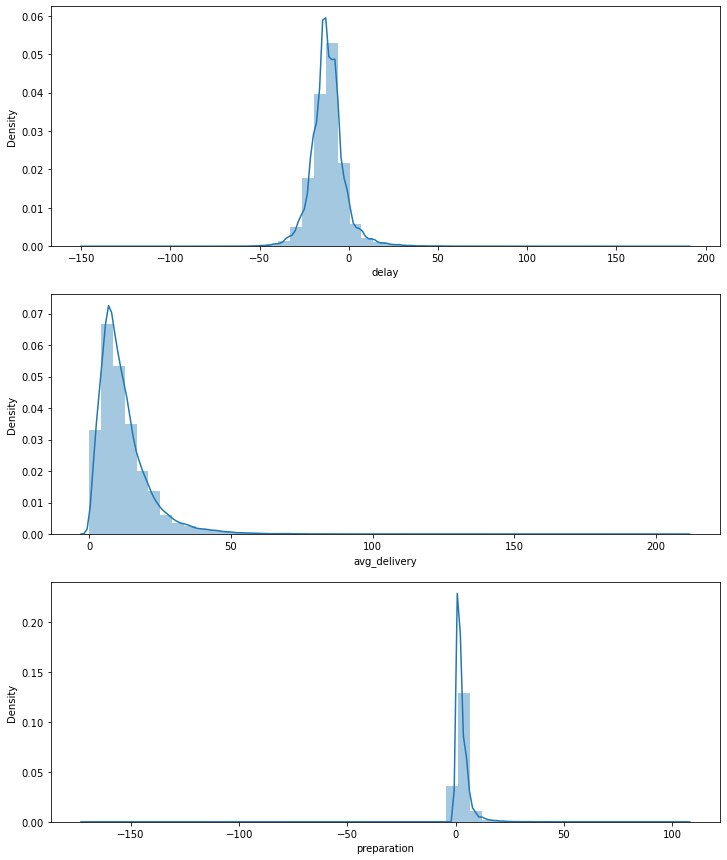

In [1830]:
f,ax = plt.subplots(3, 1, figsize = (12,15))

sns.distplot(df['delay'], ax=ax[0])
sns.distplot(df['avg_delivery'], ax=ax[1])
sns.distplot(df['preparation'], ax=ax[2])

- 배달 지연일수 (완료일 - 예정일)

In [1831]:
# 140일 일찍 도착 ~ 188일 지연 사이에 분포, 평균적으로 11.7일 일찍 도착함
df['delay'].min(), df['delay'].max(), round(df['delay'].mean(),1)

(-147.0, 188.0, -11.7)

In [1832]:
# 100일+ 빨리 도착한 특이 데이터 확인 (예정일이 너무 늦은 시점으로 잡혀있었던 경우)
df[df['delay'] < -100]

order_id                        product_id  \
2444   0607f0efea4b566f1eb8f7d3c2397320  952ef4ed720bf5d77f42712da90f2f49   
26037  40dc2ba6f322a17626aac6244332828c  38841dec90eddf2f43cdfabc48b3831a   
78356  c2bb89b5c1dd978d507284be78a04cb2  87b92e06b320e803d334ac23966c80b1   
80172  c72727d29cde4cf870d569bf65edabfd  ee2f96cb63d491d963a67285f048775a   
96158  eec7f369423b033e549c02f3c5381205  29dcc20b00ccb0dd2136eb2f4c5f3847   

                              seller_id   price  freight_value  num  revenue  \
2444   903037660cf848a717166eb7a06d616e  62.99   10.09          2.0  146.16    
26037  1354d51653f645349064725ed204e85e  40.00   14.10          1.0  54.10     
78356  7a241947449cc45dbfda4f9d0798d9d0  99.99   61.44          2.0  322.86    
80172  fce62094ffe6a4009188ec44e681dfdd  25.90   26.09          1.0  51.99     
96158  903037660cf848a717166eb7a06d616e  252.99  19.02          1.0  272.01    

      order_status order_purchase_timestamp   order_approved_at  \
2444   delivered   2018-03-06 09:47:07      2018-03-06 09:55:47   
26037  delivered   2017-10-05 21:39:05      2017-10-05 21:49:21   
78356  delivered   2017-05-23 22:28:36      2017-05-24 22:35:08   
80172  delivered   2017-02-07 18:01:15      2017-02-09 02:50:07   
96158  delivered   2018-02-06 20:44:56      2018-02-08 10:10:31   

      order_delivered_carrier_date order_delivered_customer_date  \
2444  2018-03-07 21:33:39          2018-03-09 23:36:47             
26037 2017-10-09 12:13:58          2017-10-13 13:49:07             
78356 2017-05-29 02:03:28          2017-06-09 13:35:54             
80172 2017-02-10 05:32:55          2017-02-14 14:27:45             
96158 2018-02-15 20:42:12          2018-02-27 16:35:43             

      order_estimated_delivery_date purchase_month  \
2444  2018-08-03                     2018-03         
26037 2018-01-30                     2017-10         
78356 2017-10-11                     2017-05         
80172 2017-07-04                     2017-02         
96158 2018-07-12                     2018-02         

                              review_id  review_score review_comment_title  \
2444   910f7f863978cf42c85c79c9aaefe353  5             NaN                   
26037  d926e41f5d8da4624f4850e60d7fc8fc  5             NaN                   
78356  6afeab17c60f9f9402bbf93abdce63e3  5             NaN                   
80172  2e33927523fc955215bff05187cea86b  5             NaN                   
96158  308aa99a70d28ba75e803ec8caf49088  3             NaN                   

                                                                                                           review_comment_message  \
2444   NaN                                                                                                                          
26037  NaN                                                                                                                          
78356  NaN                                                                                                                          
80172  NaN                                                                                                                          
96158  Meu produto chegou quebrado não sei como proceder pois acredito que tenha sido quebrado durante o transporte dos correios    

      review_creation_date     new_category  delay  avg_delivery  preparation  
2444  2018-03-10            furniture       -147.0  3.0           1.0          
26037 2017-10-14            culture         -109.0  7.0           3.0          
78356 2017-06-10            home_appliances -124.0  16.0          5.0          
80172 2017-02-15            others          -140.0  6.0           2.0          
96158 2018-02-28            furniture       -135.0  20.0          8.0

- 평균 배송일수 (완료일 - 주문일)

In [1833]:
# 0 ~ 209일 사이에 분포, 평균 12.1일 소요
df['avg_delivery'].min(), df['avg_delivery'].max(), round(df['avg_delivery'].mean(),1)

(0.0, 209.0, 12.1)

- 제품 준비기간 (발송일 - 주문일)

In [1834]:
# 준비기간이 -인 이상치 발견
df['preparation'].min(), df['preparation'].max(), round(df['preparation'].mean(),1)

(-172.0, 107.0, 2.7)

In [1835]:
# 이상치 확인
df[df['order_delivered_carrier_date'] < df['order_purchase_timestamp']]

order_id                        product_id  \
317     00d2559e61b9a0744a0552c35c5ecccb  44fc450365728c413fefc547592626be   
518     0150004d4d8eb63f9948de164da34e34  9bde344a67494559d37249506076d638   
1792    0474da9403011efc4abd2bf594e9b68b  c8327011b01e4666db6770ebb8a86fa9   
3225    07f770114a6de1a65f865bf22d8bb20a  27c5d184e397082e7f0ff11ace0d7269   
3503    08adcddad19d3acf37d1fa01cb9ded1e  c44343d9d6d3551e161f3c72bfcbfc3b   
...                                  ...                               ...   
101725  fcb9ec0e86e6d326a21a96c2008c8610  d8a728b48e36f36062bf197221a64335   
101985  fd58bdbb6cc5d7519e063c3ceb7e951b  6d68112743e7ed2de3932554b033f544   
102311  fe206005e41f89f9759ece7fe7acc9c3  21767347dfdabbe42b3ca5846a4cdb48   
102940  ffc0249fed109d5d056d7c79b7fa7dd9  a05ed2eb565616b13f6d58a44cf7097a   
102959  ffcc17a2f3331d4d25cf692060921690  42ec84ace63b58b8c5a7ba7be01d5fb8   

                               seller_id   price  freight_value  num  revenue  \
317     b839e41795b7f3ad94cc2014a52f6796  849.00  23.52          1.0  872.52    
518     b1a81260566c1bac3114a6d124413f27  219.90  20.51          1.0  240.41    
1792    d94a40fd42351c259927028d163af842  149.00  26.41          1.0  175.41    
3225    42b729f859728f5079499127a9c2ef37  62.90   14.02          1.0  76.92     
3503    17ca9b9e9b9ef8fdb529001b49ebb50f  149.97  16.12          1.0  166.09    
...                                  ...     ...    ...          ...     ...    
101725  670a9dda115b5a88b18cfadee8de2332  89.90   13.29          1.0  103.19    
101985  0d33a55da925bbf1ff02af5f6059fc7f  28.00   52.48          1.0  80.48     
102311  d921b68bf747894be13a97ae52b0f386  279.90  23.89          1.0  303.79    
102940  7ff588a03c2aeae4fbd23f9ae64b760d  24.99   7.44           1.0  32.43     
102959  2a84855fd20af891be03bc5924d2b453  89.90   13.46          1.0  103.36    

       order_status order_purchase_timestamp   order_approved_at  \
317     delivered   2018-06-11 12:24:48      2018-06-11 13:32:18   
518     delivered   2018-05-15 15:13:06      2018-05-15 15:34:59   
1792    delivered   2018-08-08 13:18:36      2018-08-08 13:30:15   
3225    delivered   2018-08-06 09:17:53      2018-08-06 09:30:16   
3503    delivered   2018-06-27 11:16:44      2018-06-27 11:30:56   
...           ...                   ...                      ...   
101725  delivered   2018-08-16 16:28:13      2018-08-16 16:49:04   
101985  delivered   2018-04-25 13:02:26      2018-04-25 13:15:26   
102311  delivered   2018-06-25 15:05:27      2018-06-25 15:18:59   
102940  delivered   2018-08-13 14:32:07      2018-08-13 14:45:15   
102959  delivered   2018-06-29 14:41:28      2018-06-29 14:50:16   

       order_delivered_carrier_date order_delivered_customer_date  \
317    2018-06-11 12:05:00          2018-06-18 16:51:52             
518    2018-05-15 14:58:00          2018-05-23 18:13:16             
1792   2018-08-08 12:19:00          2018-08-13 22:10:52             
3225   2018-08-06 08:44:00          2018-08-09 16:40:37             
3503   2018-06-27 10:57:00          2018-06-29 17:39:53             
...                    ...                          ...             
101725 2018-08-16 16:27:00          2018-08-20 19:54:47             
101985 2018-04-25 12:36:00          2018-05-08 16:32:17             
102311 2018-06-25 14:08:00          2018-07-03 20:10:15             
102940 2018-08-13 13:55:00          2018-08-14 23:58:57             
102959 2018-06-29 14:40:00          2018-07-03 16:14:35             

       order_estimated_delivery_date purchase_month  \
317    2018-06-28                     2018-06         
518    2018-06-07                     2018-05         
1792   2018-08-29                     2018-08         
3225   2018-08-16                     2018-08         
3503   2018-07-18                     2018-06         
...           ...                         ...         
101725 2018-09-03                     2018-08         
101985 2018-05-28                   

In [1836]:
df.loc[df['order_delivered_carrier_date'] < df['order_purchase_timestamp'], 'preparation'].value_counts()

-1.0      156
-172.0    1  
-5.0      1  
Name: preparation, dtype: int64

In [1837]:
# 시스템 오류인 데이터로 보이며, 정확한 분석을 위해 해당 데이터는 삭제
preparation_check_index = df.loc[(df['order_delivered_carrier_date'] < df['order_purchase_timestamp']), 'order_id'].to_list()
preparation_check_index

['00d2559e61b9a0744a0552c35c5ecccb',
 '0150004d4d8eb63f9948de164da34e34',
 '0474da9403011efc4abd2bf594e9b68b',
 '07f770114a6de1a65f865bf22d8bb20a',
 '08adcddad19d3acf37d1fa01cb9ded1e',
 '0a84606bdb8331708400882d2e921524',
 '0cf80be143500050973f324c3e068196',
 '0fa2c93bbfbce2c287bb56660c3998e3',
 '10251da35626072605d693e816f297ca',
 '1046a71a57b33b4a92f9f932237f1ab0',
 '108c3238d247dead3fd7423cf8990c5b',
 '119060af27b04f5fae8b2b0e27eef7f9',
 '12052ac6aa067434388199224c0f11bc',
 '1227f9af3b2ddb0b95060aab8e5b3dc7',
 '129b63bc323d7b5b2965a143b2e72cc7',
 '12e4fbad3ebed6412967a3fd5818c456',
 '13134fe6dc043430a875ece99381223b',
 '1388e91d7d43769d6bd71f89a48a2929',
 '154029fef0e3e2f72ef09775cc9d1af1',
 '15e67a6eec264915cd81f8f57dbacd81',
 '1c723386781fca8d1e45ac747914962a',
 '1c958182f10d6fcbac7728c8d3a151f1',
 '1cb3c680ddf904752646028ee22073a4',
 '1d400d95c6669247200db54206a74b55',
 '1d54af1bf3179b54f046212de28f8bc7',
 '2033a4586b5bec3229ebc1675a8ae092',
 '269ad8edf5c7dd6bfbe01dc68832f6ce',
 

In [1838]:
df = df[~df['order_id'].isin(preparation_check_index)]
df

order_id                        product_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1       00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2       000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3       00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4       00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                  ...                               ...   
103030  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
103031  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
103032  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
103033  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
103034  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                               seller_id   price  freight_value  num  revenue  \
0       48436dade18ac8b2bce089ec2a041202  58.90   13.29          1.0  72.19     
1       dd7ddc04e1b6c2c614352b383efe2d36  239.90  19.93          1.0  259.83    
2       5b51032eddd242adc84c38acab88f23d  199.00  17.87          1.0  216.87    
3       9d7a1d34a5052409006425275ba1c2b4  12.99   12.79          1.0  25.78     
4       df560393f3a51e74553ab94004ba5c87  199.90  18.14          1.0  218.04    
...                                  ...     ...    ...          ...     ...    
103030  b8bc237ba3788b23da09c0f1f3a3288c  299.99  43.41          1.0  343.40    
103031  f3c38ab652836d21de61fb8314b69182  350.00  36.53          1.0  386.53    
103032  c3cfdc648177fdbbbb35635a37472c53  99.90   16.95          1.0  116.85    
103033  2b3e4a2a3ea8e01938cabda2a3e5cc79  55.99   8.72           1.0  64.71     
103034  f7ccf836d21b2fb1de37564105216cc1  43.00   12.79          1.0  55.79     

       order_status order_purchase_timestamp   order_approved_at  \
0       delivered   2017-09-13 08:59:02      2017-09-13 09:45:35   
1       delivered   2017-04-26 10:53:06      2017-04-26 11:05:13   
2       delivered   2018-01-14 14:33:31      2018-01-14 14:48:30   
3       delivered   2018-08-08 10:00:35      2018-08-08 10:10:18   
4       delivered   2017-02-04 13:57:51      2017-02-04 14:10:13   
...           ...                   ...                      ...   
103030  delivered   2018-04-23 13:57:06      2018-04-25 04:11:01   
103031  delivered   2018-07-14 10:26:46      2018-07-17 04:31:48   
103032  delivered   2017-10-23 17:07:56      2017-10-24 17:14:25   
103033  delivered   2017-08-14 23:02:59      2017-08-15 00:04:32   
103034  delivered   2018-06-09 17:00:18      2018-06-09 17:10:13   

       order_delivered_carrier_date order_delivered_customer_date  \
0      2017-09-19 18:34:16          2017-09-20 23:43:48             
1      2017-05-04 14:35:00          2017-05-12 16:04:24             
2      2018-01-16 12:36:48          2018-01-22 13:19:16             
3      2018-08-10 13:28:00          2018-08-14 13:32:39             
4      2017-02-16 09:46:09          2017-03-01 16:42:31             
...                    ...                          ...             
103030 2018-04-25 12:09:00          2018-05-10 22:56:40             
103031 2018-07-17 08:05:00          2018-07-23 20:31:55             
103032 2017-10-26 15:13:14          2017-10-28 12:22:22             
103033 2017-08-15 19:02:53          2017-08-16 21:59:40             
103034 2018-06-11 14:11:00          2018-06-14 17:56:26             

       order_estimated_delivery_date purchase_month  \
0      2017-09-29                     2017-09         
1      2017-05-15                     2017-04         
2      2018-02-05                     2018-01         
3      2018-08-20                     2018-08         
4      2017-03-17                     2017-02         
...           ...                         ...         
103030 2018-05-18                     2018-04         
103031 2018-08-01                   

<AxesSubplot:xlabel='preparation', ylabel='Density'>

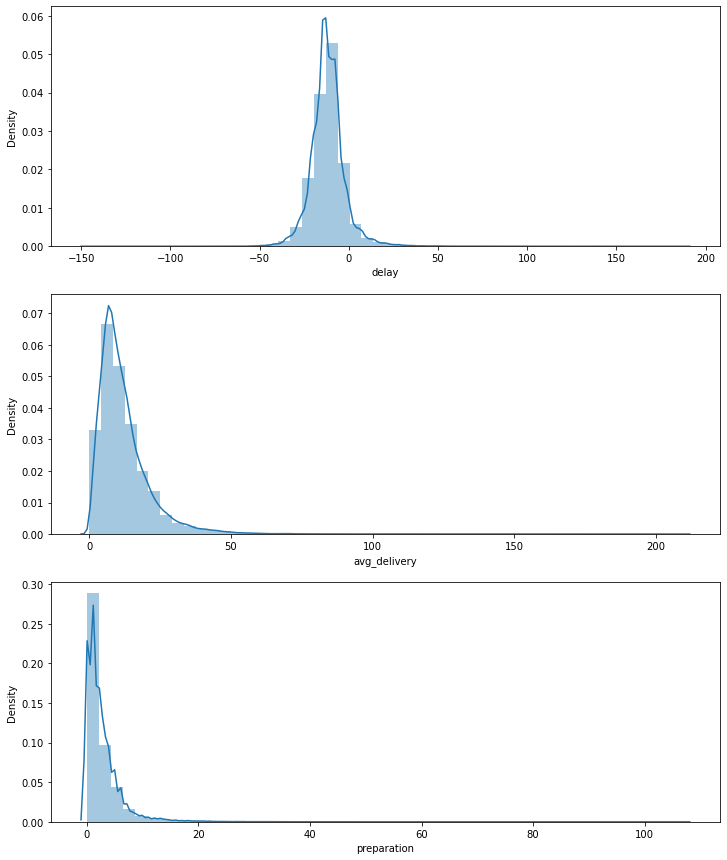

In [1839]:
f,ax = plt.subplots(3, 1, figsize = (12,15))

sns.distplot(df['delay'], ax=ax[0])
sns.distplot(df['avg_delivery'], ax=ax[1])
sns.distplot(df['preparation'], ax=ax[2])

#### order_delivered_carrier_date, order_delivered_customer_date 결측치 처리

In [1840]:
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
order_status                     0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     929  
order_delivered_customer_date    2043 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             82163
review_comment_message           54958
review_creation_date             0    
new_category                     0    
delay                            2043 
avg_delivery                     2043 
preparation                      929  
dtype: int64

In [1841]:
df[df['order_delivered_carrier_date'].isnull()].order_status.value_counts()

canceled      362
processing    283
invoiced      280
delivered     2  
approved      2  
Name: order_status, dtype: int64

In [1842]:
df[df['order_delivered_carrier_date'].isnull()].order_purchase_timestamp.describe()

count     929                
unique    929                
top       2018-01-17 17:09:02
freq      1                  
first     2017-01-11 15:18:25
last      2018-08-24 06:58:50
Name: order_purchase_timestamp, dtype: object

In [1843]:
df[df['order_delivered_carrier_date'].isnull()].order_purchase_timestamp.sort_values().tail(100)

83513   2018-07-08 13:34:57
4260    2018-07-08 18:44:18
32436   2018-07-11 09:23:23
16442   2018-07-11 09:55:49
27402   2018-07-11 22:27:32
                ...        
48088   2018-08-15 22:39:11
67858   2018-08-16 13:07:32
34172   2018-08-16 19:28:02
69375   2018-08-17 00:55:54
89868   2018-08-24 06:58:50
Name: order_purchase_timestamp, Length: 100, dtype: datetime64[ns]

<AxesSubplot:xlabel='preparation'>

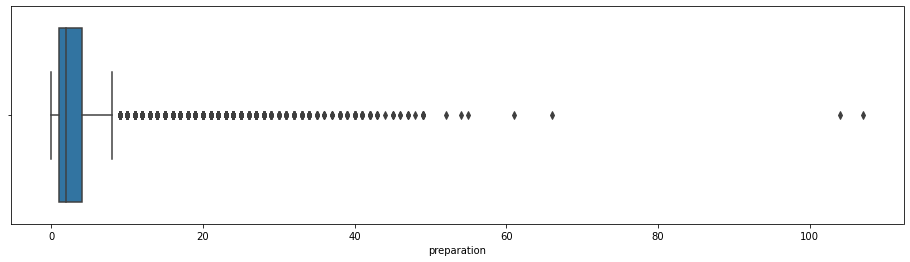

In [1844]:
plt.figure(figsize = (16,4))
sns.boxplot(df['preparation'])

### 'error' 컬럼 만들기

In [1845]:
# 완료일 - 예정일을 계산한 delay 컬럼값이 0 이상인 건은 배송예정일보다 늦게 도착한 건으로, review_score가 낮을 것으로 예상
df[df['delay'] > 0].review_score.value_counts()

1    3394
5    1034
3    689 
4    631 
2    543 
Name: review_score, dtype: int64

In [1846]:
df['error'] = 0
df.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id   price  freight_value  num  revenue  \
0  48436dade18ac8b2bce089ec2a041202  58.90   13.29          1.0  72.19     
1  dd7ddc04e1b6c2c614352b383efe2d36  239.90  19.93          1.0  259.83    
2  5b51032eddd242adc84c38acab88f23d  199.00  17.87          1.0  216.87    
3  9d7a1d34a5052409006425275ba1c2b4  12.99   12.79          1.0  25.78     
4  df560393f3a51e74553ab94004ba5c87  199.90  18.14          1.0  218.04    

  order_status order_purchase_timestamp   order_approved_at  \
0  delivered   2017-09-13 08:59:02      2017-09-13 09:45:35   
1  delivered   2017-04-26 10:53:06      2017-04-26 11:05:13   
2  delivered   2018-01-14 14:33:31      2018-01-14 14:48:30   
3  delivered   2018-08-08 10:00:35      2018-08-08 10:10:18   
4  delivered   2017-02-04 13:57:51      2017-02-04 14:10:13   

  order_delivered_carrier_date order_delivered_customer_date  \
0 2017-09-19 18:34:16          2017-09-20 23:43:48             
1 2017-05-04 14:35:00          2017-05-12 16:04:24             
2 2018-01-16 12:36:48          2018-01-22 13:19:16             
3 2018-08-10 13:28:00          2018-08-14 13:32:39             
4 2017-02-16 09:46:09          2017-03-01 16:42:31             

  order_estimated_delivery_date purchase_month  \
0 2017-09-29                     2017-09         
1 2017-05-15                     2017-04         
2 2018-02-05                     2018-01         
3 2018-08-20                     2018-08         
4 2017-03-17                     2017-02         

                          review_id  review_score review_comment_title  \
0  97ca439bc427b48bc1cd7177abe71365  5             NaN                   
1  7b07bacd811c4117b742569b04ce3580  4             NaN                   
2  0c5b33dea94867d1ac402749e5438e8b  5             NaN                   
3  f4028d019cb58564807486a6aaf33817  4             NaN                   
4  940144190dcba6351888cafa43f3a3a5  5             NaN                   

                                                                       review_comment_message  \
0  Perfeito, produto entregue antes do combinado.                                               
1  NaN                                                                                          
2  Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.   
3  NaN                                                                                          
4  Gostei pois veio no prazo determinado .                                                      

  review_creation_date  new_category  delay  avg_delivery  preparation  error  
0 2017-09-21            stationery   -9.0    7.0           6.0          0      
1 2017-05-13            pet          -3.0    16.0          8.0          0      
2 2018-01-23            furniture    -14.0   7.0           1.0          0      
3 2018-08-15            beauty       -6.0    6.0           2.0          0      
4 2017-03-02            garden_tools -16.0   25.0          11.0         0

In [1847]:
# 'error' 컬럼 만들어서 해당 데이터는 1, 나머지 데이터는 0으로 표시
df.loc[df['delay'] > 0, 'error'] = 1
df.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id   price  freight_value  num  revenue  \
0  48436dade18ac8b2bce089ec2a041202  58.90   13.29          1.0  72.19     
1  dd7ddc04e1b6c2c614352b383efe2d36  239.90  19.93          1.0  259.83    
2  5b51032eddd242adc84c38acab88f23d  199.00  17.87          1.0  216.87    
3  9d7a1d34a5052409006425275ba1c2b4  12.99   12.79          1.0  25.78     
4  df560393f3a51e74553ab94004ba5c87  199.90  18.14          1.0  218.04    

  order_status order_purchase_timestamp   order_approved_at  \
0  delivered   2017-09-13 08:59:02      2017-09-13 09:45:35   
1  delivered   2017-04-26 10:53:06      2017-04-26 11:05:13   
2  delivered   2018-01-14 14:33:31      2018-01-14 14:48:30   
3  delivered   2018-08-08 10:00:35      2018-08-08 10:10:18   
4  delivered   2017-02-04 13:57:51      2017-02-04 14:10:13   

  order_delivered_carrier_date order_delivered_customer_date  \
0 2017-09-19 18:34:16          2017-09-20 23:43:48             
1 2017-05-04 14:35:00          2017-05-12 16:04:24             
2 2018-01-16 12:36:48          2018-01-22 13:19:16             
3 2018-08-10 13:28:00          2018-08-14 13:32:39             
4 2017-02-16 09:46:09          2017-03-01 16:42:31             

  order_estimated_delivery_date purchase_month  \
0 2017-09-29                     2017-09         
1 2017-05-15                     2017-04         
2 2018-02-05                     2018-01         
3 2018-08-20                     2018-08         
4 2017-03-17                     2017-02         

                          review_id  review_score review_comment_title  \
0  97ca439bc427b48bc1cd7177abe71365  5             NaN                   
1  7b07bacd811c4117b742569b04ce3580  4             NaN                   
2  0c5b33dea94867d1ac402749e5438e8b  5             NaN                   
3  f4028d019cb58564807486a6aaf33817  4             NaN                   
4  940144190dcba6351888cafa43f3a3a5  5             NaN                   

                                                                       review_comment_message  \
0  Perfeito, produto entregue antes do combinado.                                               
1  NaN                                                                                          
2  Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.   
3  NaN                                                                                          
4  Gostei pois veio no prazo determinado .                                                      

  review_creation_date  new_category  delay  avg_delivery  preparation  error  
0 2017-09-21            stationery   -9.0    7.0           6.0          0      
1 2017-05-13            pet          -3.0    16.0          8.0          0      
2 2018-01-23            furniture    -14.0   7.0           1.0          0      
3 2018-08-15            beauty       -6.0    6.0           2.0          0      
4 2017-03-02            garden_tools -16.0   25.0          11.0         0

In [1848]:
df['error'].value_counts()

0    86852
1    6291 
Name: error, dtype: int64

### 'order_status' 컬럼 원핫인코딩

In [1849]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
order_status = pd.DataFrame(df['order_status'])
ohe_done = ohe.fit_transform(order_status)

In [1850]:
ohe.categories_

[array(['approved', 'canceled', 'delivered', 'invoiced', 'processing',
        'shipped'], dtype=object)]

In [1851]:
ohe_columns = []
for cat in ohe.categories_:
    ohe_columns += cat.tolist()

ohe_order_status = pd.DataFrame(ohe_done, columns=ohe_columns)
ohe_order_status

approved  canceled  delivered  invoiced  processing  shipped
0      0.0       0.0       1.0        0.0       0.0         0.0    
1      0.0       0.0       1.0        0.0       0.0         0.0    
2      0.0       0.0       1.0        0.0       0.0         0.0    
3      0.0       0.0       1.0        0.0       0.0         0.0    
4      0.0       0.0       1.0        0.0       0.0         0.0    
...    ...       ...       ...        ...       ...         ...    
93138  0.0       0.0       1.0        0.0       0.0         0.0    
93139  0.0       0.0       1.0        0.0       0.0         0.0    
93140  0.0       0.0       1.0        0.0       0.0         0.0    
93141  0.0       0.0       1.0        0.0       0.0         0.0    
93142  0.0       0.0       1.0        0.0       0.0         0.0    

[93143 rows x 6 columns]

In [1852]:
df = df.reset_index(drop = True)
df = pd.concat([df, ohe_order_status], axis=1)
df = df.drop(columns='order_status')
df

order_id                        product_id  \
0      00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1      00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2      000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3      00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4      00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                 ...                               ...   
93138  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
93139  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
93140  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
93141  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
93142  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                              seller_id   price  freight_value  num  revenue  \
0      48436dade18ac8b2bce089ec2a041202  58.90   13.29          1.0  72.19     
1      dd7ddc04e1b6c2c614352b383efe2d36  239.90  19.93          1.0  259.83    
2      5b51032eddd242adc84c38acab88f23d  199.00  17.87          1.0  216.87    
3      9d7a1d34a5052409006425275ba1c2b4  12.99   12.79          1.0  25.78     
4      df560393f3a51e74553ab94004ba5c87  199.90  18.14          1.0  218.04    
...                                 ...     ...    ...          ...     ...    
93138  b8bc237ba3788b23da09c0f1f3a3288c  299.99  43.41          1.0  343.40    
93139  f3c38ab652836d21de61fb8314b69182  350.00  36.53          1.0  386.53    
93140  c3cfdc648177fdbbbb35635a37472c53  99.90   16.95          1.0  116.85    
93141  2b3e4a2a3ea8e01938cabda2a3e5cc79  55.99   8.72           1.0  64.71     
93142  f7ccf836d21b2fb1de37564105216cc1  43.00   12.79          1.0  55.79     

      order_purchase_timestamp   order_approved_at  \
0     2017-09-13 08:59:02      2017-09-13 09:45:35   
1     2017-04-26 10:53:06      2017-04-26 11:05:13   
2     2018-01-14 14:33:31      2018-01-14 14:48:30   
3     2018-08-08 10:00:35      2018-08-08 10:10:18   
4     2017-02-04 13:57:51      2017-02-04 14:10:13   
...                   ...                      ...   
93138 2018-04-23 13:57:06      2018-04-25 04:11:01   
93139 2018-07-14 10:26:46      2018-07-17 04:31:48   
93140 2017-10-23 17:07:56      2017-10-24 17:14:25   
93141 2017-08-14 23:02:59      2017-08-15 00:04:32   
93142 2018-06-09 17:00:18      2018-06-09 17:10:13   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-09-19 18:34:16          2017-09-20 23:43:48             
1     2017-05-04 14:35:00          2017-05-12 16:04:24             
2     2018-01-16 12:36:48          2018-01-22 13:19:16             
3     2018-08-10 13:28:00          2018-08-14 13:32:39             
4     2017-02-16 09:46:09          2017-03-01 16:42:31             
...                   ...                          ...             
93138 2018-04-25 12:09:00          2018-05-10 22:56:40             
93139 2018-07-17 08:05:00          2018-07-23 20:31:55             
93140 2017-10-26 15:13:14          2017-10-28 12:22:22             
93141 2017-08-15 19:02:53          2017-08-16 21:59:40             
93142 2018-06-11 14:11:00          2018-06-14 17:56:26             

      order_estimated_delivery_date purchase_month  \
0     2017-09-29                     2017-09         
1     2017-05-15                     2017-04         
2     2018-02-05                     2018-01         
3     2018-08-20                     2018-08         
4     2017-03-17                     2017-02         
...          ...                         ...         
93138 2018-05-18                     2018-04         
93139 2018-08-01                     2018-07         
93140 2017-11-10                     2017-10         
93141 2017-08-25                     2017-08         
93142 2018-06-28                     2018-06         

                              

### 'review_score' 컬럼 원핫인코딩

In [1853]:
review_score = pd.DataFrame(df['review_score'].astype(object))
ohe_done_review = ohe.fit_transform(review_score)

In [1854]:
ohe_columns = []
for cat in ohe.categories_:
    ohe_columns += cat.tolist()

ohe_review_score = pd.DataFrame(ohe_done_review, columns=['1','2','3','4','5'])
ohe_review_score

1    2    3    4    5
0      0.0  0.0  0.0  0.0  1.0
1      0.0  0.0  0.0  1.0  0.0
2      0.0  0.0  0.0  0.0  1.0
3      0.0  0.0  0.0  1.0  0.0
4      0.0  0.0  0.0  0.0  1.0
...    ...  ...  ...  ...  ...
93138  0.0  0.0  0.0  0.0  1.0
93139  0.0  0.0  0.0  0.0  1.0
93140  0.0  0.0  0.0  0.0  1.0
93141  0.0  0.0  0.0  0.0  1.0
93142  0.0  0.0  0.0  0.0  1.0

[93143 rows x 5 columns]

In [1855]:
df = df.reset_index(drop = True)
df = pd.concat([df, ohe_review_score], axis=1)
df

order_id                        product_id  \
0      00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1      00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2      000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3      00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4      00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
...                                 ...                               ...   
93138  fffc94f6ce00a00581880bf54a75a037  4aa6014eceb682077f9dc4bffebc05b0   
93139  fffcd46ef2263f404302a634eb57f7eb  32e07fd915822b0765e448c4dd74c828   
93140  fffce4705a9662cd70adb13d4a31832d  72a30483855e2eafc67aee5dc2560482   
93141  fffe18544ffabc95dfada21779c9644f  9c422a519119dcad7575db5af1ba540e   
93142  fffe41c64501cc87c801fd61db3f6244  350688d9dc1e75ff97be326363655e01   

                              seller_id   price  freight_value  num  revenue  \
0      48436dade18ac8b2bce089ec2a041202  58.90   13.29          1.0  72.19     
1      dd7ddc04e1b6c2c614352b383efe2d36  239.90  19.93          1.0  259.83    
2      5b51032eddd242adc84c38acab88f23d  199.00  17.87          1.0  216.87    
3      9d7a1d34a5052409006425275ba1c2b4  12.99   12.79          1.0  25.78     
4      df560393f3a51e74553ab94004ba5c87  199.90  18.14          1.0  218.04    
...                                 ...     ...    ...          ...     ...    
93138  b8bc237ba3788b23da09c0f1f3a3288c  299.99  43.41          1.0  343.40    
93139  f3c38ab652836d21de61fb8314b69182  350.00  36.53          1.0  386.53    
93140  c3cfdc648177fdbbbb35635a37472c53  99.90   16.95          1.0  116.85    
93141  2b3e4a2a3ea8e01938cabda2a3e5cc79  55.99   8.72           1.0  64.71     
93142  f7ccf836d21b2fb1de37564105216cc1  43.00   12.79          1.0  55.79     

      order_purchase_timestamp   order_approved_at  \
0     2017-09-13 08:59:02      2017-09-13 09:45:35   
1     2017-04-26 10:53:06      2017-04-26 11:05:13   
2     2018-01-14 14:33:31      2018-01-14 14:48:30   
3     2018-08-08 10:00:35      2018-08-08 10:10:18   
4     2017-02-04 13:57:51      2017-02-04 14:10:13   
...                   ...                      ...   
93138 2018-04-23 13:57:06      2018-04-25 04:11:01   
93139 2018-07-14 10:26:46      2018-07-17 04:31:48   
93140 2017-10-23 17:07:56      2017-10-24 17:14:25   
93141 2017-08-14 23:02:59      2017-08-15 00:04:32   
93142 2018-06-09 17:00:18      2018-06-09 17:10:13   

      order_delivered_carrier_date order_delivered_customer_date  \
0     2017-09-19 18:34:16          2017-09-20 23:43:48             
1     2017-05-04 14:35:00          2017-05-12 16:04:24             
2     2018-01-16 12:36:48          2018-01-22 13:19:16             
3     2018-08-10 13:28:00          2018-08-14 13:32:39             
4     2017-02-16 09:46:09          2017-03-01 16:42:31             
...                   ...                          ...             
93138 2018-04-25 12:09:00          2018-05-10 22:56:40             
93139 2018-07-17 08:05:00          2018-07-23 20:31:55             
93140 2017-10-26 15:13:14          2017-10-28 12:22:22             
93141 2017-08-15 19:02:53          2017-08-16 21:59:40             
93142 2018-06-11 14:11:00          2018-06-14 17:56:26             

      order_estimated_delivery_date purchase_month  \
0     2017-09-29                     2017-09         
1     2017-05-15                     2017-04         
2     2018-02-05                     2018-01         
3     2018-08-20                     2018-08         
4     2017-03-17                     2017-02         
...          ...                         ...         
93138 2018-05-18                     2018-04         
93139 2018-08-01                     2018-07         
93140 2017-11-10                     2017-10         
93141 2017-08-25                     2017-08         
93142 2018-06-28                     2018-06         

                              

# 모델을 위한 최종 데이터셋 만들기

In [1856]:
df.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id   price  freight_value  num  revenue  \
0  48436dade18ac8b2bce089ec2a041202  58.90   13.29          1.0  72.19     
1  dd7ddc04e1b6c2c614352b383efe2d36  239.90  19.93          1.0  259.83    
2  5b51032eddd242adc84c38acab88f23d  199.00  17.87          1.0  216.87    
3  9d7a1d34a5052409006425275ba1c2b4  12.99   12.79          1.0  25.78     
4  df560393f3a51e74553ab94004ba5c87  199.90  18.14          1.0  218.04    

  order_purchase_timestamp   order_approved_at order_delivered_carrier_date  \
0 2017-09-13 08:59:02      2017-09-13 09:45:35 2017-09-19 18:34:16            
1 2017-04-26 10:53:06      2017-04-26 11:05:13 2017-05-04 14:35:00            
2 2018-01-14 14:33:31      2018-01-14 14:48:30 2018-01-16 12:36:48            
3 2018-08-08 10:00:35      2018-08-08 10:10:18 2018-08-10 13:28:00            
4 2017-02-04 13:57:51      2017-02-04 14:10:13 2017-02-16 09:46:09            

  order_delivered_customer_date order_estimated_delivery_date purchase_month  \
0 2017-09-20 23:43:48           2017-09-29                     2017-09         
1 2017-05-12 16:04:24           2017-05-15                     2017-04         
2 2018-01-22 13:19:16           2018-02-05                     2018-01         
3 2018-08-14 13:32:39           2018-08-20                     2018-08         
4 2017-03-01 16:42:31           2017-03-17                     2017-02         

                          review_id  review_score review_comment_title  \
0  97ca439bc427b48bc1cd7177abe71365  5             NaN                   
1  7b07bacd811c4117b742569b04ce3580  4             NaN                   
2  0c5b33dea94867d1ac402749e5438e8b  5             NaN                   
3  f4028d019cb58564807486a6aaf33817  4             NaN                   
4  940144190dcba6351888cafa43f3a3a5  5             NaN                   

                                                                       review_comment_message  \
0  Perfeito, produto entregue antes do combinado.                                               
1  NaN                                                                                          
2  Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.   
3  NaN                                                                                          
4  Gostei pois veio no prazo determinado .                                                      

  review_creation_date  new_category  delay  avg_delivery  preparation  error  \
0 2017-09-21            stationery   -9.0    7.0           6.0          0       
1 2017-05-13            pet          -3.0    16.0          8.0          0       
2 2018-01-23            furniture    -14.0   7.0           1.0          0       
3 2018-08-15            beauty       -6.0    6.0           2.0          0       
4 2017-03-02            garden_tools -16.0   25.0          11.0         0       

   approved  canceled  delivered  invoiced  processing  shipped    1    2  \
0  0.0       0.0       1.0        0.0       0.0         0.0      0.0  0.0   
1  0.0       0.0       1.0        0.0       0.0         0.0      0.0  0.0   
2  0.0       0.0       1.0        0.0       0.0         0.0      0.0  0.0   
3  0.0       0.0       1.0        0.0       0.0         0.0      0.0  0.0   
4  0.0       0.0       1.0        0.0       0.0         0.0      0.0  0.0   

     3    4    5  
0  0.0  0.0  1.0  
1  0.0  1.0  0.0  
2  0.0  0.0  1.0  
3  0.0  1.0  0.0  
4  0.0  0.0  1.0

In [1857]:
df.isnull().sum()

order_id                         0    
product_id                       0    
seller_id                        0    
price                            0    
freight_value                    0    
num                              0    
revenue                          0    
order_purchase_timestamp         0    
order_approved_at                13   
order_delivered_carrier_date     929  
order_delivered_customer_date    2043 
order_estimated_delivery_date    0    
purchase_month                   0    
review_id                        0    
review_score                     0    
review_comment_title             82163
review_comment_message           54958
review_creation_date             0    
new_category                     0    
delay                            2043 
avg_delivery                     2043 
preparation                      929  
error                            0    
approved                         0    
canceled                         0    
delivered                

## 셀러별, 월별, 제품별 groupby로 묶기

In [1858]:
df_model = df.groupby(['seller_id', 'purchase_month', 'new_category']).agg({'order_id' : 'count',
                                                                 'revenue' : 'sum',
                                                                 'review_score' : 'mean',
                                                                 'delay' : 'mean',
                                                                 'avg_delivery' : 'mean',
                                                                 'preparation' : 'mean',
                                                                 'error' : 'mean',
                                                                 'canceled' : 'sum',
                                                                 'delivered' : 'sum',
                                                                 '1' : 'sum',
                                                                 '2' : 'sum',
                                                                 '3' : 'sum',
                                                                 '4' : 'sum',
                                                                 '5' : 'sum'}).rename(columns = {'order_id':'order_nb'}).reset_index()
df_model.head()

seller_id purchase_month     new_category  order_nb  \
0  0015a82c2db000af6aaaf3ae2ecb0532  2017-09        home_appliances  1          
1  0015a82c2db000af6aaaf3ae2ecb0532  2017-10        home_appliances  2          
2  001cca7ae9ae17fb1caed9dfb1094831  2017-02        garden_tools     5          
3  001cca7ae9ae17fb1caed9dfb1094831  2017-03        garden_tools     11         
4  001cca7ae9ae17fb1caed9dfb1094831  2017-04        garden_tools     13         

   revenue  review_score      delay  avg_delivery  preparation     error  \
0  916.02   5.000000     -23.000000  10.000000     2.000000     0.000000   
1  1832.04  3.000000     -13.000000  10.500000     3.500000     0.000000   
2  1295.40  4.200000     -18.200000  15.800000     2.600000     0.000000   
3  2124.00  3.454545     -10.636364  12.818182     2.636364     0.090909   
4  2068.69  4.000000     -13.416667  11.916667     1.076923     0.076923   

   canceled  delivered    1    2    3    4    5  
0  0.0       1.0        0.0  0.0  0.0  0.0  1.0  
1  0.0       2.0        1.0  0.0  0.0  0.0  1.0  
2  0.0       5.0        0.0  1.0  0.0  1.0  3.0  
3  0.0       11.0       2.0  2.0  1.0  1.0  5.0  
4  0.0       12.0       2.0  0.0  2.0  1.0  8.0

## 'cancel_rate' 컬럼 생성

In [1859]:
df_model['canceled_rate'] = df_model['canceled'] / df_model['order_nb']
df_model

seller_id purchase_month     new_category  \
0      0015a82c2db000af6aaaf3ae2ecb0532  2017-09        home_appliances   
1      0015a82c2db000af6aaaf3ae2ecb0532  2017-10        home_appliances   
2      001cca7ae9ae17fb1caed9dfb1094831  2017-02        garden_tools      
3      001cca7ae9ae17fb1caed9dfb1094831  2017-03        garden_tools      
4      001cca7ae9ae17fb1caed9dfb1094831  2017-04        garden_tools      
...                                 ...      ...                 ...      
21912  ffff564a4f9085cd26170f4732393726  2017-03        auto              
21913  ffff564a4f9085cd26170f4732393726  2017-03        construction      
21914  ffff564a4f9085cd26170f4732393726  2017-03        food_drink        
21915  ffff564a4f9085cd26170f4732393726  2017-03        home_appliances   
21916  ffff564a4f9085cd26170f4732393726  2017-04        auto              

       order_nb  revenue  review_score      delay  avg_delivery  preparation  \
0      1         916.02   5.000000     -23.000000  10.000000     2.000000      
1      2         1832.04  3.000000     -13.000000  10.500000     3.500000      
2      5         1295.40  4.200000     -18.200000  15.800000     2.600000      
3      11        2124.00  3.454545     -10.636364  12.818182     2.636364      
4      13        2068.69  4.000000     -13.416667  11.916667     1.076923      
...    ..            ...       ...            ...        ...          ...      
21912  4         618.18   2.000000     NaN        NaN           NaN            
21913  1         126.69   1.000000     NaN        NaN           NaN            
21914  2         141.07   1.000000     NaN        NaN           NaN            
21915  2         96.60    1.000000     NaN        NaN           NaN            
21916  1         123.27   1.000000     NaN        NaN           NaN            

          error  canceled  delivered    1    2    3    4    5  canceled_rate  
0      0.000000  0.0       1.0        0.0  0.0  0.0  0.0  1.0  0.00           
1      0.000000  0.0       2.0        1.0  0.0  0.0  0.0  1.0  0.00           
2      0.000000  0.0       5.0        0.0  1.0  0.0  1.0  3.0  0.00           
3      0.090909  0.0       11.0       2.0  2.0  1.0  1.0  5.0  0.00           
4      0.076923  0.0       12.0       2.0  0.0  2.0  1.0  8.0  0.00           
...         ...  ...        ...       ...  ...  ...  ...  ...   ...           
21912  0.000000  1.0       0.0        2.0  0.0  2.0  0.0  0.0  0.25           
21913  0.000000  1.0       0.0        1.0  0.0  0.0  0.0  0.0  1.00           
21914  0.000000  0.0       0.0        2.0  0.0  0.0  0.0  0.0  0.00           
21915  0.000000  1.0       0.0        2.0  0.0  0.0  0.0  0.0  0.50           
21916  0.000000  0.0       0.0        1.0  0.0  0.0  0.0  0.0  0.00           

[21917 rows x 18 columns]

## 'unsatisfied_rate' 컬럼 생성 (새로운 목표변수로 사용)

In [1860]:
df_model['unsatisfied_rate'] = (df_model['1'] + df_model['2'] + df_model['3'])/ df_model['order_nb']
df_model

seller_id purchase_month     new_category  \
0      0015a82c2db000af6aaaf3ae2ecb0532  2017-09        home_appliances   
1      0015a82c2db000af6aaaf3ae2ecb0532  2017-10        home_appliances   
2      001cca7ae9ae17fb1caed9dfb1094831  2017-02        garden_tools      
3      001cca7ae9ae17fb1caed9dfb1094831  2017-03        garden_tools      
4      001cca7ae9ae17fb1caed9dfb1094831  2017-04        garden_tools      
...                                 ...      ...                 ...      
21912  ffff564a4f9085cd26170f4732393726  2017-03        auto              
21913  ffff564a4f9085cd26170f4732393726  2017-03        construction      
21914  ffff564a4f9085cd26170f4732393726  2017-03        food_drink        
21915  ffff564a4f9085cd26170f4732393726  2017-03        home_appliances   
21916  ffff564a4f9085cd26170f4732393726  2017-04        auto              

       order_nb  revenue  review_score      delay  avg_delivery  preparation  \
0      1         916.02   5.000000     -23.000000  10.000000     2.000000      
1      2         1832.04  3.000000     -13.000000  10.500000     3.500000      
2      5         1295.40  4.200000     -18.200000  15.800000     2.600000      
3      11        2124.00  3.454545     -10.636364  12.818182     2.636364      
4      13        2068.69  4.000000     -13.416667  11.916667     1.076923      
...    ..            ...       ...            ...        ...          ...      
21912  4         618.18   2.000000     NaN        NaN           NaN            
21913  1         126.69   1.000000     NaN        NaN           NaN            
21914  2         141.07   1.000000     NaN        NaN           NaN            
21915  2         96.60    1.000000     NaN        NaN           NaN            
21916  1         123.27   1.000000     NaN        NaN           NaN            

          error  canceled  delivered    1    2    3    4    5  canceled_rate  \
0      0.000000  0.0       1.0        0.0  0.0  0.0  0.0  1.0  0.00            
1      0.000000  0.0       2.0        1.0  0.0  0.0  0.0  1.0  0.00            
2      0.000000  0.0       5.0        0.0  1.0  0.0  1.0  3.0  0.00            
3      0.090909  0.0       11.0       2.0  2.0  1.0  1.0  5.0  0.00            
4      0.076923  0.0       12.0       2.0  0.0  2.0  1.0  8.0  0.00            
...         ...  ...        ...       ...  ...  ...  ...  ...   ...            
21912  0.000000  1.0       0.0        2.0  0.0  2.0  0.0  0.0  0.25            
21913  0.000000  1.0       0.0        1.0  0.0  0.0  0.0  0.0  1.00            
21914  0.000000  0.0       0.0        2.0  0.0  0.0  0.0  0.0  0.00            
21915  0.000000  1.0       0.0        2.0  0.0  0.0  0.0  0.0  0.50            
21916  0.000000  0.0       0.0        1.0  0.0  0.0  0.0  0.0  0.00            

       unsatisfied_rate  
0      0.000000          
1      0.500000          
2      0.200000          
3      0.454545          
4      0.307692          
...         ...          
21912  1.000000          
21913  1.000000          
21914  1.000000          
21915  1.000000          
21916  1.000000          

[21917 rows x 19 columns]

## 목표변수 분리 및 데이터타입 변경

In [1862]:
# 목표변수 분리
label = df_model['unsatisfied_rate']

<AxesSubplot:>

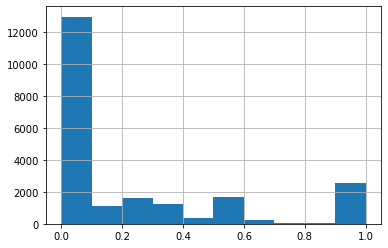

In [1863]:
label.hist()

## 목표변수와 입력변수 간 관계 확인

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 [Text(0, 0.5, 'order_nb'),
  Text(0, 1.5, 'revenue'),
  Text(0, 2.5, 'review_score'),
  Text(0, 3.5, 'delay'),
  Text(0, 4.5, 'avg_delivery'),
  Text(0, 5.5, 'preparation'),
  Text(0, 6.5, 'error'),
  Text(0, 7.5, 'canceled'),
  Text(0, 8.5, 'delivered'),
  Text(0, 9.5, '1'),
  Text(0, 10.5, '2'),
  Text(0, 11.5, '3'),
  Text(0, 12.5, '4'),
  Text(0, 13.5, '5'),
  Text(0, 14.5, 'canceled_rate'),
  Text(0, 15.5, 'unsatisfied_rate')])

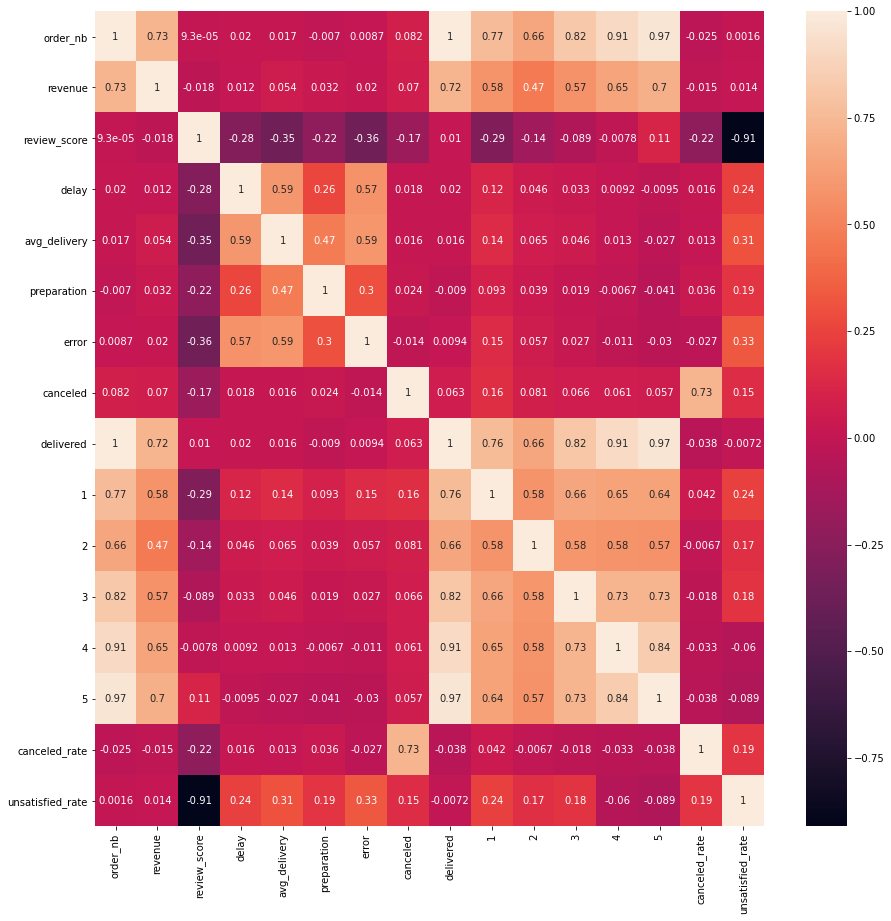

In [1861]:
plt.figure(figsize = (15,15))
sns.heatmap(df_model.corr(), annot = True)
plt.yticks(rotation = 0)

<AxesSubplot:xlabel='purchase_month', ylabel='unsatisfied_rate'>

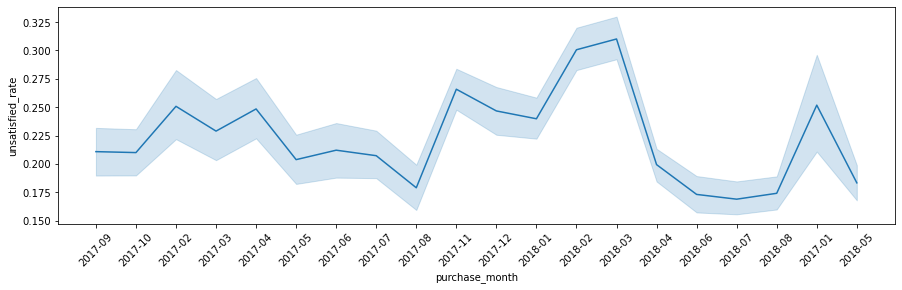

In [1866]:
plt.figure(figsize = (15,4))
plt.xticks(rotation = 45)
sns.lineplot(data = df_model, x = 'purchase_month', y = 'unsatisfied_rate')

<AxesSubplot:xlabel='new_category', ylabel='unsatisfied_rate'>

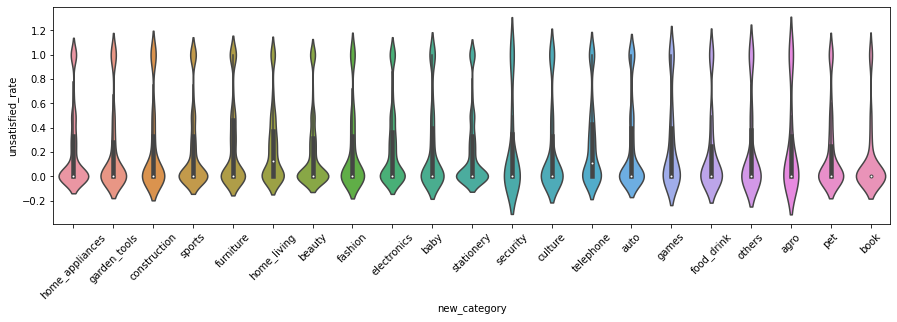

In [1868]:
plt.figure(figsize = (15,4))
plt.xticks(rotation = 45)
sns.violinplot(data = df_model, x = 'new_category', y = 'unsatisfied_rate')

## 모델 미사용 컬럼 제거 및 데이터셋 복제

In [1869]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21917 entries, 0 to 21916
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seller_id         21917 non-null  object 
 1   purchase_month    21917 non-null  object 
 2   new_category      21917 non-null  object 
 3   order_nb          21917 non-null  int64  
 4   revenue           21917 non-null  float64
 5   review_score      21917 non-null  float64
 6   delay             21438 non-null  float64
 7   avg_delivery      21438 non-null  float64
 8   preparation       21544 non-null  float64
 9   error             21917 non-null  float64
 10  canceled          21917 non-null  float64
 11  delivered         21917 non-null  float64
 12  1                 21917 non-null  float64
 13  2                 21917 non-null  float64
 14  3                 21917 non-null  float64
 15  4                 21917 non-null  float64
 16  5                 21917 non-null  float6

In [1880]:
# 미사용 컬럼 제거
df_model = df_model.drop(['purchase_month','order_nb', 'revenue', 'review_score', '1','2','3','4','5', 'unsatisfied_rate'], axis = 1)
df_model

seller_id     new_category      delay  \
0      0015a82c2db000af6aaaf3ae2ecb0532  home_appliances -23.000000   
1      0015a82c2db000af6aaaf3ae2ecb0532  home_appliances -13.000000   
2      001cca7ae9ae17fb1caed9dfb1094831  garden_tools    -18.200000   
3      001cca7ae9ae17fb1caed9dfb1094831  garden_tools    -10.636364   
4      001cca7ae9ae17fb1caed9dfb1094831  garden_tools    -13.416667   
...                                 ...           ...           ...   
21912  ffff564a4f9085cd26170f4732393726  auto            NaN          
21913  ffff564a4f9085cd26170f4732393726  construction    NaN          
21914  ffff564a4f9085cd26170f4732393726  food_drink      NaN          
21915  ffff564a4f9085cd26170f4732393726  home_appliances NaN          
21916  ffff564a4f9085cd26170f4732393726  auto            NaN          

       avg_delivery  preparation     error  canceled  delivered  canceled_rate  
0      10.000000     2.000000     0.000000  0.0       1.0        0.00           
1      10.500000     3.500000     0.000000  0.0       2.0        0.00           
2      15.800000     2.600000     0.000000  0.0       5.0        0.00           
3      12.818182     2.636364     0.090909  0.0       11.0       0.00           
4      11.916667     1.076923     0.076923  0.0       12.0       0.00           
...          ...          ...          ...  ...        ...        ...           
21912 NaN           NaN           0.000000  1.0       0.0        0.25           
21913 NaN           NaN           0.000000  1.0       0.0        1.00           
21914 NaN           NaN           0.000000  0.0       0.0        0.00           
21915 NaN           NaN           0.000000  1.0       0.0        0.50           
21916 NaN           NaN           0.000000  0.0       0.0        0.00           

[21917 rows x 9 columns]

In [1882]:
# 인코딩 실험을 위해 df_le, df_ohe로 복제
df_le = df_model.copy()
df_ohe = df_model.copy()

In [1883]:
df_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21917 entries, 0 to 21916
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seller_id      21917 non-null  object 
 1   new_category   21917 non-null  object 
 2   delay          21438 non-null  float64
 3   avg_delivery   21438 non-null  float64
 4   preparation    21544 non-null  float64
 5   error          21917 non-null  float64
 6   canceled       21917 non-null  float64
 7   delivered      21917 non-null  float64
 8   canceled_rate  21917 non-null  float64
dtypes: float64(7), object(2)
memory usage: 1.5+ MB


## seller_id 라벨인코딩

In [1884]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_le['seller_id'] = le.fit_transform(df_le['seller_id'])

In [1885]:
df_le.describe()

seller_id         delay  avg_delivery   preparation         error  \
count  21917.000000  21438.000000  21438.000000  21544.000000  21917.000000   
mean   1480.121321  -12.117707     11.829445     2.786770      0.063772       
std    869.071878    9.319713      8.406952      3.616121      0.197779       
min    0.000000     -147.000000    0.000000      0.000000      0.000000       
25%    749.000000   -16.500000     7.000000      1.000000      0.000000       
50%    1469.000000  -12.000000     10.000000     2.000000      0.000000       
75%    2228.000000  -8.000000      14.500000     3.333333      0.000000       
max    2977.000000   175.000000    195.000000    107.000000    1.000000       

           canceled     delivered  canceled_rate  
count  21917.000000  21917.000000  21917.000000   
mean   0.019574      4.156910      0.009569       
std    0.156767      9.230459      0.088617       
min    0.000000      0.000000      0.000000       
25%    0.000000      1.000000      0.000000       
50%    0.000000      2.000000      0.000000       
75%    0.000000      4.000000      0.000000       
max    5.000000      255.000000    1.000000

In [1886]:
df_le.describe(include = 'O')

new_category
count   21917      
unique  21         
top     stationery 
freq    2849

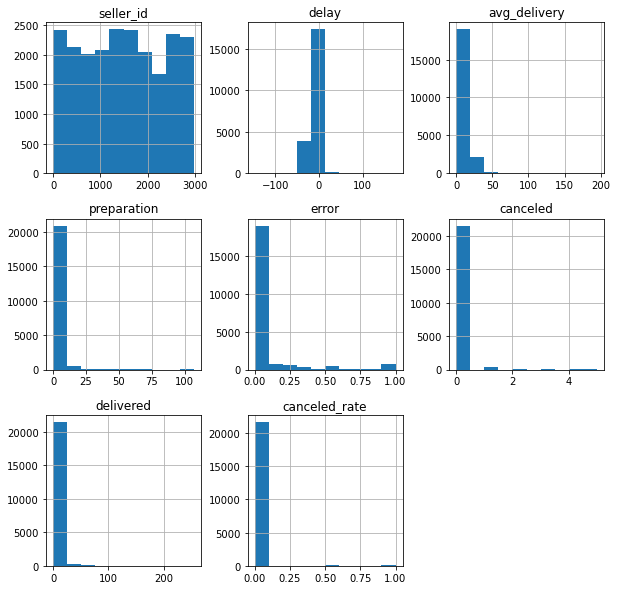

In [1887]:
g = df_le.hist(figsize = (10,10))

## 범주형, 연속형 컬럼 분리

In [1888]:
# 라벨인코딩
cat_columns = [c for c, t in zip(df_le.dtypes.index, df_le.dtypes) if t == 'O']
num_columns = [c for c in df_le.columns if c not in cat_columns]
print('Categorical Columns:\n{}\n\n Numeric Columns:\n{}\n'.format(cat_columns, num_columns))

Categorical Columns:
['new_category']

 Numeric Columns:
['seller_id', 'delay', 'avg_delivery', 'preparation', 'error', 'canceled', 'delivered', 'canceled_rate']



In [1905]:
# 원핫인코딩
cat_columns = [c for c, t in zip(df_ohe.dtypes.index, df_ohe.dtypes) if t == 'O']
num_columns = [c for c in df_ohe.columns if c not in cat_columns]
print('Categorical Columns:\n{}\n\n Numeric Columns:\n{}\n'.format(cat_columns, num_columns))

Categorical Columns:
['seller_id', 'new_category']

 Numeric Columns:
['delay', 'avg_delivery', 'preparation', 'error', 'canceled', 'delivered', 'canceled_rate']



## 전처리 함수

### 연속형 변수 전처리 x

In [1889]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def preprocess_std(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)
    
      
    # cat_columns 원핫인코딩
    ohe = OneHotEncoder(sparse=False)
    x_all = pd.concat([tmp_x_train[cat_columns], 
                       tmp_x_test[cat_columns]], axis=0)

    new_x_all = ohe.fit_transform(x_all)
    
    ohe_columns = []
    for cat in ohe.categories_:
        ohe_columns += cat.tolist()
    
    new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)

    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

### 연속형 변수 MinMaxScaler 처리

In [1898]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

def preprocess_norm(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)
    
    # num_columns 스케일링
    scaler = MinMaxScaler()
    tmp_x_train[num_columns] = scaler.fit_transform(tmp_x_train[num_columns])
    tmp_x_test[num_columns] = scaler.transform(tmp_x_test[num_columns])
        
    # cat_columns 원핫인코딩
    ohe = OneHotEncoder(sparse=False)
    x_all = pd.concat([tmp_x_train[cat_columns], 
                       tmp_x_test[cat_columns]], axis=0)

    new_x_all = ohe.fit_transform(x_all)
    
    ohe_columns = []
    for cat in ohe.categories_:
        ohe_columns += cat.tolist()
    
    new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)

    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

# 모형을 통한 예측

## train, test set 분리

In [1912]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_ohe, label, test_size=0.3,
                                                       random_state=2021,
                                                       shuffle=True)

In [1913]:
x_train.shape, x_test.shape

((15341, 9), (6576, 9))

### 입력변수 전처리

In [1914]:
x_train, x_test = preprocess_norm(x_train, x_test)

In [1915]:
x_train.shape, x_test.shape

((15341, 3006), (6576, 3006))

In [1916]:
x_train.describe()

delay  avg_delivery   preparation         error      canceled  \
count  15012.000000  15012.000000  15081.000000  15341.000000  15341.000000   
mean   0.408240      0.060563      0.026584      0.062975      0.003755       
std    0.030312      0.042730      0.034093      0.196778      0.030236       
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    0.393688      0.035897      0.009615      0.000000      0.000000       
50%    0.408638      0.051282      0.019231      0.000000      0.000000       
75%    0.421927      0.074359      0.031593      0.000000      0.000000       
max    1.000000      1.000000      1.000000      1.000000      1.000000       

          delivered  canceled_rate  0015a82c2db000af6aaaf3ae2ecb0532  \
count  15341.000000  15341.000000   15341.000000                       
mean   0.021341      0.009699       0.000130                           
std    0.047063      0.089970       0.011418                           
min    0.000000      0.000000       0.000000                           
25%    0.005181      0.000000       0.000000                           
50%    0.010363      0.000000       0.000000                           
75%    0.020725      0.000000       0.000000                           
max    1.000000      1.000000       1.000000                           

       001cca7ae9ae17fb1caed9dfb1094831  001e6ad469a905060d959994f1b41e4f  \
count  15341.000000                      15341.000000                       
mean   0.001369                          0.000065                           
std    0.036974                          0.008074                           
min    0.000000                          0.000000                           
25%    0.000000                          0.000000                           
50%    0.000000                          0.000000                           
75%    0.000000                          0.000000                           
max    1.000000                          1.000000                           

       002100f778ceb8431b7a1020ff7ab48f  004c9cd9d87a3c30c522c48c4fc07416  \
count  15341.000000                      15341.000000                       
mean   0.000326                          0.000847                           
std    0.018051                          0.029099                           
min    0.000000                          0.000000                           
25%    0.000000                          0.000000                           
50%    0.000000                          0.000000                           
75%    0.000000                          0.000000                           
max    1.000000                          1.000000                           

       00720abe85ba0859807595bbf045a33b  00ab3eff1b5192e5f1a63bcecfee11c8  \
count  15341.000000                      15341.000000                       
mean   0.000326                          0.000065                           
std    0.018051                          0.008074                           
min    0.000000                          0.000000                           
25%    0.000000                          0.000000                           
50%    0.000000                          0.000000                           
75%    0.000000                          0.000000                           
max    1.000000                          1.000000                           

       00d8b143d12632bad99c0ad66ad52825  00ee68308b45bc5e2660cd833c3f81cc  \
count  15341.000000                      15341.000000                       
mean   0.000065                          0.000782                           
std    0.008074                          0.027958                           
min    0.000000                          0.000000                           
25%    0.000000                          0.000000                           
50%    0.000000                          0.000000                           
75%    0.000000                 

## 모델 예측

### seller_id 라벨인코딩, 연속형변수 전처리 x

In [1897]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [#['MultiLayerPerceptron', MLPRegressor(random_state=2021)],
#           ['RandomForest', RandomForestRegressor(random_state=2021,
#                                                   n_jobs=-1)], 
          ['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

XGBoost Model MAE : 0.21403711732471048
XGBoost Model RMSE: 0.29965178995822384
LightGBM Model MAE : 0.2118967355857632
LightGBM Model RMSE: 0.28992363275769273
Best Model: LightGBM, RMSE: 0.28992363275769273


### seller_id 라벨인코딩, 연속형변수 minmaxscaler 전처리

In [1904]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [#['MultiLayerPerceptron', MLPRegressor(random_state=2021)],
#           ['RandomForest', RandomForestRegressor(random_state=2021,
#                                                   n_jobs=-1)], 
          ['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

XGBoost Model MAE : 0.21399140250256474
XGBoost Model RMSE: 0.29964081651616226
LightGBM Model MAE : 0.21178133752582945
LightGBM Model RMSE: 0.28953745151288296
Best Model: LightGBM, RMSE: 0.28953745151288296


### seller_id 원핫인코딩, 연속형변수 전처리 x

In [1911]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [#['MultiLayerPerceptron', MLPRegressor(random_state=2021)],
#           ['RandomForest', RandomForestRegressor(random_state=2021,
#                                                   n_jobs=-1)], 
          ['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

XGBoost Model MAE : 0.21103910870211526
XGBoost Model RMSE: 0.29007368428488634
LightGBM Model MAE : 0.2118144425948638
LightGBM Model RMSE: 0.28964706945359286
Best Model: LightGBM, RMSE: 0.28964706945359286


### seller_id 원핫인코딩, 연속형변수 minmaxscaler 전처리

In [1917]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

models = [#['MultiLayerPerceptron', MLPRegressor(random_state=2021)],
#           ['RandomForest', RandomForestRegressor(random_state=2021,
#                                                   n_jobs=-1)], 
          ['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

XGBoost Model MAE : 0.21106840530954696
XGBoost Model RMSE: 0.2900874744186743
LightGBM Model MAE : 0.2117517141994023
LightGBM Model RMSE: 0.289355378990733
Best Model: LightGBM, RMSE: 0.289355378990733


In [1919]:
top_model = models[1][1]
top_model

LGBMRegressor(random_state=2021)

In [1920]:
top_model.feature_importances_

array([695, 662, 471, ...,  18,  17,  22])

In [1921]:
pd.DataFrame(sorted(zip(top_model.feature_importances_,x_train.columns)), columns=['Value','Feature'])

Value                           Feature
0     0      0015a82c2db000af6aaaf3ae2ecb0532
1     0      001e6ad469a905060d959994f1b41e4f
2     0      002100f778ceb8431b7a1020ff7ab48f
3     0      004c9cd9d87a3c30c522c48c4fc07416
4     0      00720abe85ba0859807595bbf045a33b
...  ..                                   ...
3001  91     error                           
3002  138    delivered                       
3003  471    preparation                     
3004  662    avg_delivery                    
3005  695    delay                           

[3006 rows x 2 columns]

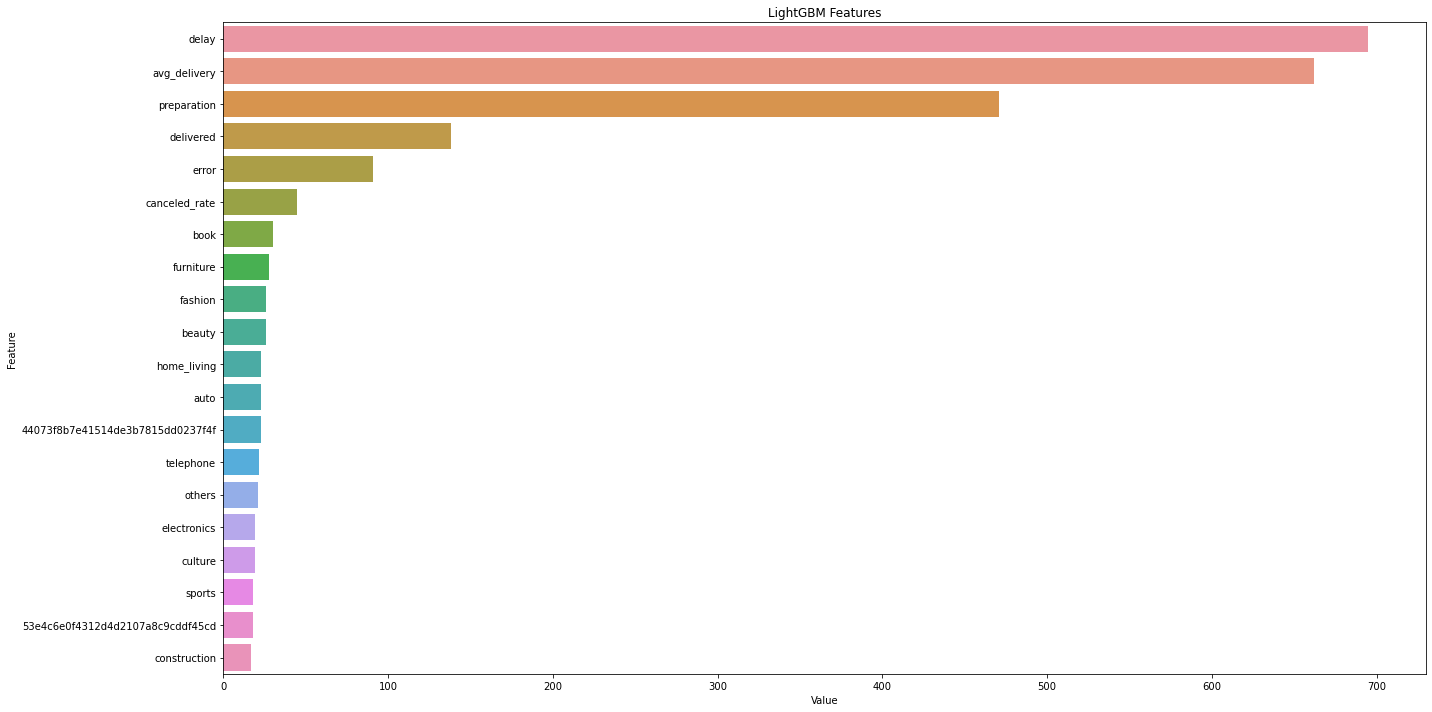

In [1924]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(top_model.feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')